# Method Comparison

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/method_comparison_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Read in Score Files

In [712]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

motif_summedScore_frame=pd.read_pickle('motif_summedScore_frame_C57BL6J.pickle')
# motif_summedScore_frame = motif_summedScore_frame.ix[:,3:]

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
normed_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
normed_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
normed_summedScore_frame.index = motif_summedScore_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [399]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_summedScore_frame = motif_summedScore_frame[motif_summedScore_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [170]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

## Run Different Methods

In [141]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
foJJr i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [218]:
numIterations = 5
test_size = 0.5

factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'atac','p65']
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
# c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values  

### Logistic Regression on Motif Scores

In [219]:
### for all peaks in vehicle for all motifs
factor_auc_dict_lr = {}
factor_precision_dict_lr = {}

for factorPair in factorPairs:
#     features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
        
        # average scoring metrics across iterations
        mean_roc_auc = np.mean(all_aucs)
        mean_precision = np.mean(all_precisions)

        
        print('_'.join(factorPair).replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision, 
              'numTestPositives:', np.sum(test_labels)
             )
        factor_auc_dict_lr['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_precision_dict_lr['_'.join(factorPair).replace('c57bl6_','')]= mean_precision

atf3_cjun roc: 0.811381840412 precision: 0.30530804084 numTestPositives: 4963
atf3_fos roc: 0.867812051646 precision: 0.143879824981 numTestPositives: 591
atf3_junb roc: 0.827312883716 precision: 0.0211165741745 numTestPositives: 146
atf3_jund roc: 0.809307021223 precision: 0.394238659064 numTestPositives: 7107
cjun_fos roc: 0.869283754362 precision: 0.112778987079 numTestPositives: 484
cjun_junb roc: 0.804200327949 precision: 0.0173647776757 numTestPositives: 121
cjun_jund roc: 0.806634958496 precision: 0.288168548482 numTestPositives: 4748
fos_jund roc: 0.86623501244 precision: 0.139209547986 numTestPositives: 569
junb_jund roc: 0.818950837378 precision: 0.0242662569003 numTestPositives: 144


### Logistic Regression on AP-1 Motif Score

In [220]:
### for all peaks in vehicle for AP-1 motif
factor_auc_dict_lrAP1only = {}
factor_precision_dict_lrAP1only = {}

for factorPair in factorPairs:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)][['ap-1']]

    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        
        # average scoring metrics across iterations
        mean_roc_auc = np.mean(all_aucs)
        mean_precision = np.mean(all_precisions)

        print('_'.join(factorPair).replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision,
              'numTestPositives:', np.sum(test_labels)
             )
        factor_auc_dict_lrAP1only['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_precision_dict_lrAP1only['_'.join(factorPair).replace('c57bl6_','')]= mean_precision


atf3_cjun roc: 0.69156455848 precision: 0.352229061761 numTestPositives: 5046
atf3_fos roc: 0.762358665995 precision: 0.320389916898 numTestPositives: 581
atf3_junb roc: 0.711702265009 precision: 0.243580794101 numTestPositives: 139
atf3_jund roc: 0.677637608699 precision: 0.391770217351 numTestPositives: 7200
cjun_fos roc: 0.773243783807 precision: 0.336563153341 numTestPositives: 443
cjun_junb roc: 0.728259014817 precision: 0.265776714567 numTestPositives: 132
cjun_jund roc: 0.689442710445 precision: 0.343012382267 numTestPositives: 4665
fos_jund roc: 0.77003594086 precision: 0.329703902094 numTestPositives: 530
junb_jund roc: 0.709494134385 precision: 0.250622670778 numTestPositives: 130


### Logistic Regression on Balanced Data

In [221]:
### for all peaks in vehicle for all motifs with balanced training data
factor_auc_dict_lrBalanced = {}
factor_precision_dict_lrBalanced = {}

for factorPair in factorPairs:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    
    if np.sum(labels) > 100:
        all_precisions = []
        all_aucs = []

        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)
            id_label_tuples = list(zip(training_labels.index.values, training_labels.values))
            id_label_dict = dict(zip(training_labels.index.values, training_labels.values))
            true_ids = [x[0] for x in id_label_tuples if x[1] == True]
            false_ids= [x[0] for x in id_label_tuples if x[1] == False]
            # randomly select as many False IDs randomly as True IDs
            shuffle(false_ids)
            selected_false_ids = false_ids[:len(true_ids)]

            balanced_training_ids = true_ids + selected_false_ids

            balanced_training_features = training_features[training_features.index.isin(balanced_training_ids)]
            balanced_training_labels = pd.Series([id_label_dict[x] for x in balanced_training_features.index.values],
                                                 index= balanced_training_features.index.values)



            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

            lr_classifier.fit(balanced_training_features, balanced_training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average=None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

        # average scoring metrics across iterations
        mean_roc_auc = np.mean(all_aucs)
        mean_precision = np.mean(all_precisions)
        
        print('_'.join(factorPair).replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision,
              'numTestPositives:', np.sum(test_labels)
             )
        factor_auc_dict_lrBalanced['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_precision_dict_lrBalanced['_'.join(factorPair).replace('c57bl6_','')]= mean_precision
    



atf3_cjun roc: 0.807283629048 precision: 0.295979997631 numTestPositives: 4980
atf3_fos roc: 0.842040838821 precision: 0.122107841155 numTestPositives: 573
atf3_junb roc: 0.737359427053 precision: 0.014704764846 numTestPositives: 143
atf3_jund roc: 0.808437433454 precision: 0.387644302418 numTestPositives: 7197
cjun_fos roc: 0.839010216595 precision: 0.0992701142907 numTestPositives: 493
cjun_junb roc: 0.746129457597 precision: 0.0126229186379 numTestPositives: 134
cjun_jund roc: 0.808880263098 precision: 0.284268749355 numTestPositives: 4676
fos_jund roc: 0.834930299753 precision: 0.110882106122 numTestPositives: 544
junb_jund roc: 0.750010514987 precision: 0.0166851040179 numTestPositives: 140


### gkmSVM (Gapped K-mer SVM)

In [222]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi

In [ ]:
### for all peaks in vehicle using gapped k-mers
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for factorPair in factorPairs:

    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) > 100:
        print(factorPair)
        all_aucs = []
        all_precisions = []
#         for iteration in range(numIterations):  
        for iteration in [0]:
            # split data into training and test sets
            # !!!features are not used - calculated so get GC matched split will operate!!!
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            # create fasta files for positive and negative sequences
            training_positive_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_positive_' +str(iteration) + '.fa'
            training_negative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_negative_' +str(iteration) + '.fa'
            training_shortNegative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_shortNegative_' +str(iteration) + '.fa'


            training_positive_file = open(training_positive_path,'w' )
            training_negative_file = open(training_negative_path,'w' )
            training_shortNegative_file = open(training_shortNegative_path,'w' )
            test_positive_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_positive_' +str(iteration) + '.fa'
            test_negative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_negative_' +str(iteration) + '.fa'
            test_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_' + str(iteration) + '.fa'

            test_positive_file = open(test_positive_path,'w' )
            test_negative_file = open(test_negative_path,'w' )

            test_file = open(test_path,'w')

            numPositiveSeqs = np.sum(training_labels)
            count=0
            for i in range(len(training_labels)):
                index = training_labels.index[i]
                label = training_labels[i]
                seq = _id_sequence_dict[index]
                if label == True:
                    training_positive_file.write('>' + index + '\n')
                    training_positive_file.write(seq + '\n')
                else:
                    if count < numPositiveSeqs:
                        training_shortNegative_file.write('>' + index + '\n')
                        training_shortNegative_file.write(seq + '\n')
                    training_negative_file.write('>' + index + '\n')
                    training_negative_file.write(seq + '\n')
                    count+=1

            for i in range(len(test_labels)):
                index = test_labels.index[i]
                label = test_labels[i]
                seq = _id_sequence_dict[index]
                test_file.write('>' + index + '\n')
                test_file.write(seq + '\n')
                if label == True:
                    test_positive_file.write('>' + index + '\n')
                    test_positive_file.write(seq + '\n')
                else:
                    test_negative_file.write('>' + index + '\n')
                    test_negative_file.write(seq + '\n')


            training_positive_file.close()
            training_negative_file.close()
            training_shortNegative_file.close()
            test_positive_file.close()
            test_negative_file.close()
            test_file.close()

            #  Run classifier
#             model_prefix = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_' +str(iteration) + '_balanced'
            model_prefix = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_balanced'
            model_path = model_prefix + '.model.txt'
            results_path = model_prefix + '_results.txt'
            results_negative_path = model_prefix + '_results_negative.txt'
            results_positive_path = model_prefix + '_results_positive.txt'

            if not os.path.isfile(model_path):     
                os.system('gkmtrain '+ training_positive_path + ' ' + training_shortNegative_path + ' ' + model_prefix +
                      ' -T 16 -m 64000')
            os.system('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 16')

            index_score_dict = {} #{peakID: gkmSVM score}
            with open(results_path) as f:
                data = f.readlines()
            for line in data:
                tokens=line.strip().split()
                score = float(tokens[1])
                index = tokens[0]
                index_score_dict[index] = score
            sorted_scores = np.array([index_score_dict[x] for x in test_labels.index.values])
            min_score = np.min(sorted_scores)
            if min_score < 0:
                normalized_scores = sorted_scores + abs(min_score)
            normalized_scores = normalized_scores/np.max(normalized_scores)

            # score predictions
#             fpr, tpr, thresholds_roc_gkmsvm = sklearn.metrics.roc_curve(test_labels, normalized_scores)
#             current_roc_auc = auc(fpr, tpr)            
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
            print(current_roc_auc, current_roc_score)
            all_precisions.append(current_precision)
            all_aucs.append(current_roc_auc)
            
        # average scoring metrics 
        
        mean_roc_auc = np.mean(all_aucs) 
        mean_precision = np.mean(all_precisions)
        
        factor_auc_dict_gkmSVM['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_precision_dict_gkmSVM['_'.join(factorPair).replace('c57bl6_','')]= mean_precision
        
        print('_'.join(factorPair).replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision,
              'numTestPositives:', np.sum(test_labels)
             )



('c57bl6_atf3', 'c57bl6_cjun')
0.786577510042 0.786577510042
atf3_cjun roc: 0.786577510042 precision: 0.302922750338 numTestPositives: 5056
('c57bl6_atf3', 'c57bl6_fos')


In [ ]:
### for all peaks in vehicle using gapped k-mers
factor_auc_dict_unbalancedgkmSVM = {}
factor_precision_dict_unbalancedgkmSVM = {}

for factorPair in factorPairs:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]

    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) > 100:
        all_aucs = []
        all_precisions = []
    
#         for iteration in range(numIterations):    
        for iteration in [0]:
            # split data into training and test sets
            # !!!features are not used - calculated so get GC matched split will operate!!!
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            # create fasta files for positive and negative sequences
            training_positive_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_positive_' +str(iteration) + '.fa'
            training_negative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_negative_' +str(iteration) + '.fa'
            training_shortNegative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_shortNegative_' +str(iteration) + '.fa'


            training_positive_file = open(training_positive_path,'w' )
            training_negative_file = open(training_negative_path,'w' )
            test_positive_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_positive_' +str(iteration) + '.fa'
            test_negative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_negative_' +str(iteration) + '.fa'
            test_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_' + str(iteration) + '.fa'

            test_positive_file = open(test_positive_path,'w' )
            test_negative_file = open(test_negative_path,'w' )

            test_file = open(test_path,'w')

            numPositiveSeqs = np.sum(training_labels)
            count=0
            for i in range(len(training_labels)):
                index = training_labels.index[i]
                label = training_labels[i]
                seq = _id_sequence_dict[index]
                if label == True:
                    training_positive_file.write('>' + index + '\n')
                    training_positive_file.write(seq + '\n')
                else:
                    training_negative_file.write('>' + index + '\n')
                    training_negative_file.write(seq + '\n')
                    count+=1

            for i in range(len(test_labels)):
                index = test_labels.index[i]
                label = test_labels[i]
                seq = _id_sequence_dict[index]
                test_file.write('>' + index + '\n')
                test_file.write(seq + '\n')
                if label == True:
                    test_positive_file.write('>' + index + '\n')
                    test_positive_file.write(seq + '\n')
                else:
                    test_negative_file.write('>' + index + '\n')
                    test_negative_file.write(seq + '\n')


            training_positive_file.close()
            training_negative_file.close()
            test_positive_file.close()
            test_negative_file.close()
            test_file.close()

            #  Run classifier
#             model_prefix = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_' +str(iteration) + '_unbalanced'
            model_prefix = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_unbalanced'
            model_path = model_prefix + '.model.txt'
            results_path = model_prefix + '_results.txt'
            results_negative_path = model_prefix + '_results_negative.txt'
            results_positive_path = model_prefix + '_results_positive.txt'

            if not os.path.isfile(model_path):
                os.system('gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                      ' -T 16 -m 64000')       

            os.system('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 16')


            index_score_dict = {} #{peakID: gkmSVM score}
            with open(results_path) as f:
                data = f.readlines()
            for line in data:
                tokens=line.strip().split()
                score = float(tokens[1])
                index = tokens[0]
                index_score_dict[index] = score
            sorted_scores = np.array([index_score_dict[x] for x in test_labels.index.values])
            min_score = np.min(sorted_scores)
            if min_score < 0:
                normalized_scores = sorted_scores + abs(min_score)
            normalized_scores = normalized_scores/np.max(normalized_scores)

            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
            
            all_precisions.append(current_precision)
            all_aucs.append(current_roc_auc)
            
        # average scoring metrics 
        
        mean_roc_auc = np.mean(all_aucs) 
        mean_precision = np.mean(all_precisions)
        
        factor_auc_dict_unbalancedgkmSVM['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_precision_dict_unbalancedgkmSVM['_'.join(factorPair).replace('c57bl6_','')]= mean_precision
        
        print('_'.join(factorPair).replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision,
              'numTestPositives:', np.sum(test_labels)
             )
    





### Classifier Performance

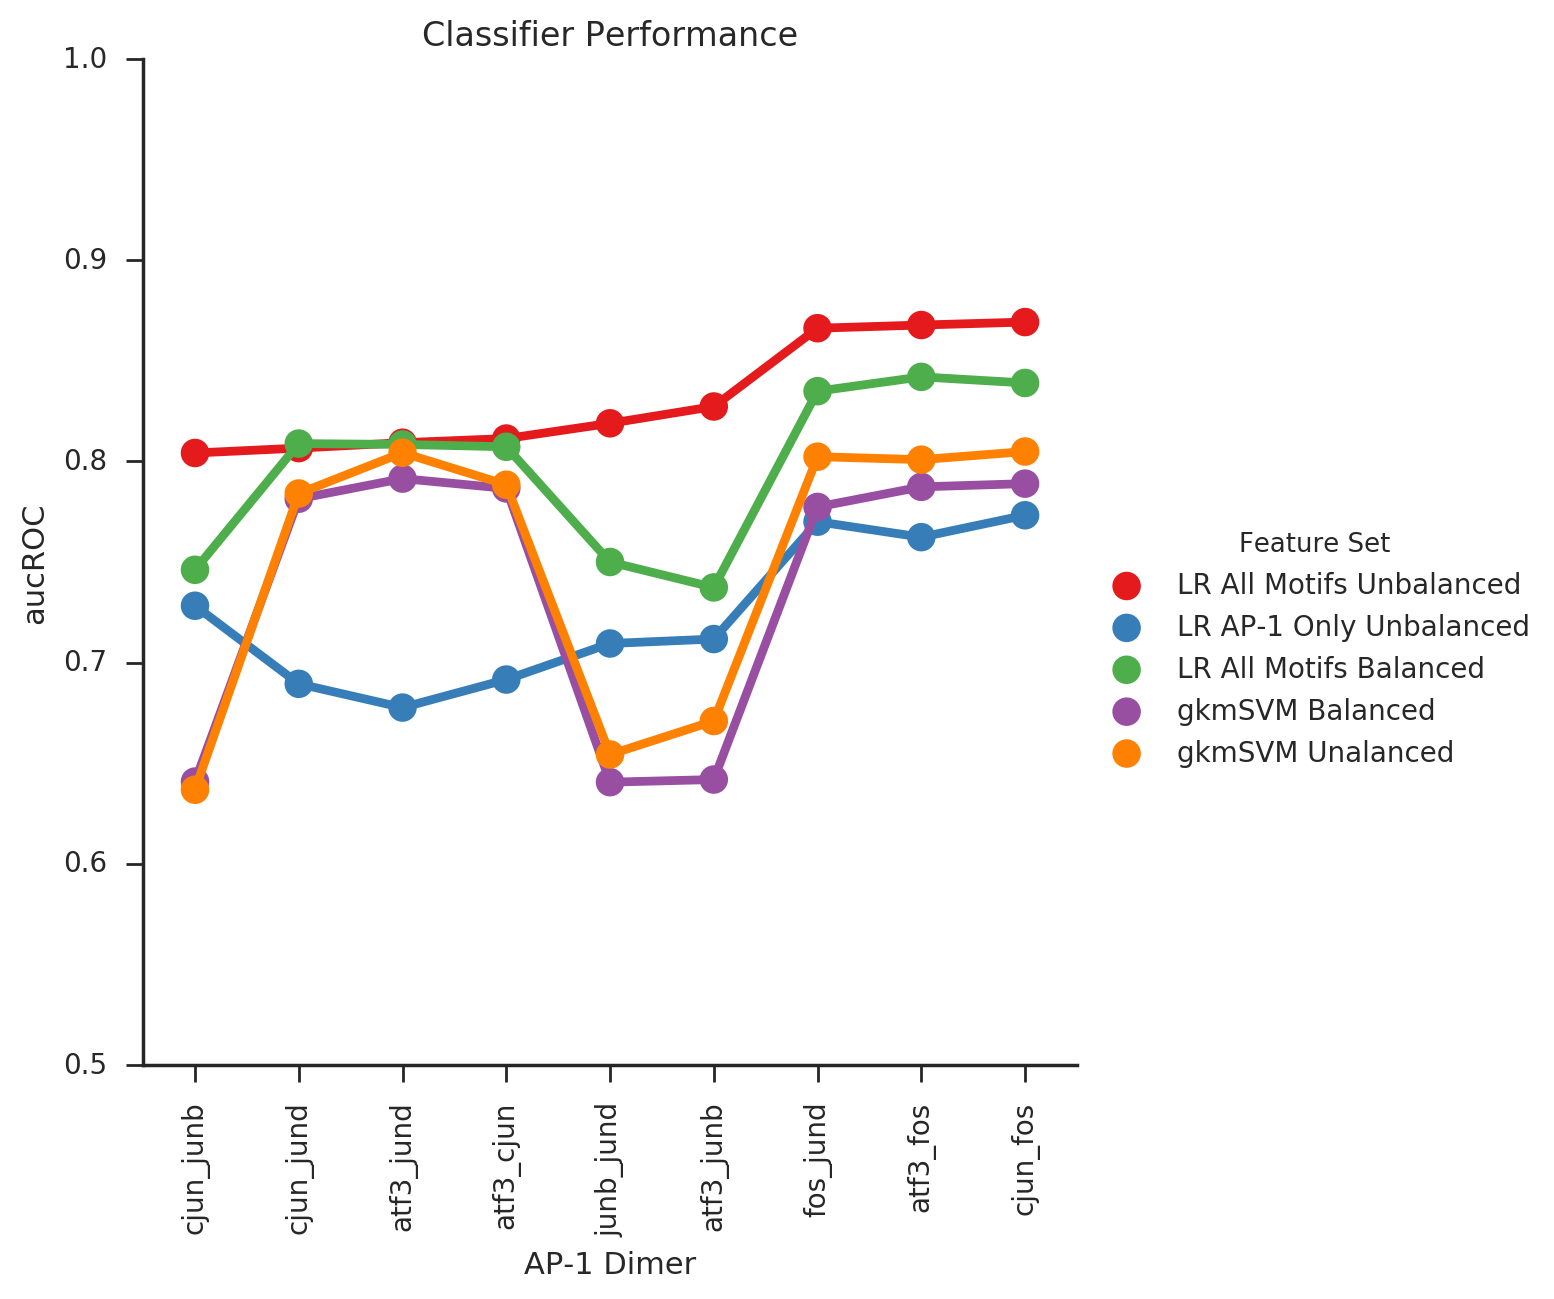

In [241]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_lr.keys()):
    factors = factors + 5 * [factor]
    features = features + [ 'LR All Motifs Unbalanced','LR AP-1 Only Unbalanced', 'LR All Motifs Balanced', 'gkmSVM Balanced', 'gkmSVM Unalanced']
    aucs.append(factor_auc_dict_lr[factor])
    aucs.append(factor_auc_dict_lrAP1only[factor])
    aucs.append(factor_auc_dict_lrBalanced[factor])
    aucs.append(factor_auc_dict_gkmSVM[factor])
    aucs.append(factor_auc_dict_unbalancedgkmSVM[factor])


data = pd.DataFrame({'Factor':factors,
                     'AUC':aucs,
                     'Feature Set':features})

# sort factors according to ascending AUC with all motifs
factor_auc_tuples = tuple(zip(data[data['Feature Set']=='LR All Motifs Unbalanced']['Factor'], data[data['Feature Set']=='LR All Motifs Unbalanced']['AUC']))

sorted_factors = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]

with sns.axes_style('ticks'):
    plottingFrame = sns.factorplot(data = data,
                                x='Factor',
                                y='AUC',
                                order = sorted_factors,
                                hue='Feature Set',
                                palette='Set1',
                                size=6)

    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
    plt.ylim(0.5,1)
    plt.title('Classifier Performance')
    plt.savefig('roc_comparison.pdf', bbox_inches='tight')
    

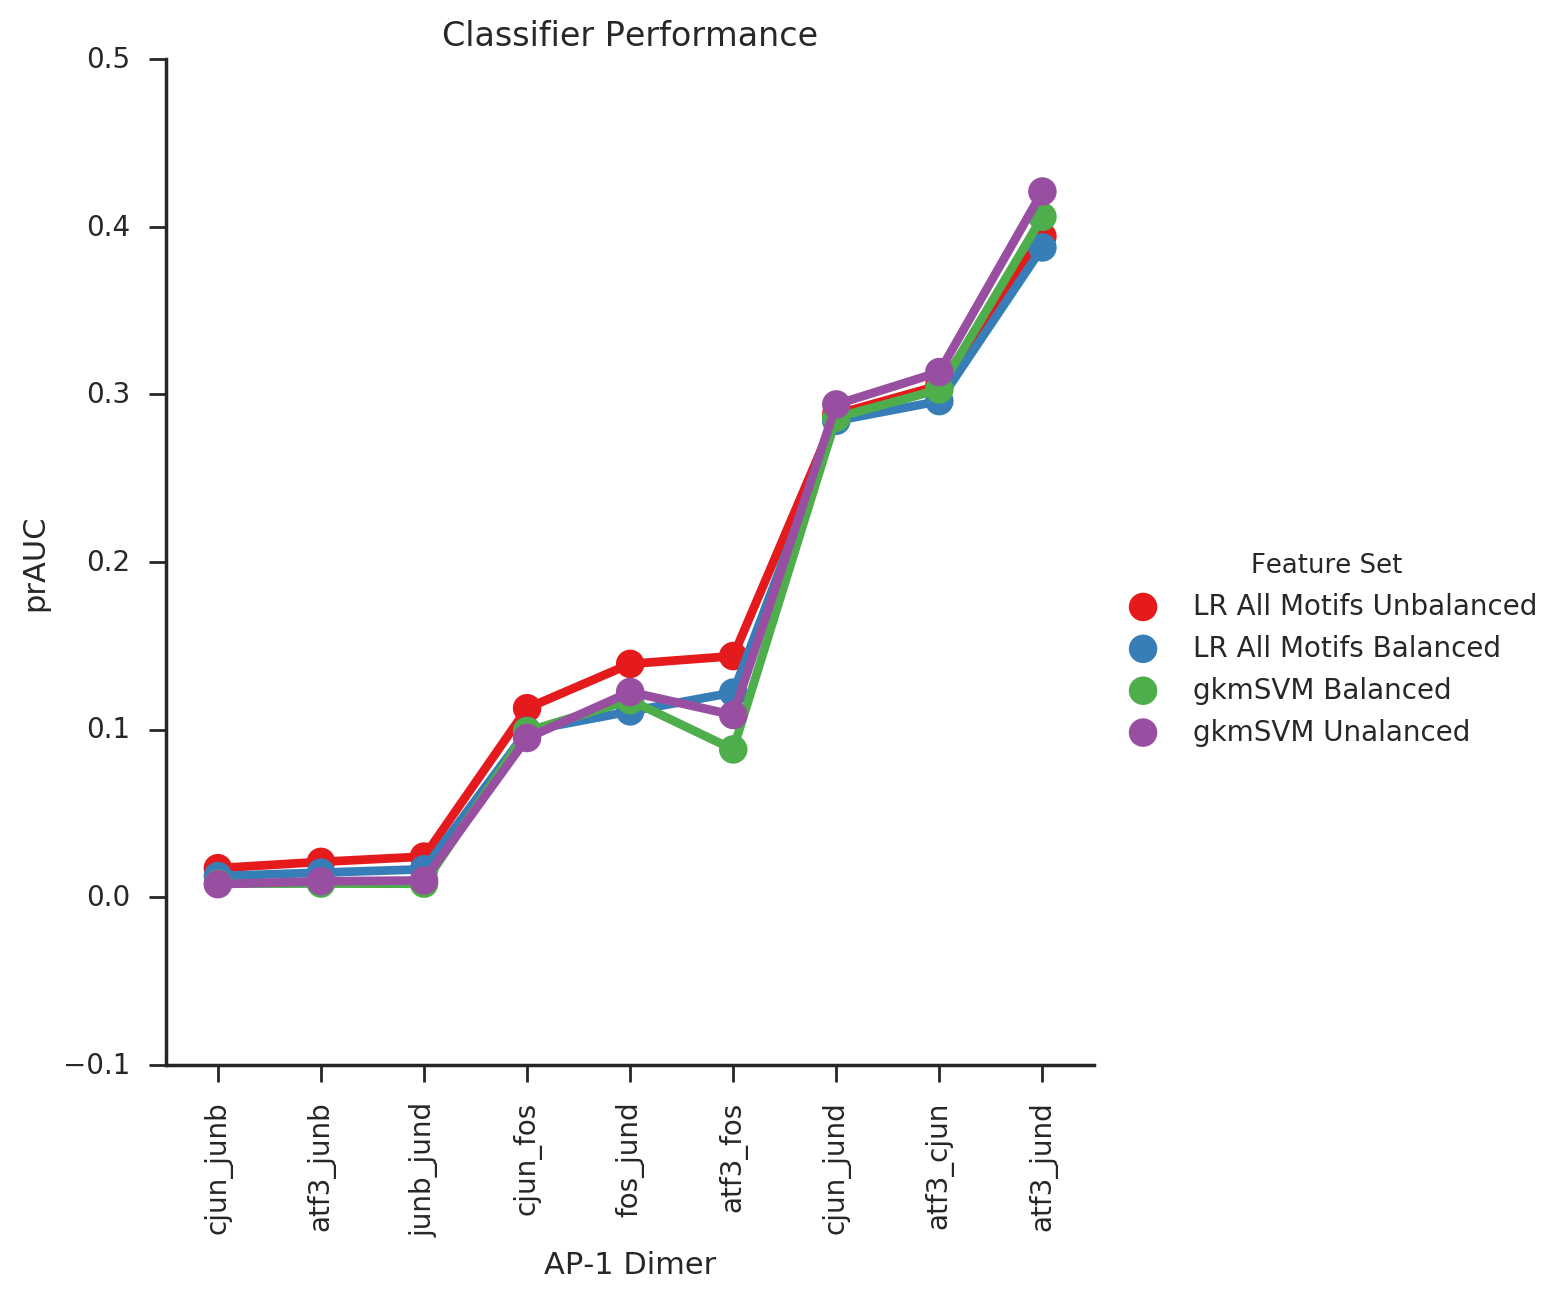

In [240]:
factors = []
precisions = []
features = []
for factor in sorted(factor_precision_dict_lr.keys()):
    factors = factors + 4 * [factor]
#     features = features + [ 'LR All Motifs Unbalanced','LR AP-1 Only Unbalanced', 'LR All Motifs Balanced', 'gkmSVM Balanced', 'gkmSVM Unalanced']
    features = features + [ 'LR All Motifs Unbalanced', 'LR All Motifs Balanced', 'gkmSVM Balanced', 'gkmSVM Unalanced']


    precisions.append(factor_precision_dict_lr[factor])
#     precisions.append(factor_precision_dict_lrAP1only[factor])
    precisions.append(factor_precision_dict_lrBalanced[factor])
    precisions.append(factor_precision_dict_gkmSVM[factor])
    precisions.append(factor_precision_dict_unbalancedgkmSVM[factor])


data = pd.DataFrame({'Factor':factors,
                     'Precision':precisions,
                     'Feature Set':features})

# sort factors according to ascending precision with all motifs
factor_precision_tuples = tuple(zip(data[data['Feature Set']=='LR All Motifs Unbalanced']['Factor'], data[data['Feature Set']=='LR All Motifs Unbalanced']['Precision']))

sorted_factors = [y[0] for y in sorted(factor_precision_tuples, key=lambda x:x[1])]

with sns.axes_style('ticks'):
    plottingFrame = sns.factorplot(data = data,
                                x='Factor',
                                y='Precision',
                                order = sorted_factors,
                                hue='Feature Set',
                                palette='Set1',
                                size=6)

    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('prAUC')
    plt.xlabel('AP-1 Dimer')
#     plt.ylim(0.5,1)
    plt.title('Classifier Performance')
    plt.savefig('pr_comparison.pdf',bbox_inches='tight')

## Grid Search

C : float, optional (default=1.0)

Inverse of regularization strength; must be a positive float. 

Like in support vector machines, smaller values specify stronger regularization.


In [140]:
numIterations = 5
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac','p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values  

In [ ]:
### for all peaks in vehicle for all motifs
C_vals = []
factorPair_vals = []
aucs = []

for c in [10**x for x in range(-4,4)]:
    for factorPair in factorPairs:
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
                 summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
        all_aucs = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', C=c)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            all_aucs.append(current_roc_auc)

        mean_roc_auc = np.mean(all_aucs) # average aucROC
        print(c, factorPair, mean_roc_auc)
        C_vals.append(c)
        factorPair_vals.append('_'.join(factorPair).replace('c57bl6_',''))
        aucs.append(mean_roc_auc)



In [158]:
c_range = [10**x for x in range(-4,4)]
ap1_dimers = ['_'.join(x).replace('c57bl6_','') for x in factorPairs]
c_index_dict = dict(zip(c_range, range(len(c_range))))
dimer_index_dict = dict(zip(ap1_dimers, range(len(ap1_dimers))))
matrix = np.zeros((len(ap1_dimers), len(c_range)))
for i in range(len(C_vals)):
    dimer = factorPair_vals[i]
    c= C_vals[i]
    auc_val = aucs[i]
    row_index = dimer_index_dict[dimer]
    col_index = c_index_dict[c]
    matrix[row_index][col_index] = auc_val
c_frame = pd.DataFrame(matrix, columns=[str(x) for x in c_range], index= ap1_dimers)
                    

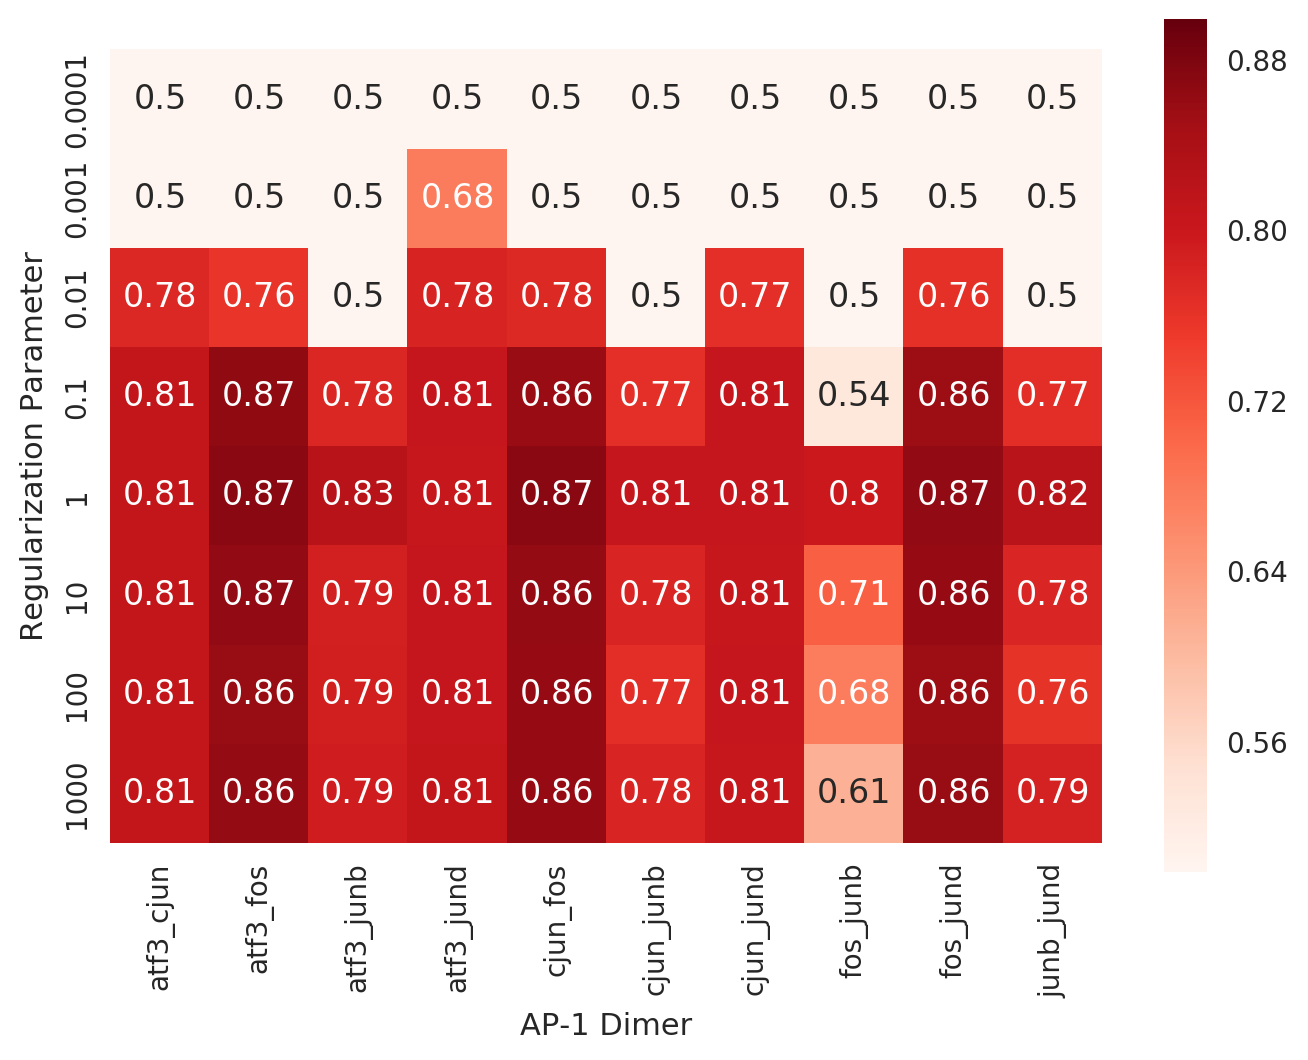

In [165]:
sns.heatmap(c_frame.T,
            cmap='Reds',
           square = True,
           annot=True,
           fmt='.2g',
           vmin=0.5,
           vmax=0.90)
plt.xlabel('AP-1 Dimer')
plt.ylabel('Regularization Parameter')

In [ ]:
### for all peaks in vehicle for all motifs
C_vals_ones = []
factorPair_vals_ones = []
aucs_ones = []

for c in range(1,10):
    for factorPair in factorPairs:
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
                 summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
        all_aucs_ones = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', C=c)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            all_aucs_ones.append(current_roc_auc)

        mean_roc_auc = np.mean(all_aucs_ones) # average aucROC
        print(c, factorPair, mean_roc_auc)
        C_vals_ones.append(c)
        factorPair_vals_ones.append('_'.join(factorPair).replace('c57bl6_',''))
        aucs_ones.append(mean_roc_auc)




In [170]:
c_range = [x for x in range(1,10)]
ap1_dimers = ['_'.join(x).replace('c57bl6_','') for x in factorPairs]
c_index_dict = dict(zip(c_range, range(len(c_range))))
dimer_index_dict = dict(zip(ap1_dimers, range(len(ap1_dimers))))
matrix = np.zeros((len(ap1_dimers), len(c_range)))

for i in range(len(C_vals)):
    dimer = factorPair_vals[i]
    c= C_vals_ones[i]
    auc_val = aucs_ones[i]
    row_index = dimer_index_dict[dimer]
    col_index = c_index_dict[c]
    matrix[row_index][col_index] = auc_val
c_frame_ones = pd.DataFrame(matrix, columns=[str(x) for x in c_range], index= ap1_dimers)
                    

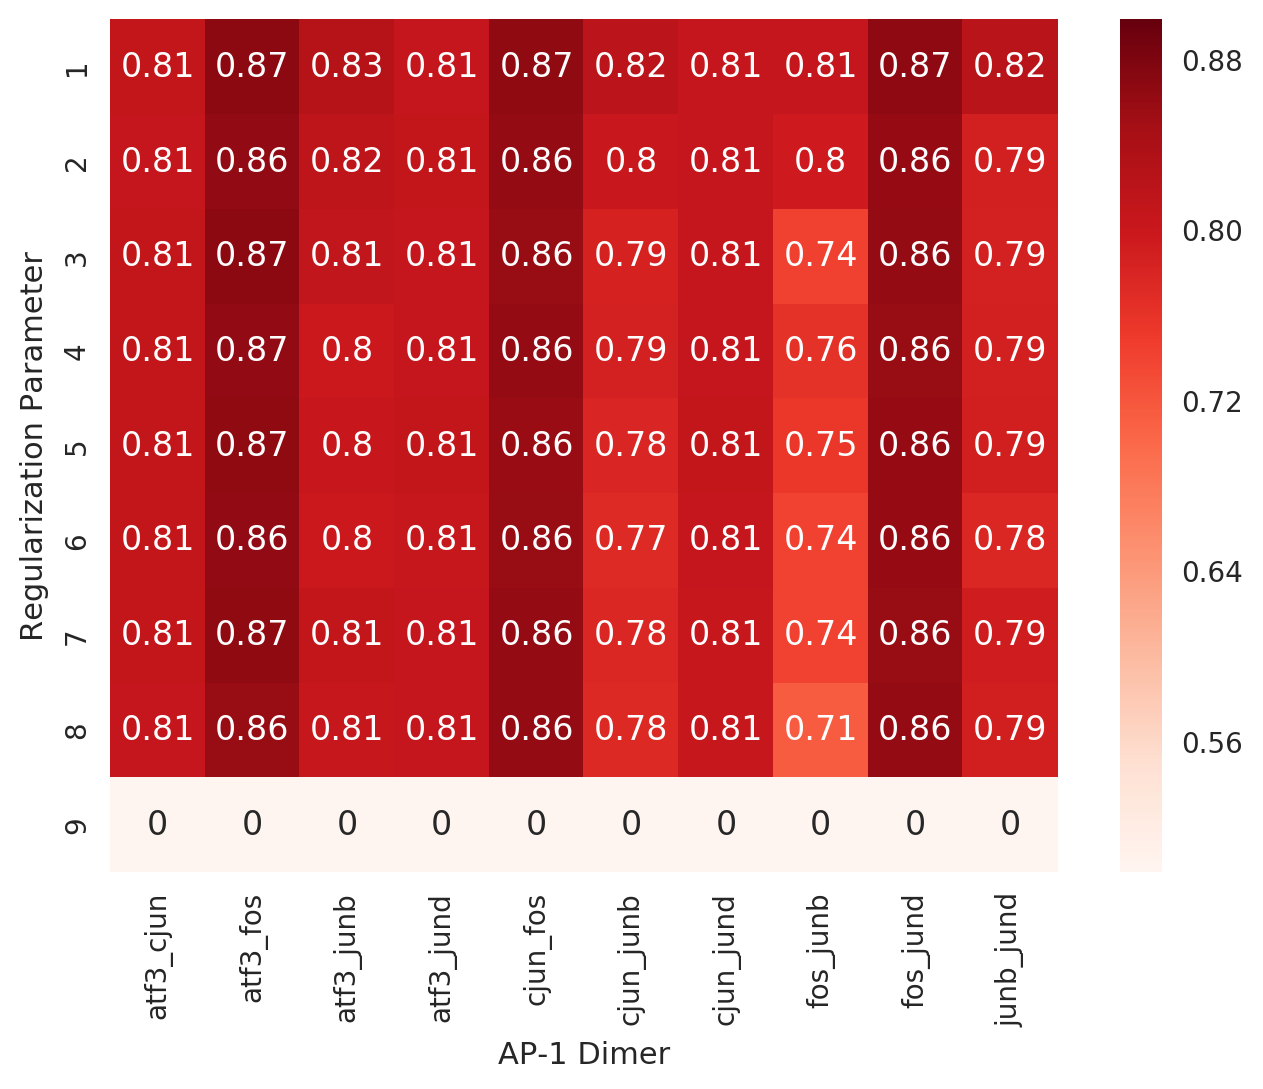

In [171]:
sns.heatmap(c_frame_ones.T,
            cmap='Reds',
           square = True,
           annot=True,
           fmt='.2g',
           vmin=0.5,
           vmax=0.90)
plt.xlabel('AP-1 Dimer')
plt.ylabel('Regularization Parameter')

In [ ]:
### for all peaks in vehicle for all motifs
C_vals_tenths = []
factorPair_vals_tenths = []
aucs_tenths = []

for c in np.arange(0.1,1,0.1):
    for factorPair in factorPairs:
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
        all_aucs_tenths = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', C=c)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)

            # score predictions
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            all_aucs_tenths.append(current_roc_auc)

        mean_roc_auc = np.mean(all_aucs_tenths) # average aucROC
        print(c, factorPair, mean_roc_auc)
        C_vals_tenths.append(c)
        factorPair_vals_tenths.append('_'.join(factorPair).replace('c57bl6_',''))
        aucs_tenths.append(mean_roc_auc)






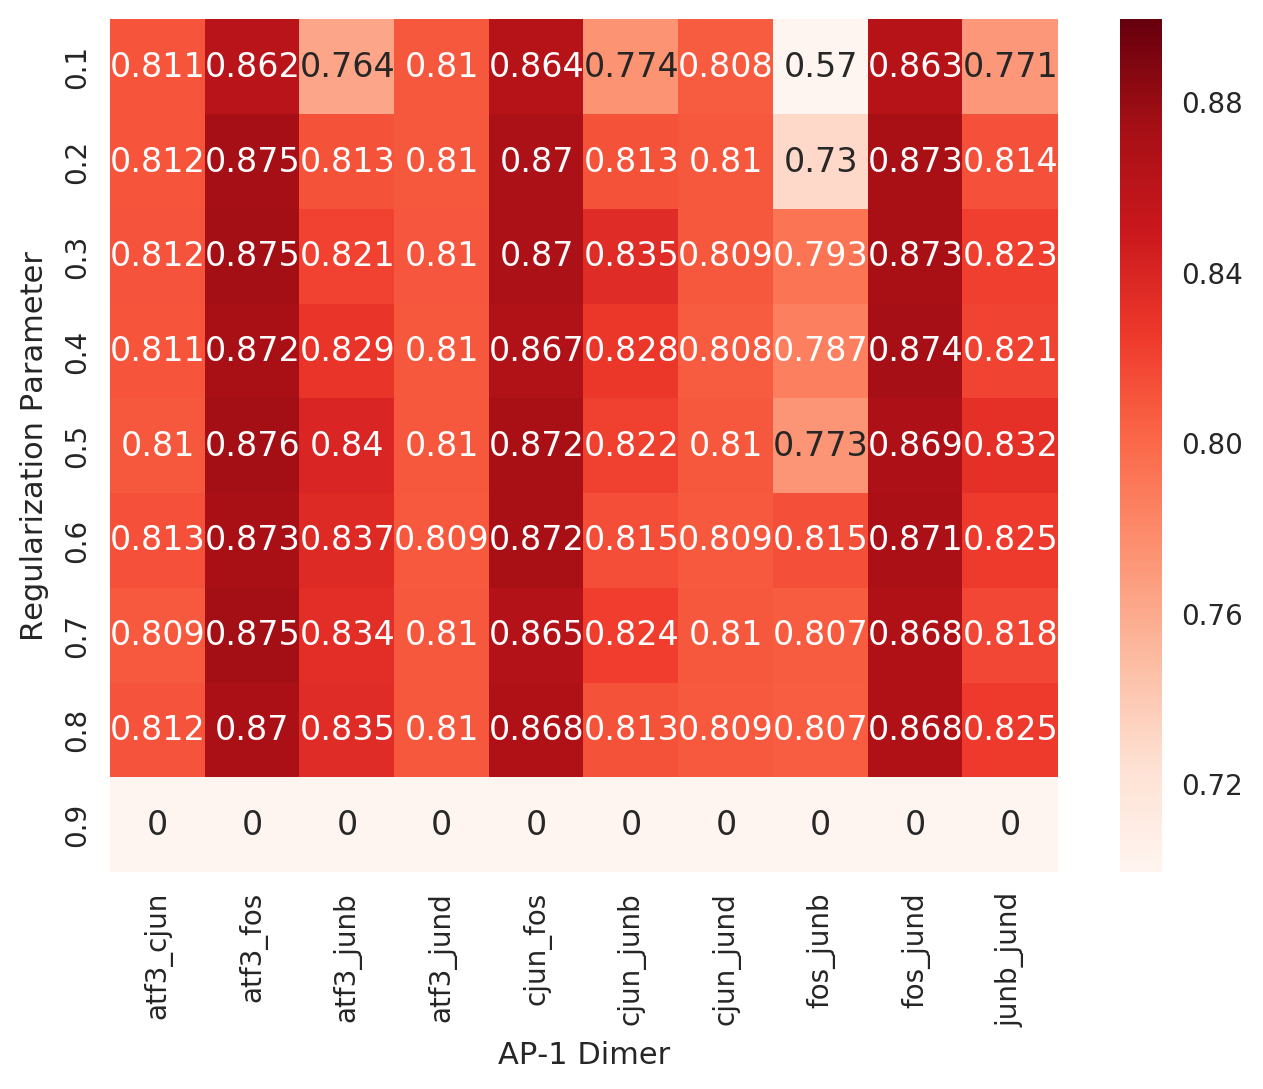

In [176]:
c_range = np.arange(0.1,1,0.1)
ap1_dimers = ['_'.join(x).replace('c57bl6_','') for x in factorPairs]
c_index_dict = dict(zip(c_range, range(len(c_range))))
dimer_index_dict = dict(zip(ap1_dimers, range(len(ap1_dimers))))
matrix = np.zeros((len(ap1_dimers), len(c_range)))

for i in range(len(C_vals)):
    dimer = factorPair_vals[i]
    c= C_vals_tenths[i]
    auc_val = aucs_tenths[i]
    row_index = dimer_index_dict[dimer]
    col_index = c_index_dict[c]
    matrix[row_index][col_index] = auc_val
c_frame_tenths = pd.DataFrame(matrix, columns=[str(x) for x in c_range], index= ap1_dimers)
                    

sns.heatmap(c_frame_tenths.T,
            cmap='Reds',
           square = True,
           annot=True,
           fmt='.3g',
           vmin=0.7,
           vmax=0.90)
plt.xlabel('AP-1 Dimer')
plt.ylabel('Regularization Parameter')

## Z-Score Normalization (standardization) and Motif Selection Experiments

In [647]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [648]:
# standardize motif scores
scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

In [649]:
### for all peaks in vehicle for all motifs
numIterations = 5
factor_coeff_dict = {}
factor_auc_dict_veh = {}
factor_prob_dict_veh = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  


for factorPair in factorPairs:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_coeficients = []
        all_probs = None
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retreive probabilities for each classifier
            probas_lr = lr_classifier.predict_proba(test_features)
            # retrieve predictions for each classifier
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])\

            current_roc_auc = auc(fpr, tpr)
            all_aucs.append(current_roc_auc)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        all_probs = all_probs/numIterations
        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

        factor_auc_dict_veh['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_coeff_dict['_'.join(factorPair).replace('c57bl6_','')] = mean_coefficients
        factor_prob_dict_veh['_'.join(factorPair).replace('c57bl6_','')] = all_probs
        print(factorPair, mean_roc_auc)
coefficients_frame_veh_std = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_std.index = standardized_motif_frame.columns.values
probs_frame_veh = pd.DataFrame(factor_prob_dict_veh,
                              index = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)].index.values)



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


('c57bl6_atf3', 'c57bl6_cjun') 0.811174822678
('c57bl6_atf3', 'c57bl6_fos') 0.860307972809
('c57bl6_atf3', 'c57bl6_junb') 0.795845554886
('c57bl6_atf3', 'c57bl6_jund') 0.807917053129
('c57bl6_cjun', 'c57bl6_fos') 0.863626831553
('c57bl6_cjun', 'c57bl6_junb') 0.788052188838
('c57bl6_cjun', 'c57bl6_jund') 0.80725888725
('c57bl6_fos', 'c57bl6_jund') 0.85605969783
('c57bl6_junb', 'c57bl6_jund') 0.778600796684


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


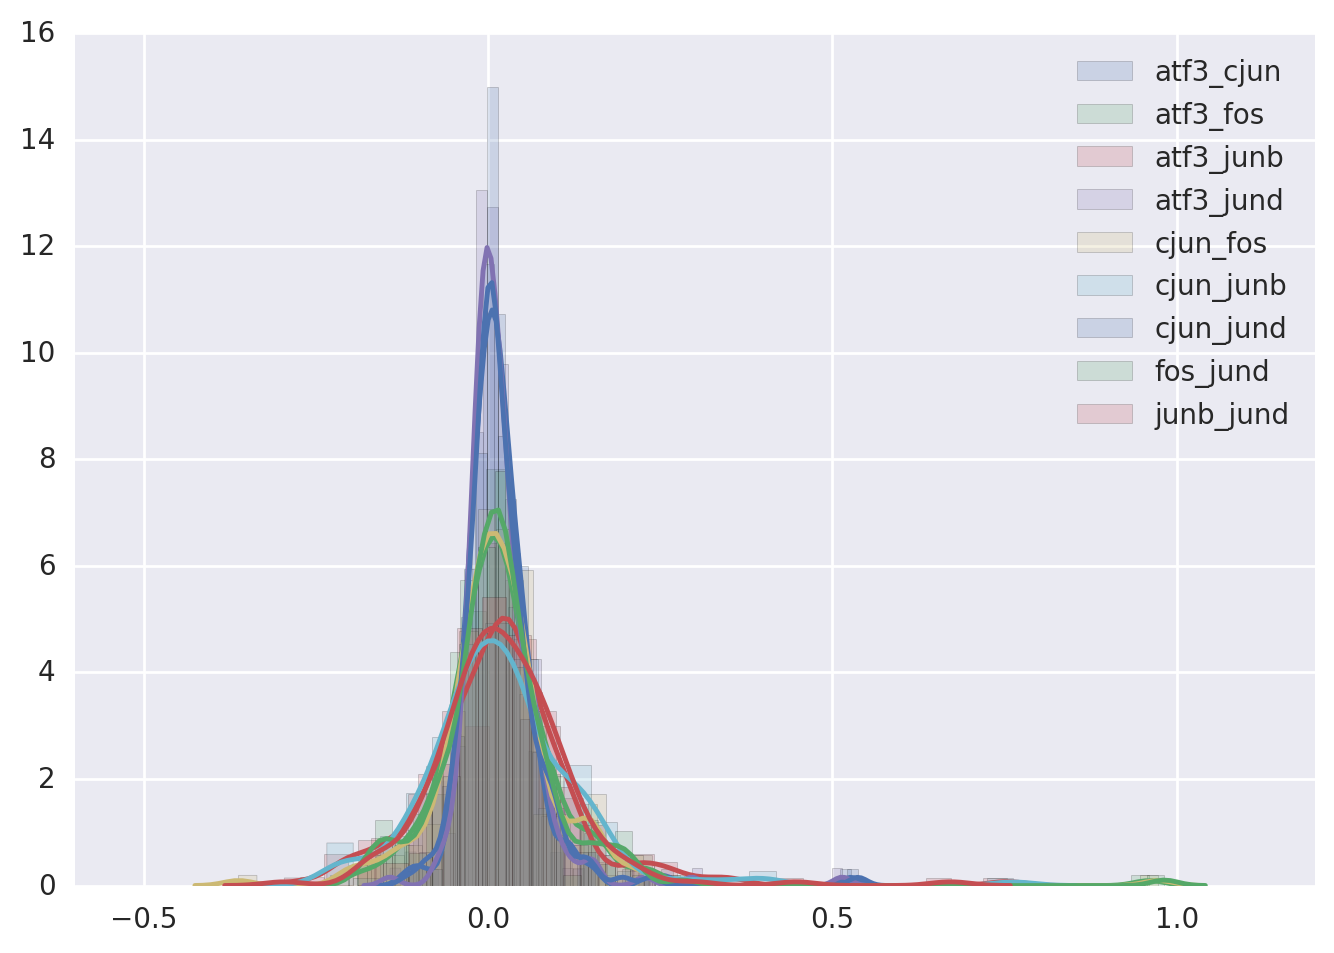

In [656]:
for col in coefficients_frame_veh_std.columns.values:
    sns.distplot(coefficients_frame_veh_std[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

In [651]:
# t-test on distributions of weights
# demonstrate that the distributions are have similar distributions
p_threshold = 0.05
dimers = coefficients_frame_veh_std.columns.values
for i in range(len(dimers) - 1):
    d1 = dimers[i]
    for j in range(i + 1, len(dimers)):
        d2 = dimers[j]
        d1_weights = coefficients_frame_veh_std[d1]
        d2_weights = coefficients_frame_veh_std[d2]
        stat, pval_ttest = scipy.stats.ttest_ind(d1_weights, d2_weights)
        stat, pval_bartlett = scipy.stats.bartlett(d1_weights, d2_weights)
        if pval_ttest < p_threshold or pval_bartlett < p_threshold:
            print(d1, d2, pval_ttest, pval_bartlett)
        else:
            print(d1, d2, 'have similar distributions')

atf3_cjun atf3_fos 0.941521644525 2.28846804023e-12
atf3_cjun atf3_junb 0.973592877487 1.86697322776e-17
atf3_cjun atf3_jund have similar distributions
atf3_cjun cjun_fos 0.755176221421 1.09808988902e-14
atf3_cjun cjun_junb 0.908476117364 2.29046735662e-18
atf3_cjun cjun_jund have similar distributions
atf3_cjun fos_jund 0.895341667348 8.49657496515e-14
atf3_cjun junb_jund 0.680531042229 6.28109115729e-13
atf3_fos atf3_junb have similar distributions
atf3_fos atf3_jund 0.989256676536 1.63462614747e-12
atf3_fos cjun_fos have similar distributions
atf3_fos cjun_junb have similar distributions
atf3_fos cjun_jund 0.910412255953 5.69114509535e-12
atf3_fos fos_jund have similar distributions
atf3_fos junb_jund have similar distributions
atf3_junb atf3_jund 0.910221445909 1.25923596248e-17
atf3_junb cjun_fos have similar distributions
atf3_junb cjun_junb have similar distributions
atf3_junb cjun_jund 0.99756313681 5.4373792263e-17
atf3_junb fos_jund have similar distributions
atf3_junb junb_j

In [652]:
# transform_coffcients into z-scores
coefficients_zscore_frame_veh_std = coefficients_frame_veh_std[[]]
for col in coefficients_frame_veh_std:
    coefficients_zscore_frame_veh_std[col] = scipy.stats.mstats.zscore(coefficients_frame_veh_std[col].values)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [653]:
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame_veh_std = pd.DataFrame(scaler.fit_transform(coefficients_frame_veh_std))
coefficients_standardized_frame_veh_std.index = coefficients_frame_veh_std.index.values
coefficients_standardized_frame_veh_std.columns = coefficients_frame_veh_std.columns.values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


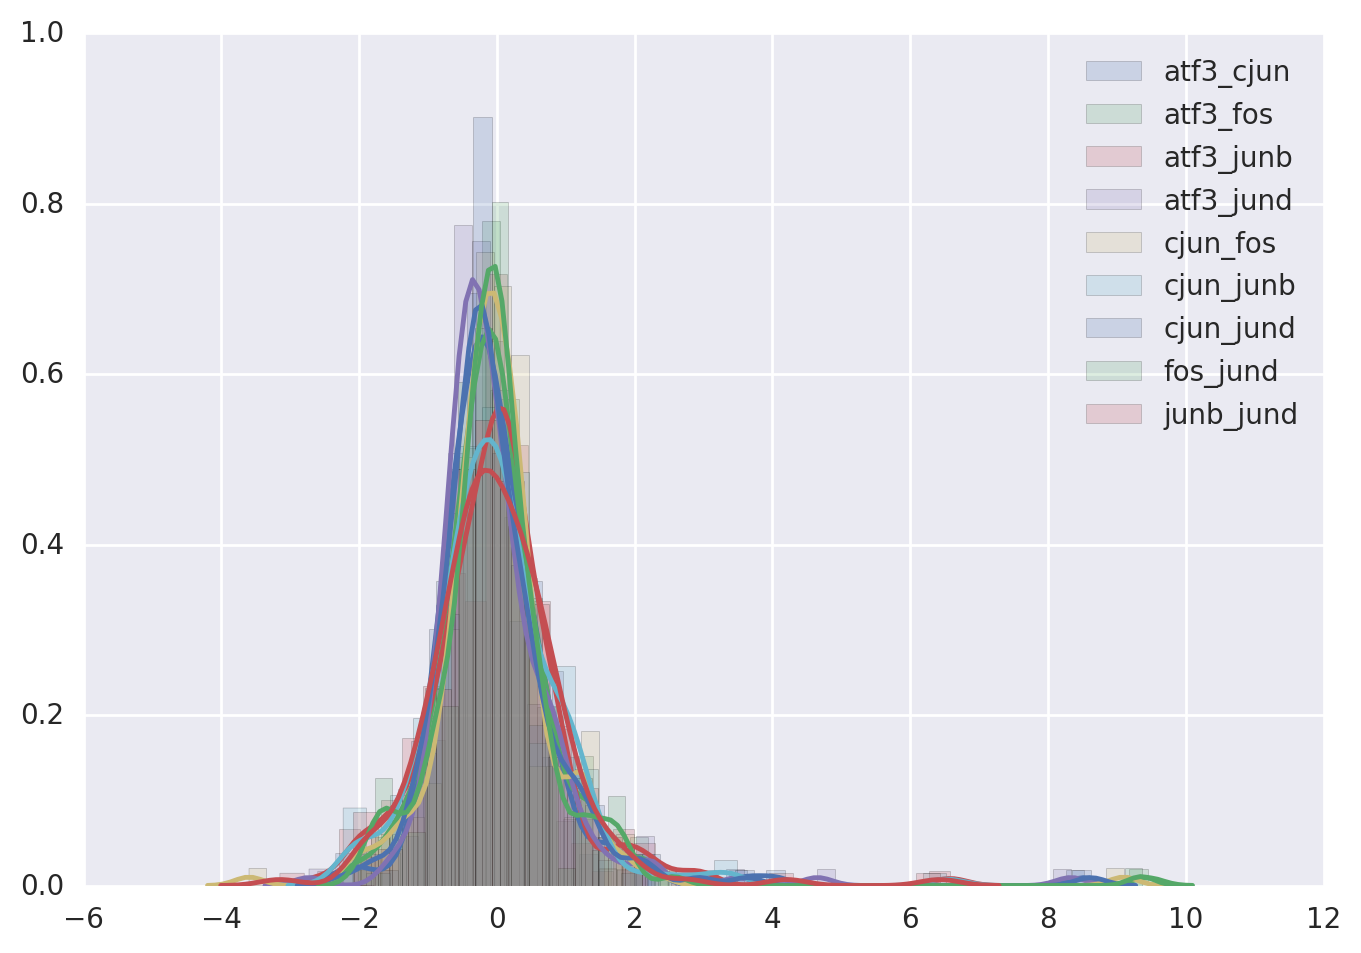

In [739]:
for col in coefficients_standardized_frame_veh_std.columns.values:
    if not '*' in col:
        sns.distplot(coefficients_standardized_frame_veh_std[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


ValueError: negative dimensions are not allowed

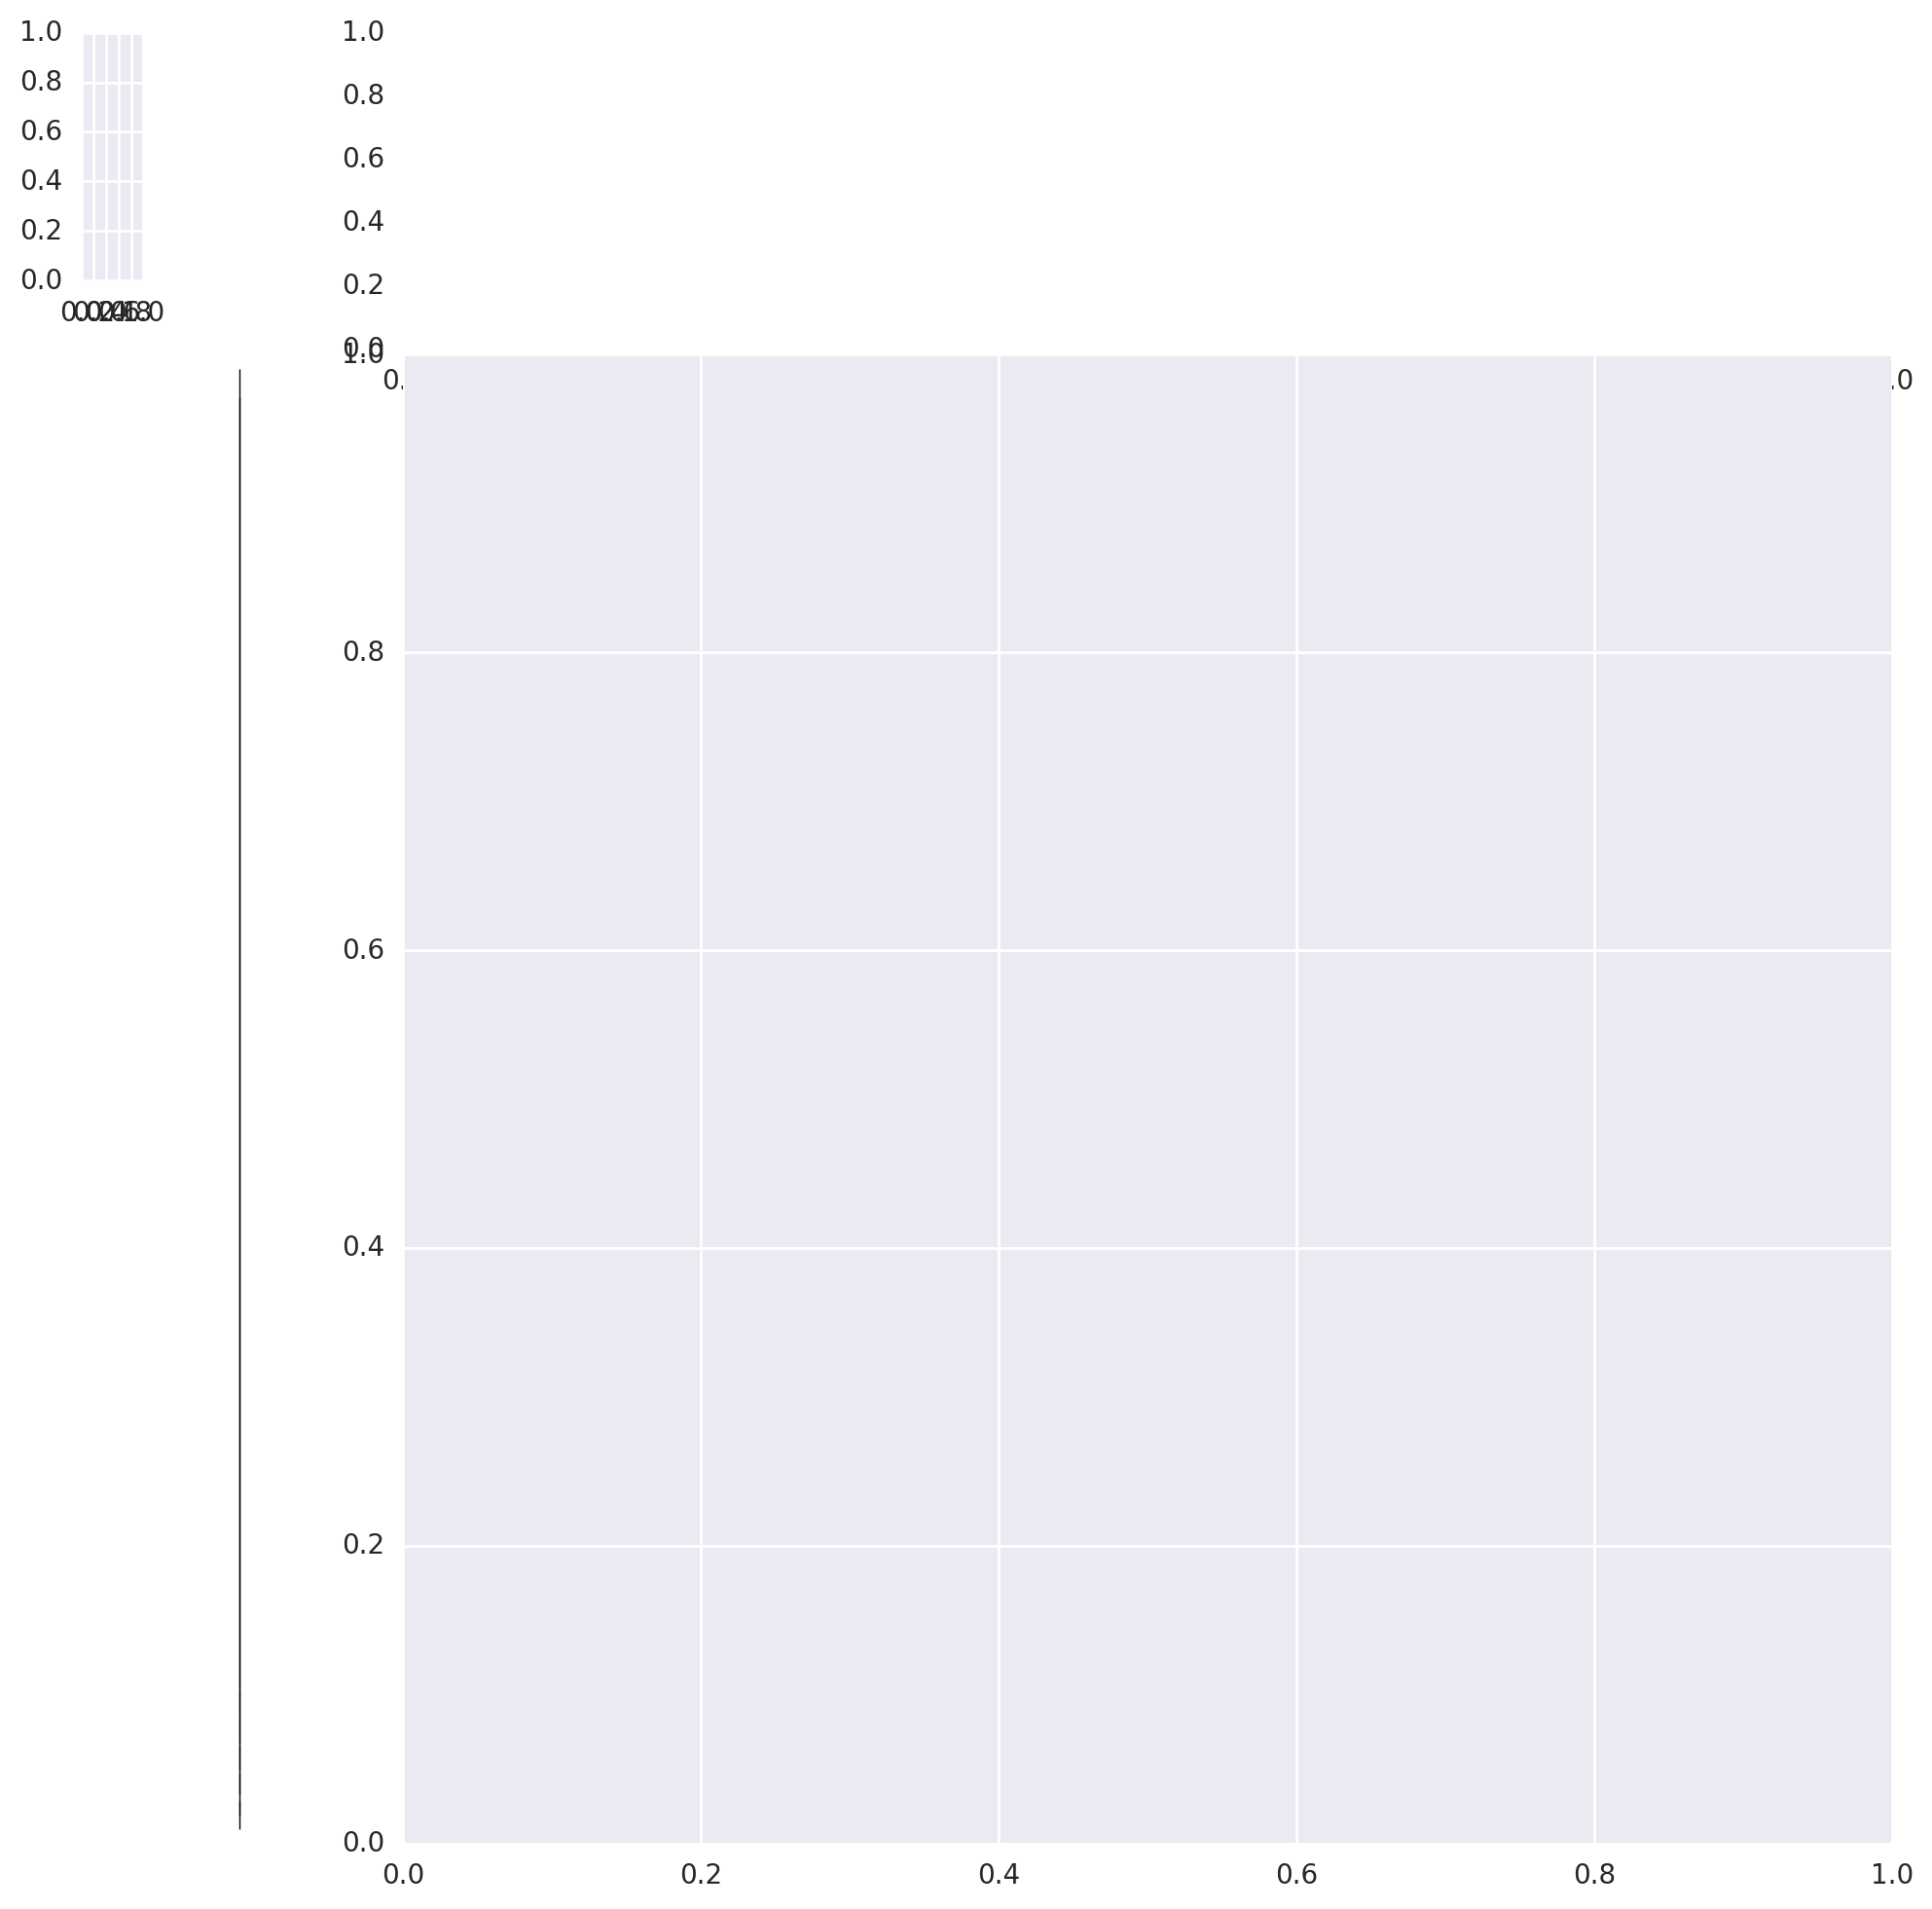

In [655]:
### plot coefficents for vehicle
weight_threshold = 1.5
# data = coefficients_zscore_frame_veh_std
data = coefficients_standardized_frame_veh_std

data = data[(data.max(axis=1) >= weight_threshold) |
            (data.min(axis=1) < -1 * weight_threshold)
            ][[x for x in data.columns if not '_' in x]]

cg = sns.clustermap(data,
                   vmax=1.5*weight_threshold,
                   vmin=-1.5*weight_threshold,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
#                     square=True,
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );



## Weighting Samples

In [249]:

ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  

In [277]:
### for all peaks in vehicle for all motifs
numIterations = 5

factor_auc_dict_unweighted = {}

for factor in ap1_members:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = current_summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l2',
                                                                    max_iter=200,
                                                                    solver='sag',
                                                                    n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retreive probabilities for each classifier
            probas_lr = lr_classifier.predict_proba(test_features)
            # retrieve predictions for each classifier
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)


        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        print(factor, mean_roc_auc, mean_precision)
        factor_auc_dict_unweighted[factor.replace('c57bl6_','')]= mean_roc_auc

atf3 0.804239119442 0.528455468596
cjun 0.786650206576 0.340004039342
fos 0.864986685587 0.320105987579
junb 0.679295928956 0.0170266127394
jund 0.798453778226 0.446184769285


In [326]:
### for all peaks in vehicle for all motifs with weighted samples
numIterations = 5

factor_auc_dict_weighted = {}
current_summary_frame = summary_frame[summary_frame.index.isin(c57bl6_indices)]
current_feature_frame = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
for factor in ap1_members:
    features = current_feature_frame
    labels = current_summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')

    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier
            peak_scores = current_summary_frame[current_summary_frame.index.isin(training_labels.index.values)]['c57bl6_' + factor + '_veh'].values
            max_score = np.max(peak_scores)
            normalized_peak_scores = peak_scores/max_score
            
            normalized_peak_scores = np.array([x if x > 0 else 1 for x in normalized_peak_scores])
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l2', 
                                                                    n_jobs=-1,
                                                                    max_iter=200,
                                                                    solver='sag')

            lr_classifier.fit(training_features, 
                              training_labels,
                             sample_weight=normalized_peak_scores)

            # retreive probabilities for each classifier
            probas_lr = lr_classifier.predict_proba(test_features)
            # retrieve predictions for each classifier
            fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
            current_roc_auc = auc(fpr, tpr)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)


        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        print(factor, mean_roc_auc, mean_precision)
        factor_auc_dict_weighted[factor.replace('c57bl6_','')]= mean_roc_auc

atf3 0.799819713177 0.527810114373
cjun 0.778850069706 0.339690148913
fos 0.858354650554 0.33963879101
junb 0.689114923155 0.0201123774416
jund 0.791120069559 0.445300265049


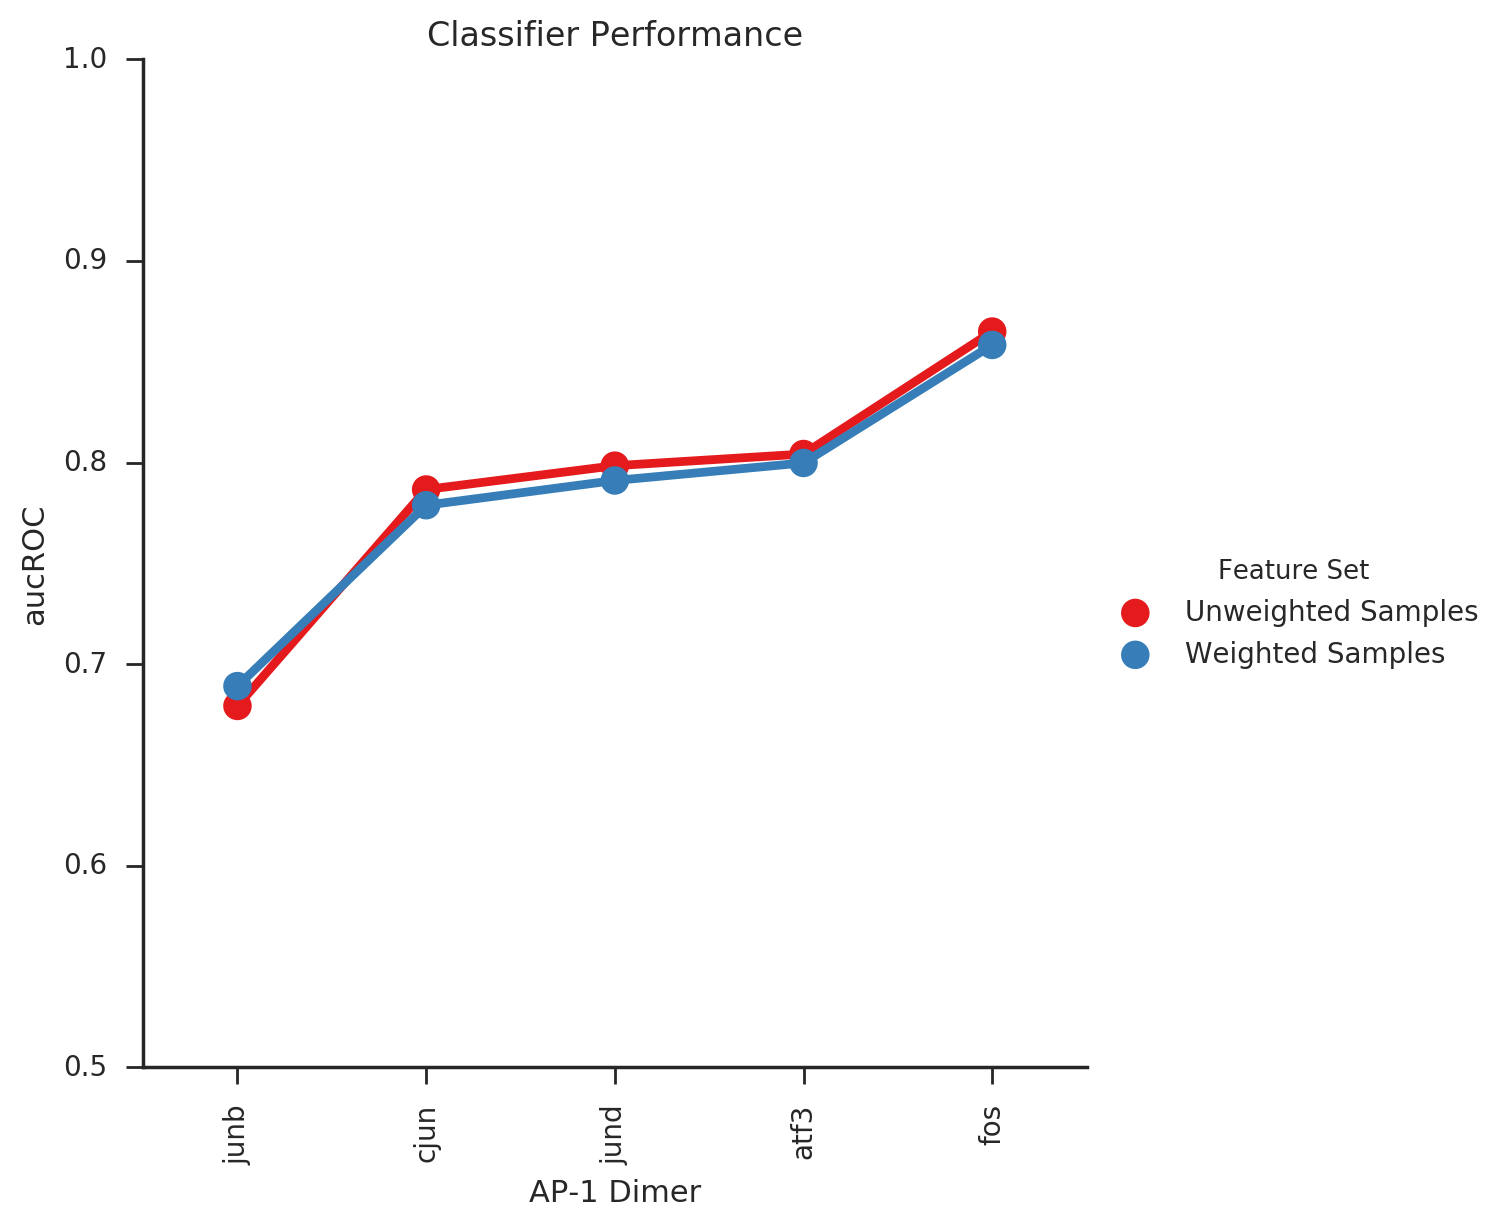

In [327]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_unweighted.keys()):
    factors = factors + 2 * [factor]
    features = features + [ 'Unweighted Samples', 'Weighted Samples']
    aucs.append(factor_auc_dict_unweighted[factor])
    aucs.append(factor_auc_dict_weighted[factor])
   


data = pd.DataFrame({'Factor':factors,
                     'AUC':aucs,
                     'Feature Set':features})

# sort factors according to ascending AUC with all motifs
factor_auc_tuples = tuple(zip(data[data['Feature Set']=='Unweighted Samples']['Factor'], 
                              data[data['Feature Set']=='Unweighted Samples']['AUC']))

sorted_factors = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]

with sns.axes_style('ticks'):
    plottingFrame = sns.factorplot(data = data,
                                x='Factor',
                                y='AUC',
                                order = sorted_factors,
                                hue='Feature Set',
                                palette='Set1',
                                size=6)

    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
    plt.ylim(0.5,1)
    plt.title('Classifier Performance')
    

## AdaBoost

In [306]:
### for all peaks in vehicle for all motifs
numIterations = 1

factor_auc_dict_adaboost = {}

for factor in ap1_members:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = current_summary_frame['Factors'].str.contains('c57bl6_' + factor + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_precisions = []
        for i in range(numIterations):    
            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = 0.5, tolerance = 0.01)

            #  Run classifier

#             adaboost_classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=100,
#                                     base_estimator = sklearn.tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
#                                     max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
#                                     min_samples_split=2, min_weight_fraction_leaf=0.0,
#                                     presort=False, random_state=None, splitter='best')
#                                                                      )
#             adaboost_classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=100,
#                                     base_estimator = sklearn.linear_model.LogisticRegression(penalty='l2', 
#                                                                                             n_jobs=-1,
#                                                                                             max_iter=200,
#                                                                                             solver='sag')
#                                                                      )
            adaboost_classifier = sklearn.ensemble.AdaBoostClassifier(n_estimators=100) 
            adaboost_classifier.fit(training_features, training_labels)
            # retreive probabilities for each classifier
            probas = adaboost_classifier.predict_proba(test_features)
            
            # retrieve predictions for each classifier
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels, probas[:, 1])
            current_roc_auc = auc(fpr, tpr)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas[:, 1], average = None)

            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)
            
            # score all sequences
            probs = adaboost_classifier.predict_proba(features)[:, 1]

#             current_coefficients = adaboost_classifier.coef_.flatten()
#             all_coeficients.append(current_coefficients)


        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        print(factor, mean_roc_auc, mean_precision)
        factor_auc_dict_adaboost[factor.replace('c57bl6_','')]= mean_roc_auc

atf3 0.795656069855 0.512936035422
cjun 0.773712590269 0.321027786025
fos 0.846352638464 0.279364877681
junb 0.666386254948 0.0148902054031
jund 0.784787538889 0.433562144431


## Label vs Prediction Comparison 

In [477]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [ ]:
### for all dimers in vehicle for all motifs
numIterations = 1
factor_coeff_dict = {}
factor_auc_dict_veh = {}
factor_prob_dict_veh = {}
factor_classifier_dict_veh = {}
for factorPair in factorPairs:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[0] + '_veh') & \
             summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factorPair[1] + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_coeficients = []
        all_precisions = []
        all_probs = None
        
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)
            
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)

            man_score = np.sum(current_coefficients * test_features.ix[0,:]) + lr_classifier.intercept_
            classifier_score = lr_classifier.decision_function(test_features.ix[0,:])
            print(monomer, man_score, classifier_score, test_labels[0])
            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        all_probs = all_probs/numIterations
        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

        factor_auc_dict_veh['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
        factor_coeff_dict['_'.join(factorPair).replace('c57bl6_','')] = mean_coefficients
        factor_prob_dict_veh['_'.join(factorPair).replace('c57bl6_','')] = all_probs
        print('_'.join(factorPair).replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision, 
              'numTestPositives:', np.sum(test_labels)
             )

In [485]:
# for monomers
for monomer in ap1_members:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(monomer + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_coeficients = []
        all_probs = None
        all_precisions = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)
            
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
        all_probs = all_probs/numIterations
        mean_roc_auc = np.mean(all_aucs) # average aucROC
        mean_precision = np.mean(all_precisions)
        mean_coefficients = np.mean(all_coeficients, axis=0) # average coefficients 

        factor_auc_dict_veh[monomer.replace('c57bl6_','')]= mean_roc_auc
        factor_coeff_dict[monomer.replace('c57bl6_','')] = mean_coefficients
        factor_prob_dict_veh[monomer.replace('c57bl6_','')] = all_probs
        print(monomer.replace('c57bl6_',''),
              'roc:', mean_roc_auc, 
              'precision:', mean_precision, 
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:36: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3 roc: 0.80383217262 precision: 0.530506701891 numTestPositives: 10975
cjun roc: 0.792093639868 precision: 0.501161902958 numTestPositives: 10492
fos roc: 0.825401767027 precision: 0.319753090717 numTestPositives: 2011
junb roc: 0.757304392728 precision: 0.0656161147203 numTestPositives: 976
jund roc: 0.803987829072 precision: 0.631666593392 numTestPositives: 14870


In [511]:
coefficients_frame_veh_std = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_std.index = standardized_motif_frame.columns.values
probs_frame_veh_std = pd.DataFrame(factor_prob_dict_veh,
index = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)].index.values)



In [551]:
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame_veh_std = pd.DataFrame(scaler.fit_transform(coefficients_frame_veh_std))
coefficients_standardized_frame_veh_std.index = coefficients_frame_veh_std.index.values
coefficients_standardized_frame_veh_std.columns = coefficients_frame_veh_std.columns.values

atf3_cjun FP 22168 FN 3292 TP 11060
atf3_cjun LR+ 2.6608578149748934 LR- 0.06054252873563218 TPR 0.7706243032329989 FNR 0.04300850502332022


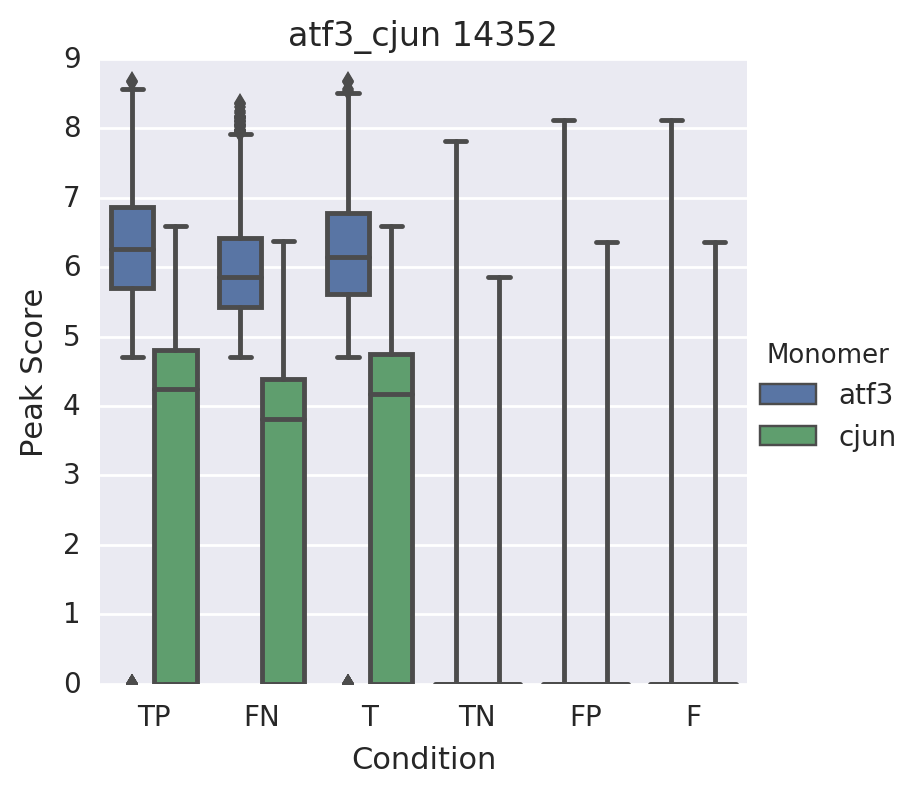

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


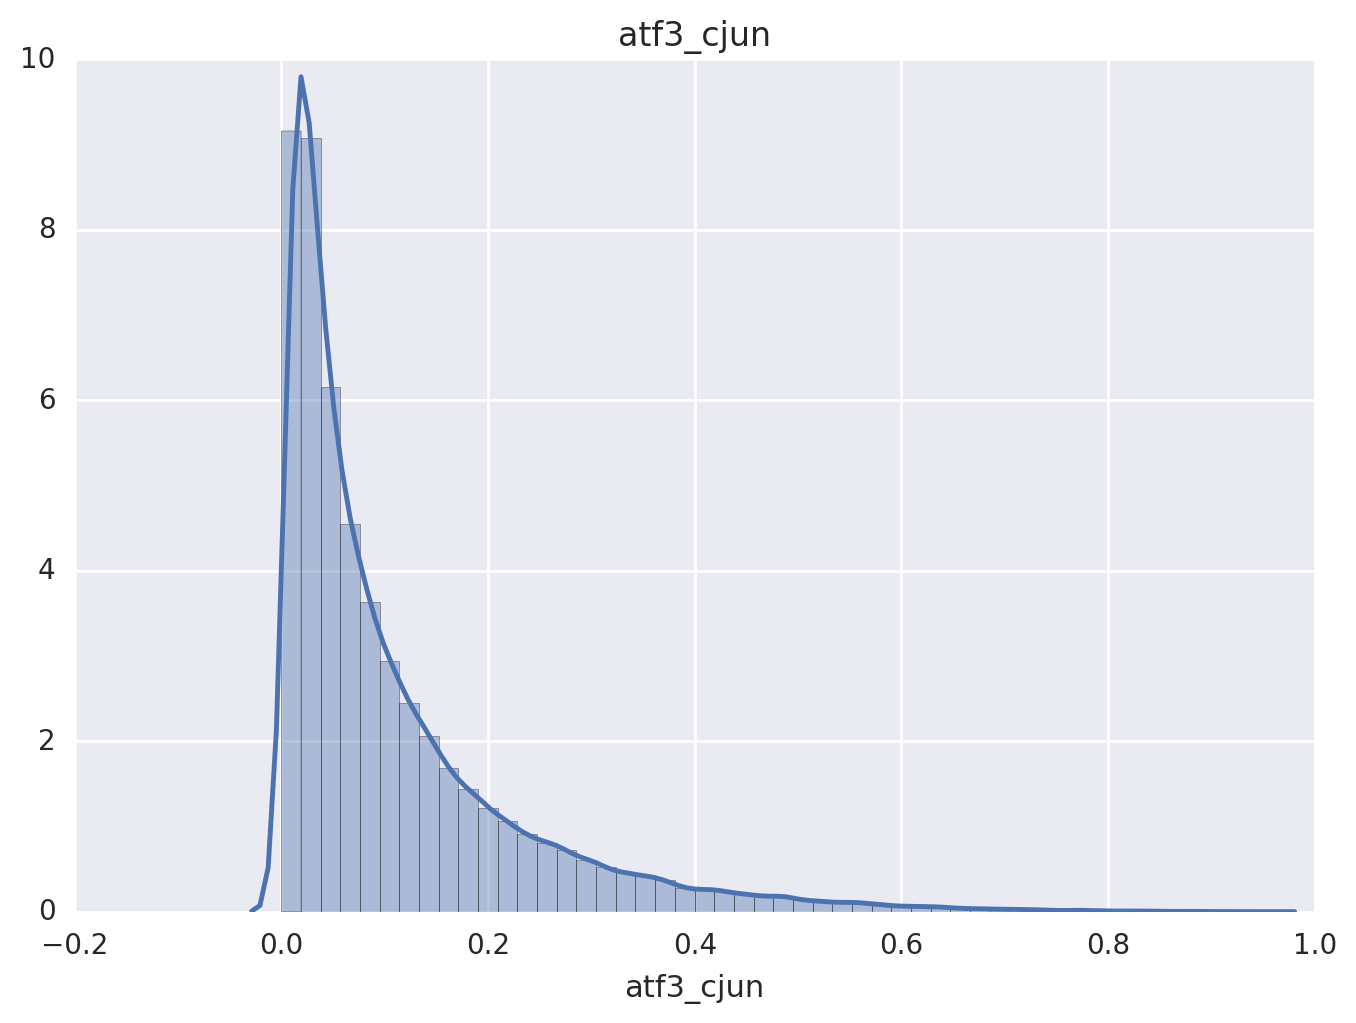

atf3_fos FP 3925 FN 1617 TP 765
atf3_fos LR+ 7.242476214924033 LR- 0.019116186693147963 TPR 0.3211586901763224 FNR 0.018268502931772734


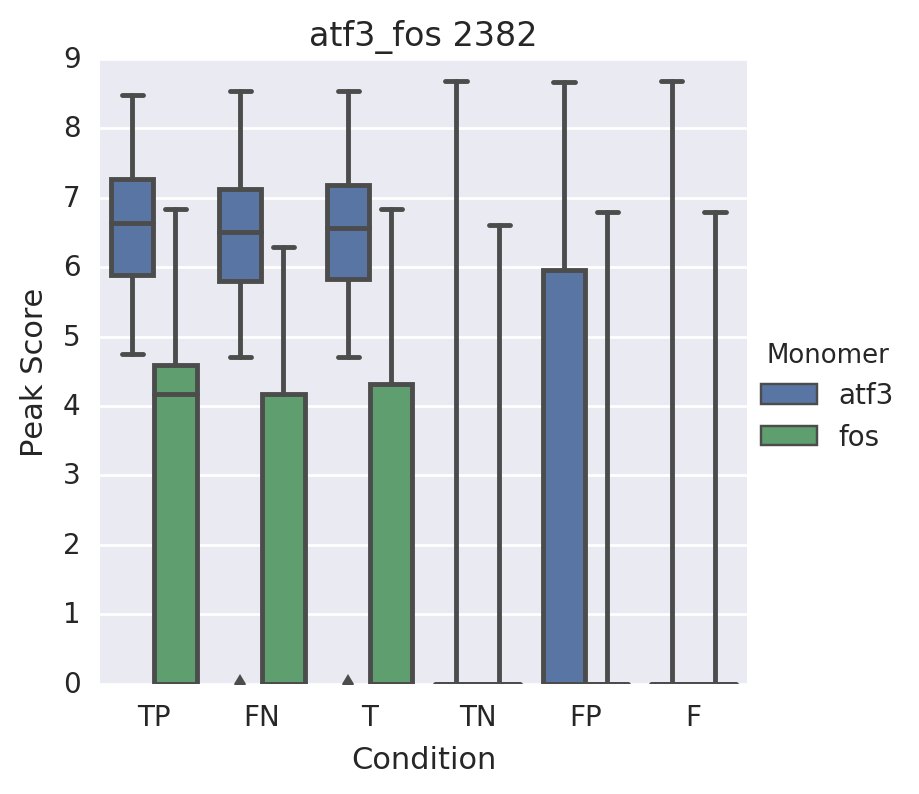

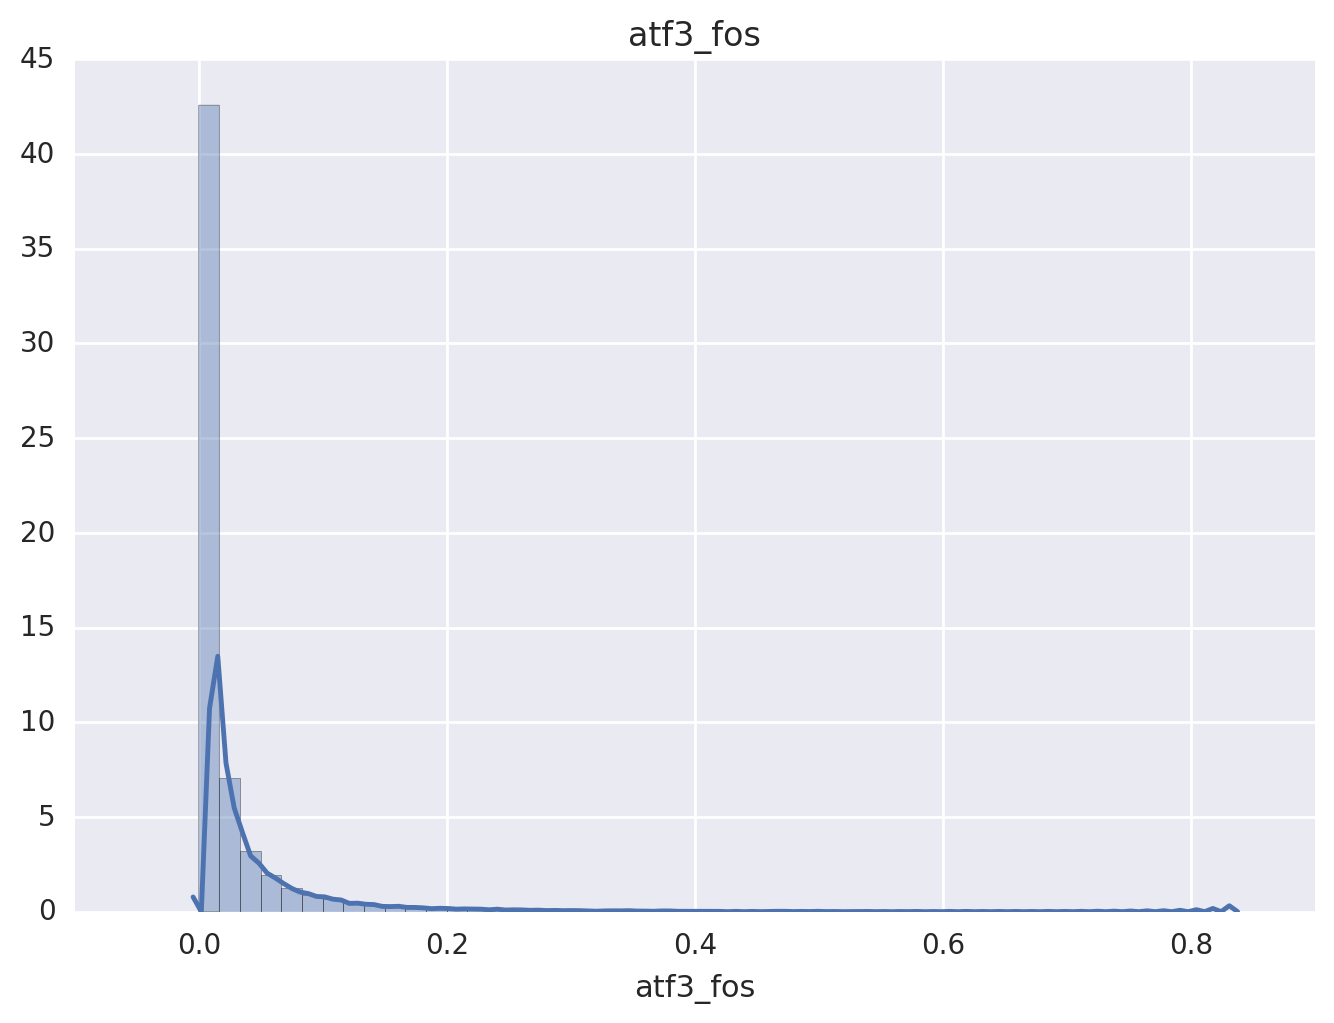

atf3_junb FP 287 FN 1333 TP 50
atf3_junb LR+ 11.275795435363712 LR- 0.014939759036144579 TPR 0.036153289949385395 FNR 0.014891858074894987


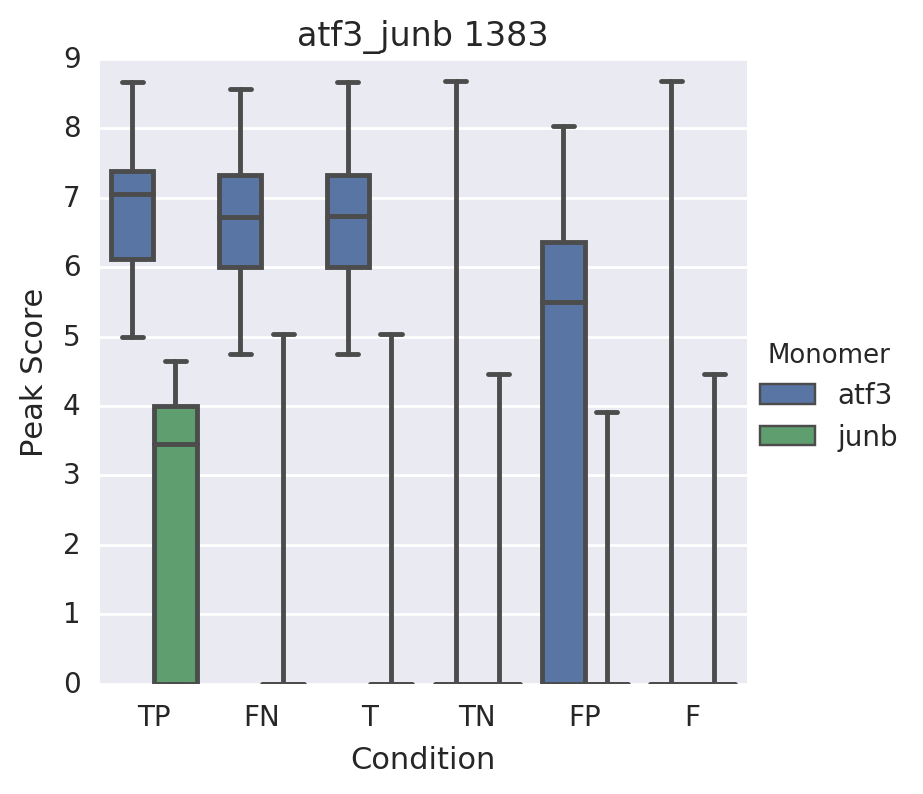

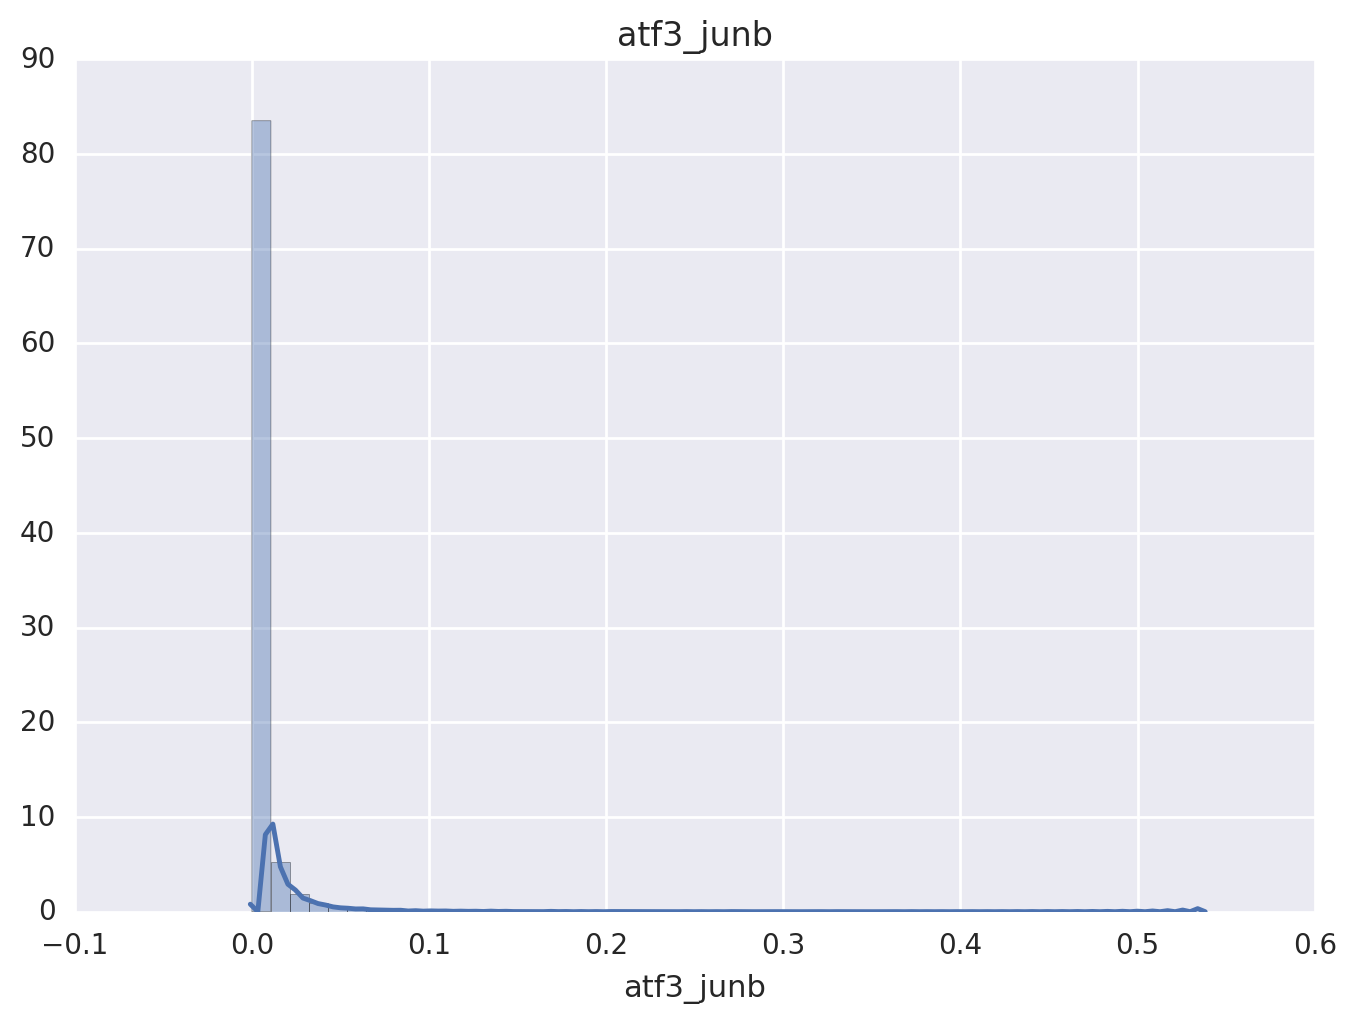

atf3_jund FP 30379 FN 2000 TP 15744
atf3_jund LR+ 2.136536644022075 LR- 0.04675956233049659 TPR 0.8872858431018936 FNR 0.027340706210441417


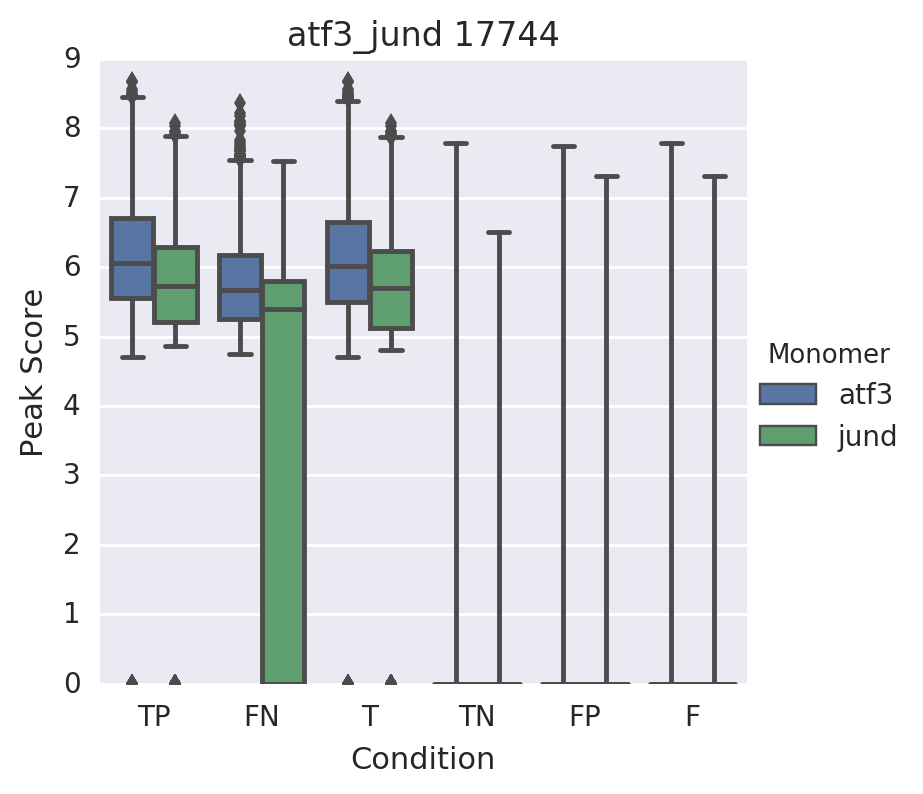

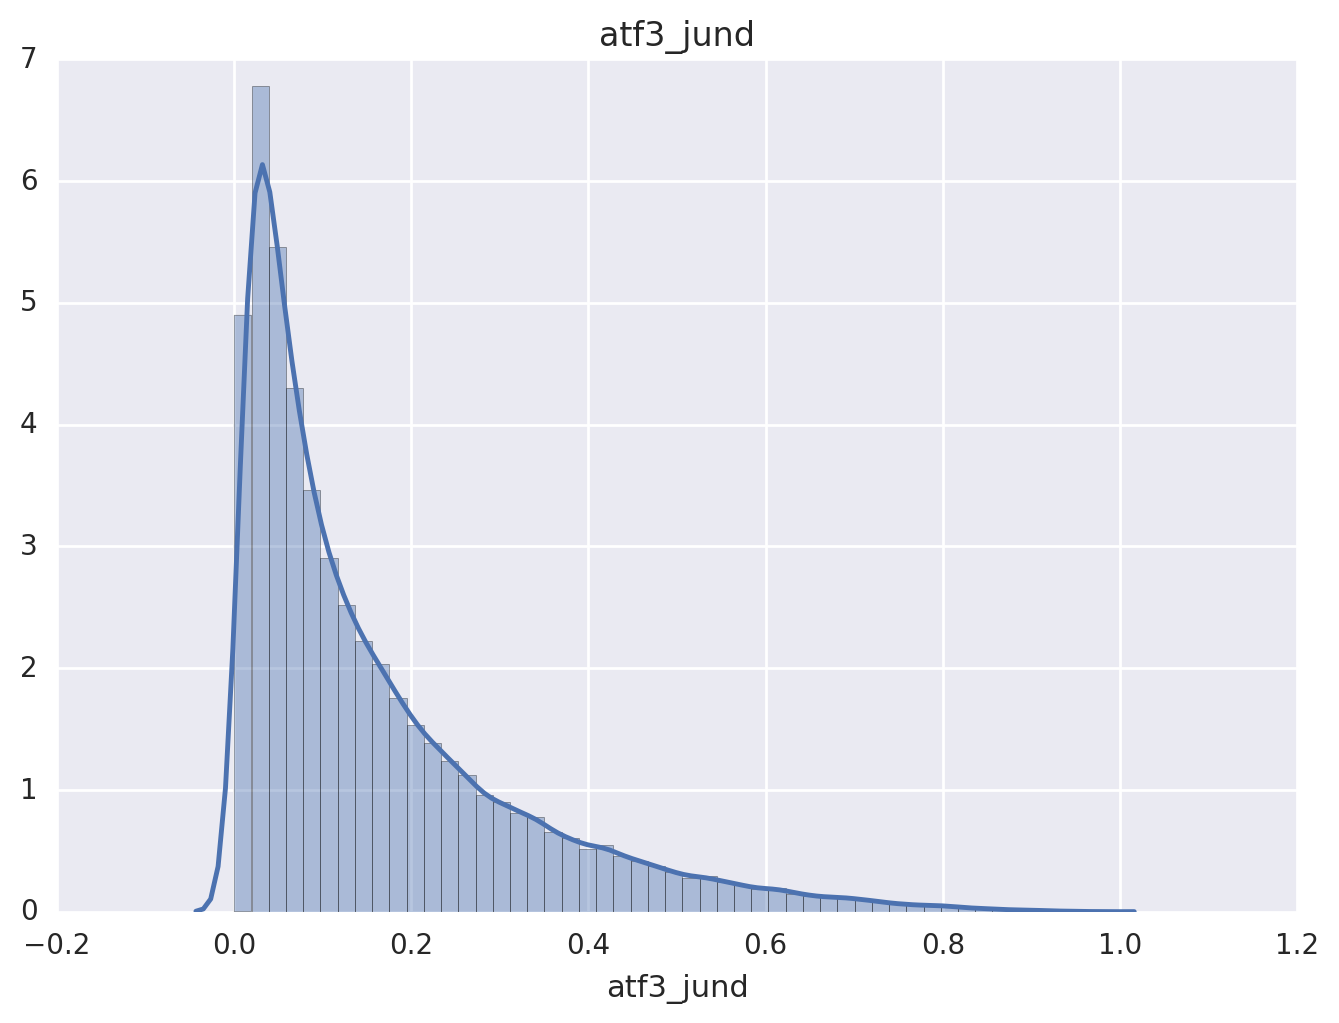

cjun_fos FP 2571 FN 1841 TP 593
cjun_fos LR+ 8.382699294034627 LR- 0.02143439282803586 TPR 0.24363188167625308 FNR 0.020811431026101897


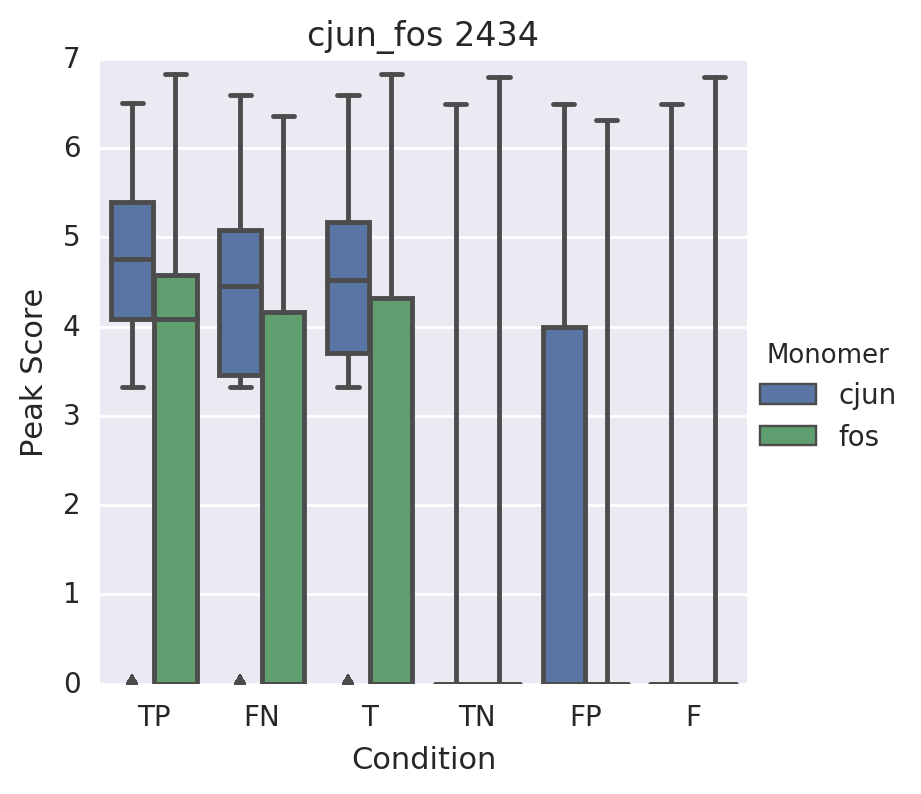

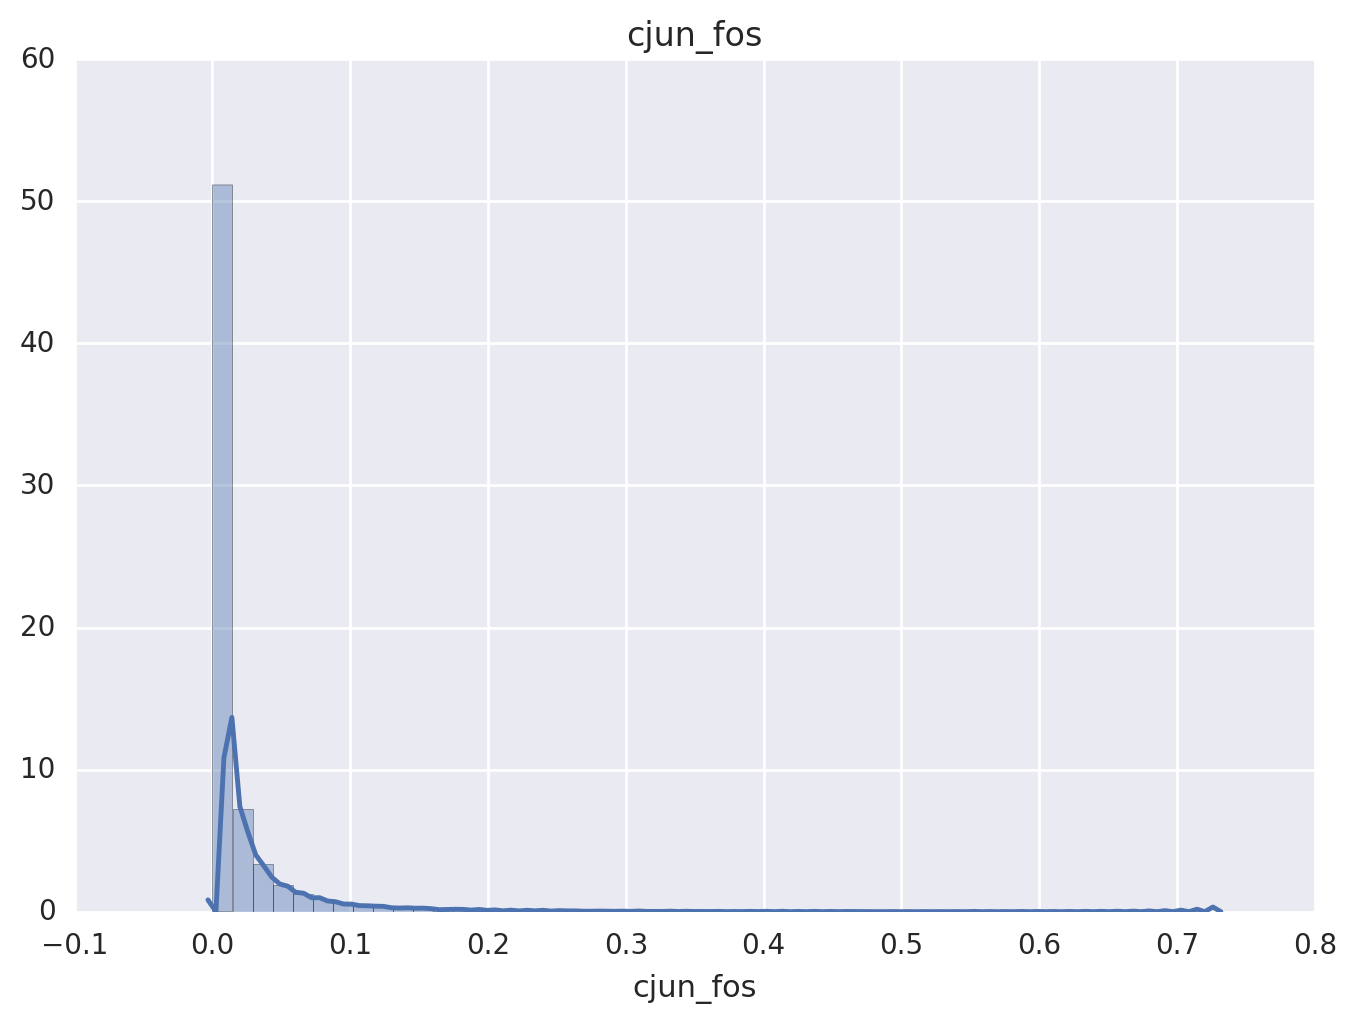

cjun_junb FP 224 FN 1370 TP 37
cjun_junb LR+ 10.505685856432125 LR- 0.015347732568560674 TPR 0.026297085998578537 FNR 0.01530931521544788


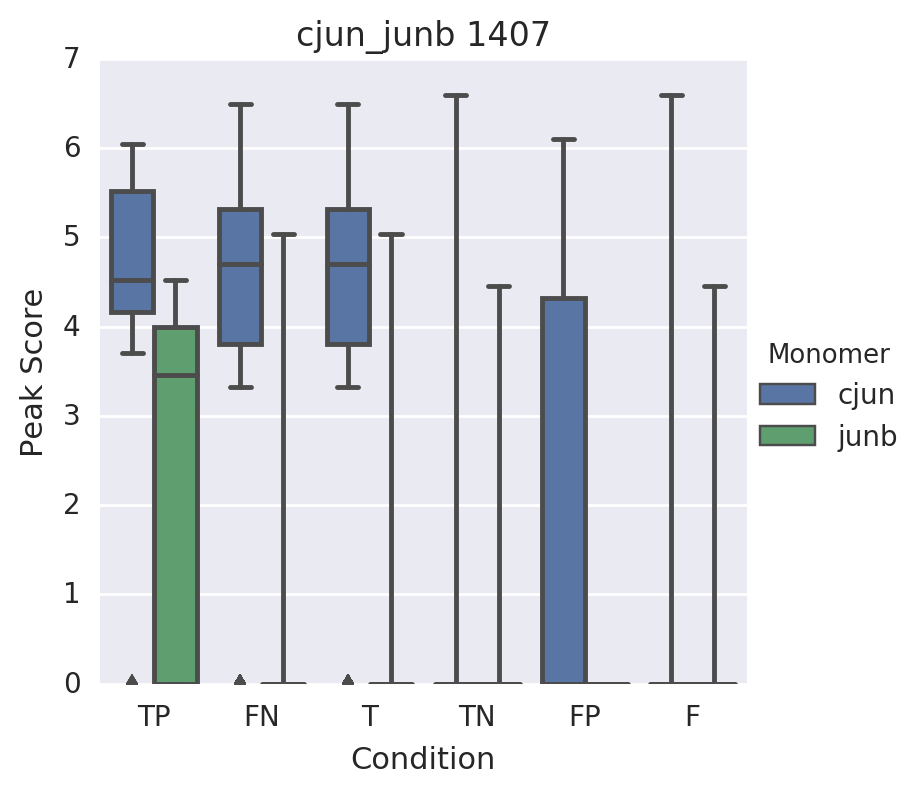

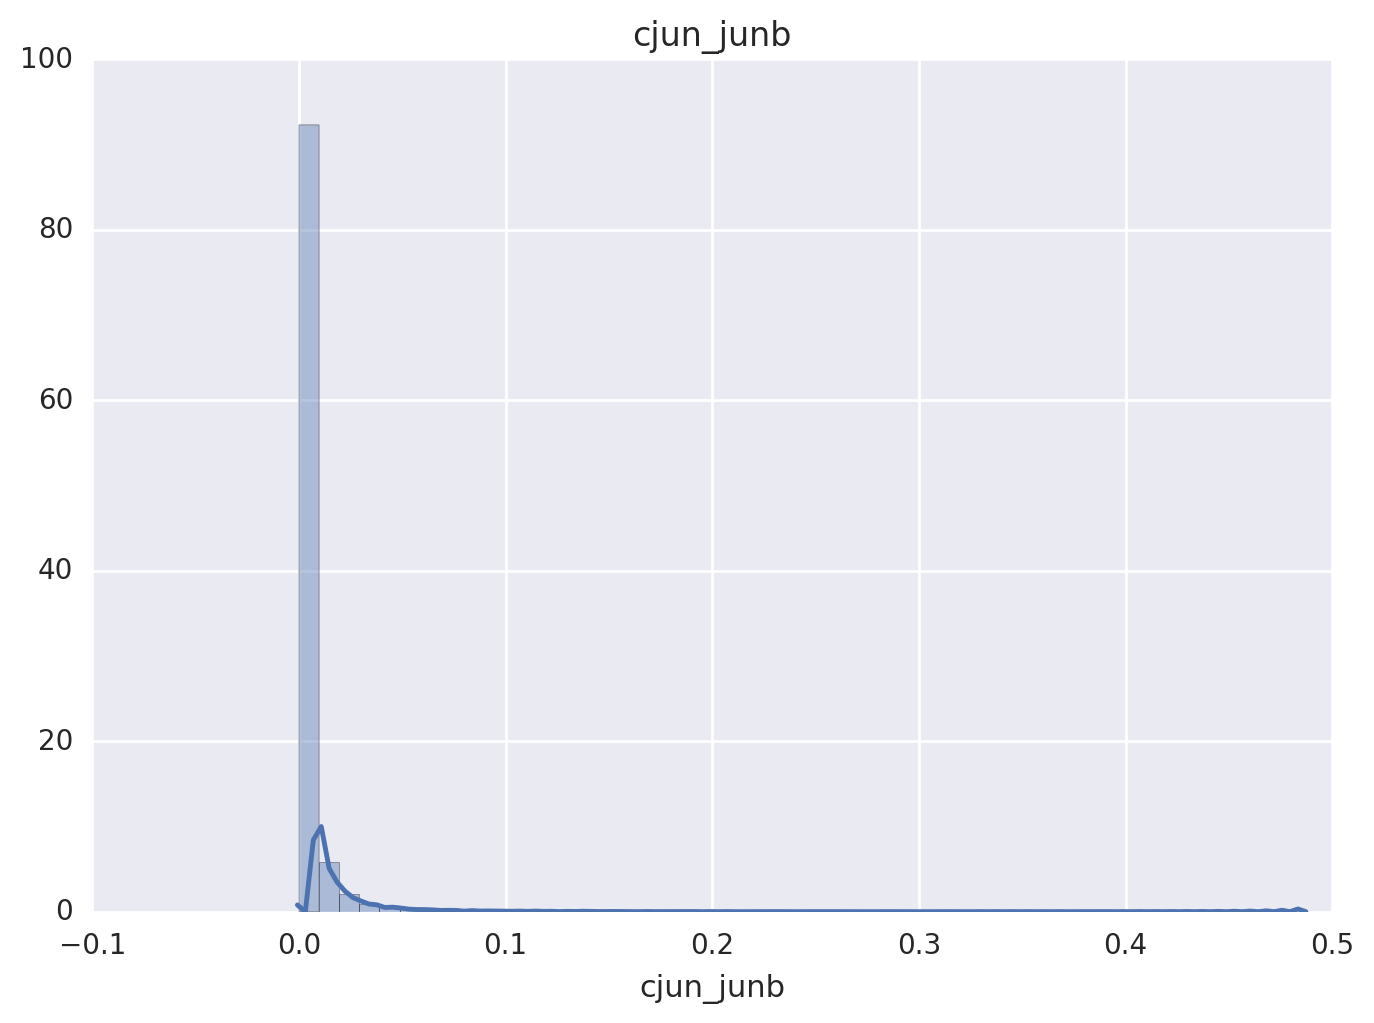

cjun_jund FP 19218 FN 4613 TP 12130
cjun_jund LR+ 2.7953886902016234 LR- 0.08397349546728802 TPR 0.7244818730215612 FNR 0.06221005502211673


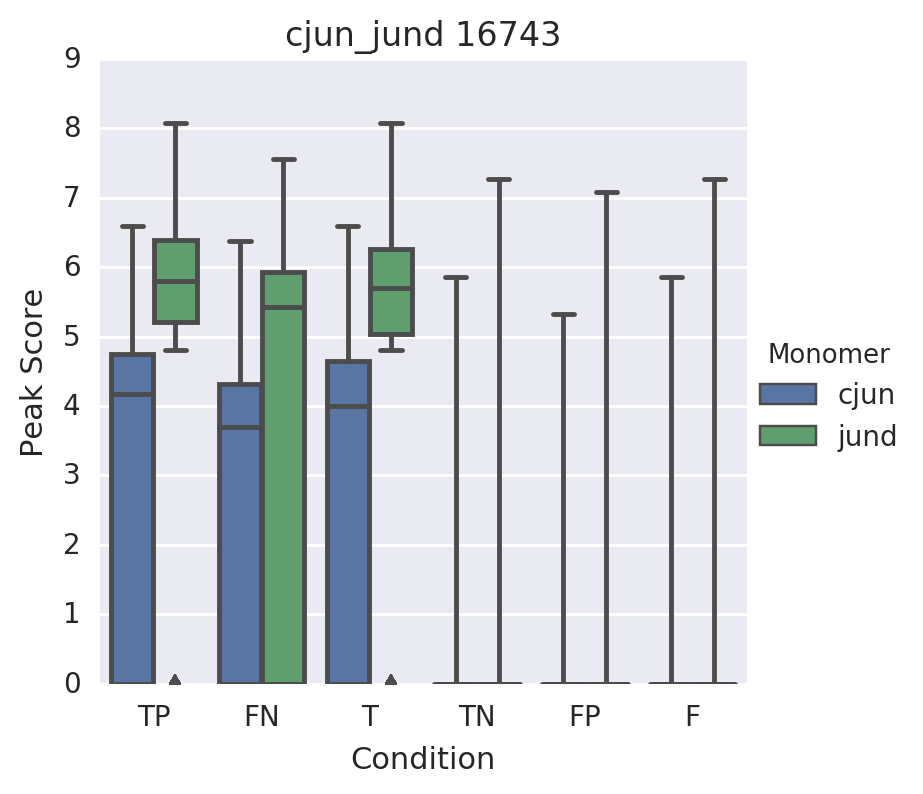

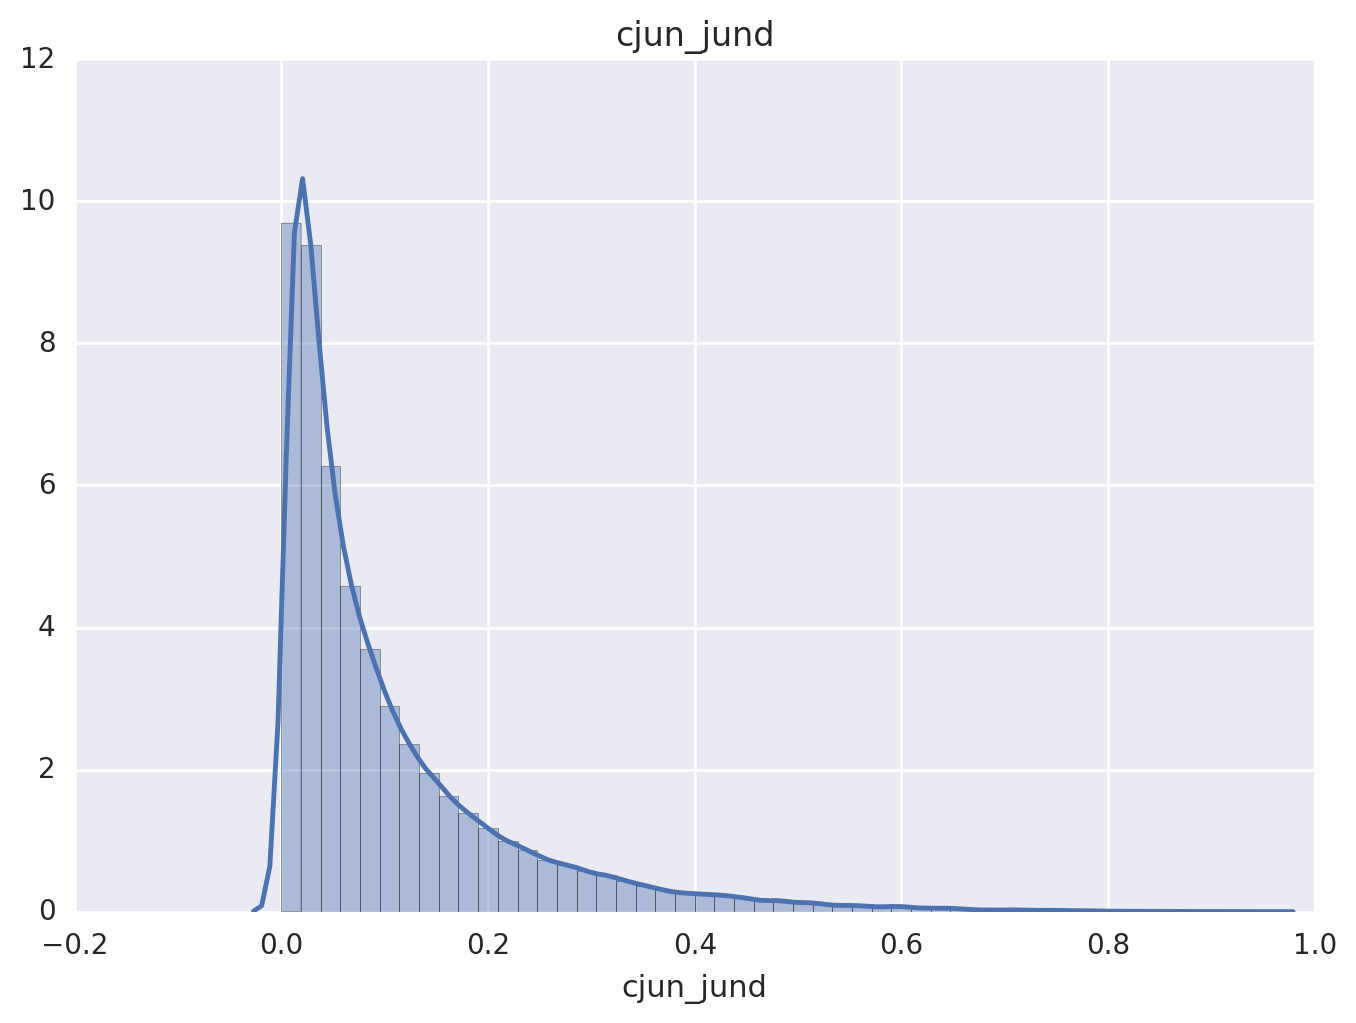

fos_jund FP 3707 FN 1962 TP 821
fos_jund LR+ 7.012008338809146 LR- 0.023245068420117292 TPR 0.29500538986704994 FNR 0.022267114581441802


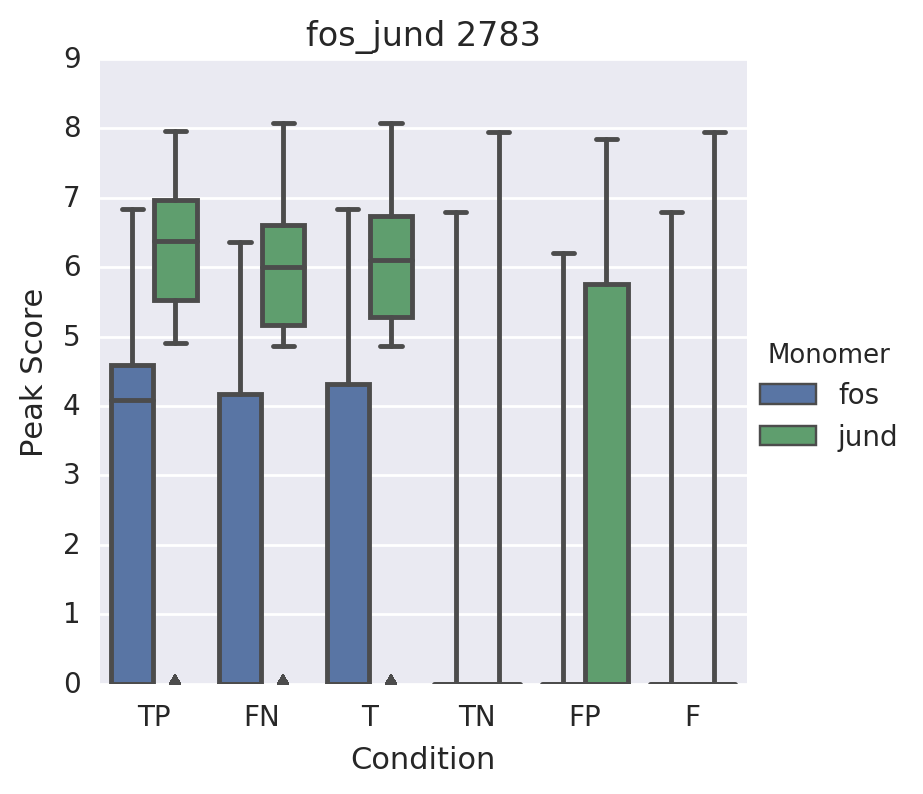

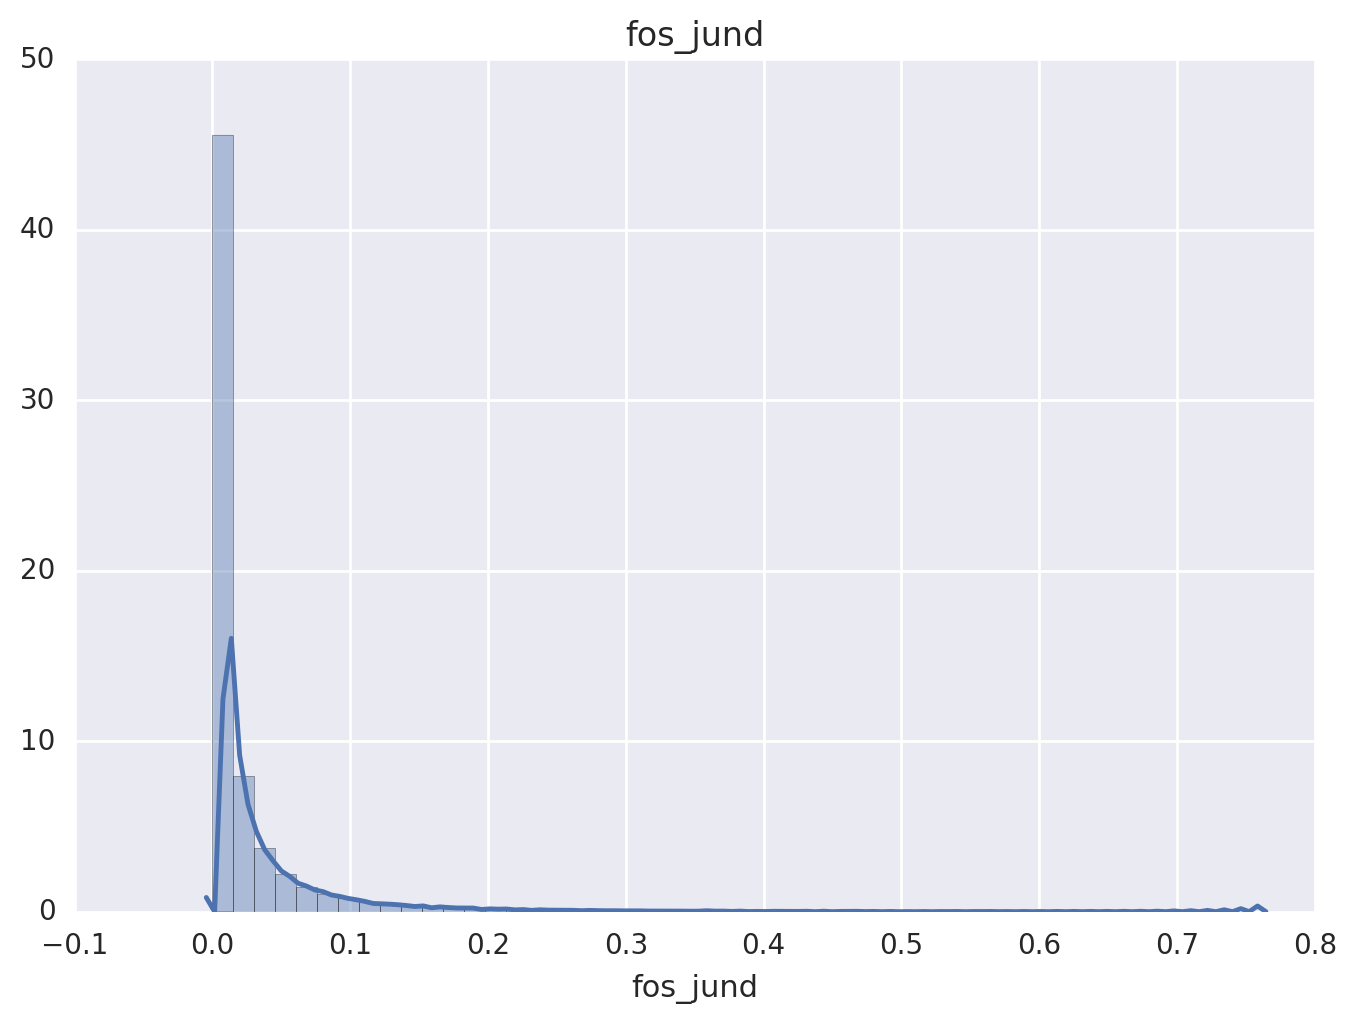

junb_jund FP 359 FN 1445 TP 62
junb_jund LR+ 10.24384996293989 LR- 0.016230666412067978 TPR 0.0411413404114134 FNR 0.016165480825166688


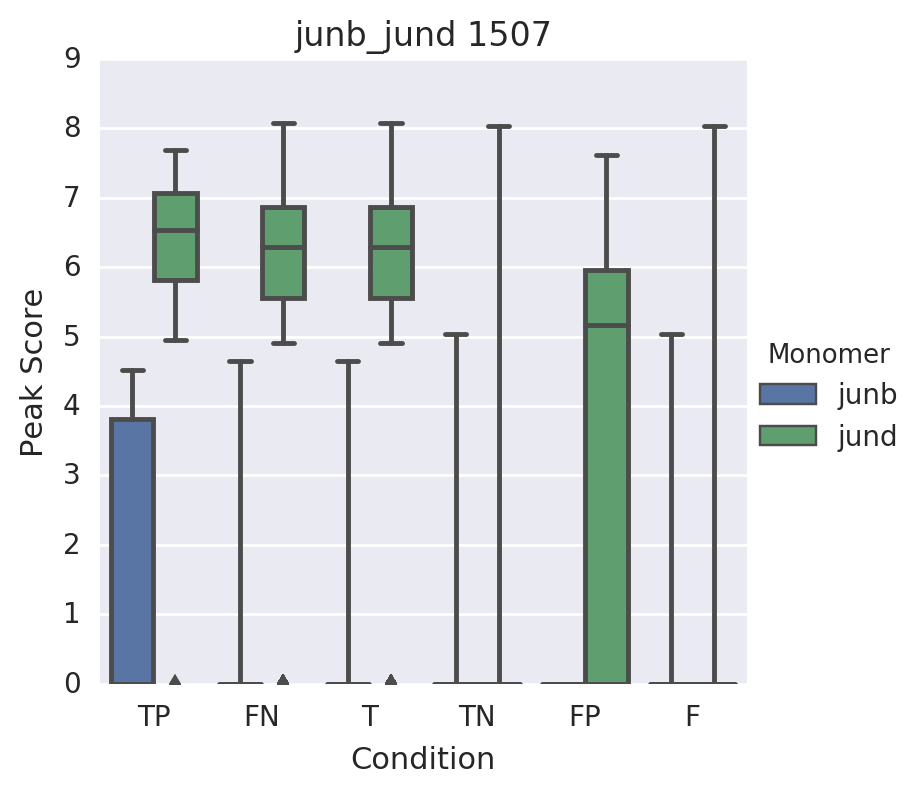

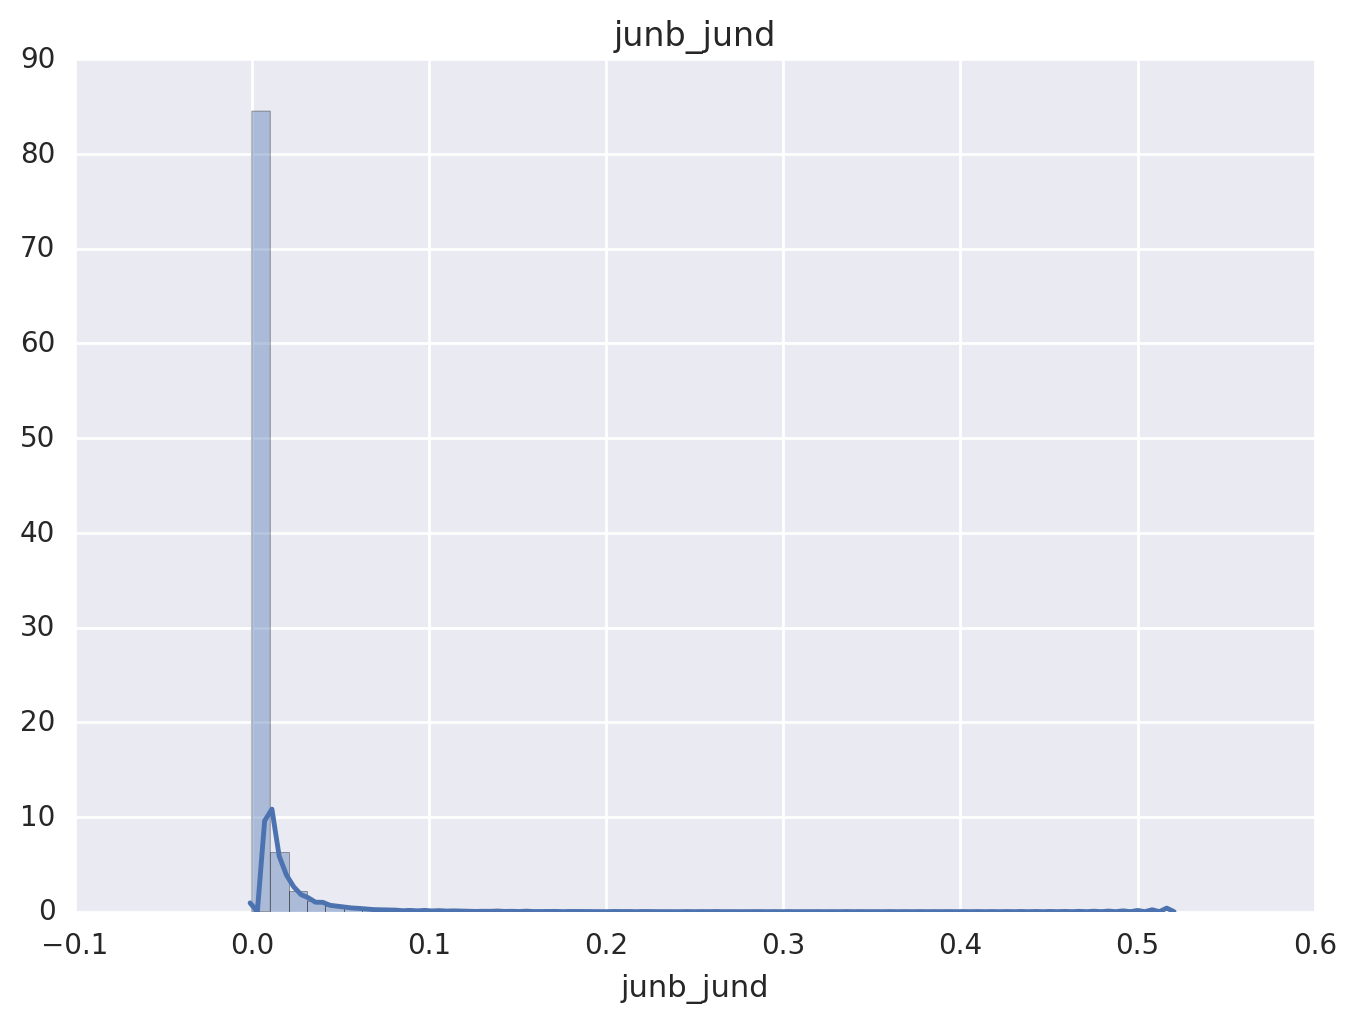

In [476]:
prob_threshold = 0.1
strain = 'c57bl6'
treatment = 'veh'
for dimer in probs_frame_veh_std.columns.values:
    # determine labels for: 1) True Positive, 2) False Negative, 3) True, 
    #                       4) True Negative, 3) False Positive, 4) False
    
    # determine monomers
    tokens = dimer.split('_')
    m1 = tokens[0]
    m2 = tokens[1]
    
    true_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(m1 + '_' + treatment) & \
                  summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(m2 + '_' + treatment)
    
    probs = probs_frame_veh_std[dimer]
#     prob_ranks = pd.Series(scipy.stats.rankdata(probs), index = probs_frame_veh.index.values)
#     prob_ranks = prob_ranks / np.max(prob_ranks)
    
    predicted_labels = probs_frame_veh_std[dimer] > prob_threshold
#     predicted_labels = prob_ranks > prob_threshold
    
    index_labels_tuples = list(zip(true_labels.index.values, # index
                                   true_labels.values,       # true label
                                   predicted_labels.values)) # predicted label
    TP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == True ])
    FN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == False ])
    T_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True])
    
    TN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == False ])
    FP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == True ])
    F_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False ])
    
    # visualize peak scores
    if min([len(TP_indices), len(FN_indices), len(T_indices),
            len(TN_indices), len(FP_indices), len(F_indices)]) >0:
        m1_TP_scores = summary_frame[summary_frame.index.isin(TP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FN_scores = summary_frame[summary_frame.index.isin(FN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_T_scores = summary_frame[summary_frame.index.isin(T_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_TN_scores = summary_frame[summary_frame.index.isin(TN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FP_scores = summary_frame[summary_frame.index.isin(FP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_F_scores = summary_frame[summary_frame.index.isin(F_indices)][strain + '_' + m1 + '_' + treatment].values

        m2_TP_scores = summary_frame[summary_frame.index.isin(TP_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_FN_scores = summary_frame[summary_frame.index.isin(FN_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_T_scores = summary_frame[summary_frame.index.isin(T_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_TN_scores = summary_frame[summary_frame.index.isin(TN_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_FP_scores = summary_frame[summary_frame.index.isin(FP_indices)][strain + '_' + m2 + '_' + treatment].values
        m2_F_scores = summary_frame[summary_frame.index.isin(F_indices)][strain + '_' + m2 + '_' + treatment].values
    
        scores = np.concatenate([m1_TP_scores, m1_FN_scores, m1_T_scores, m1_TN_scores, m1_FP_scores, m1_F_scores,
                                 m2_TP_scores, m2_FN_scores, m2_T_scores, m2_TN_scores, m2_FP_scores, m2_F_scores])
        numIndices = np.sum([len(TP_indices), len(FN_indices), len(T_indices),
                             len(TN_indices), len(FP_indices), len(F_indices)])
        monomers = ([m1] * numIndices )+ ([m2] * numIndices)
        conditions = np.concatenate([len(m1_TP_scores) * ['TP'], 
                                     len(m1_FN_scores) * ['FN'],
                                     len(m1_T_scores) * ['T'], 
                                     len(m1_TN_scores) * ['TN'], 
                                     len(m1_FP_scores) * ['FP'], 
                                     len(m1_F_scores) * ['F'],
                                     len(m2_TP_scores) * ['TP'], 
                                     len(m2_FN_scores) * ['FN'], 
                                     len(m2_T_scores) * ['T'], 
                                     len(m2_TN_scores) * ['TN'], 
                                     len(m2_FP_scores) * ['FP'], 
                                     len(m2_F_scores) * ['F']])
        print(dimer, 'FP', len(FP_indices), 'FN', len(FN_indices), 'TP', len(TP_indices))
        fpr = len(FP_indices)/len(F_indices)
        tpr = len(TP_indices)/len(T_indices)
        
        fnr = len(FN_indices)/len(F_indices)
        tnr = len(TN_indices)/len(F_indices)
        print(dimer, 'LR+',str(tpr/fpr), 'LR-',str(fnr/tnr), 'TPR', tpr, 'FNR', fnr)
        data = pd.DataFrame({'Peak Score': np.log2(scores+1), 'Monomer':monomers, 'Condition':conditions})
        sns.factorplot(data = data, kind='box', y='Peak Score', x = 'Condition', hue = 'Monomer')
        plt.title(dimer + ' '+ str(np.sum(true_labels)))
        plt.show()
        
        sns.distplot(probs_frame_veh[dimer])
        plt.title(dimer)
        plt.show()


atf3 FP 5018 FN 14856 TP 7172
junb_jund LR+ 4.468334949330404 LR- 0.2326739651364939 TPR 0.32558561830397675 FNR 0.2157201562431934
7172 14856 22028 63849 5018 68867


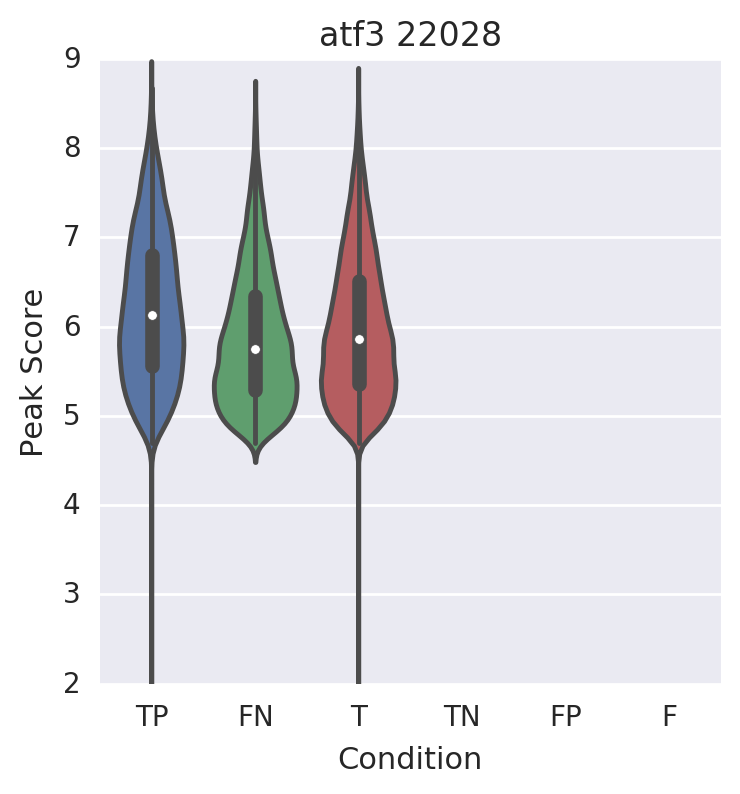

cjun FP 4260 FN 15195 TP 5926
junb_jund LR+ 4.595483301780285 LR- 0.2319351588973349 TPR 0.2805738364660764 FNR 0.21777452919425574
5926 15195 21121 65514 4260 69774


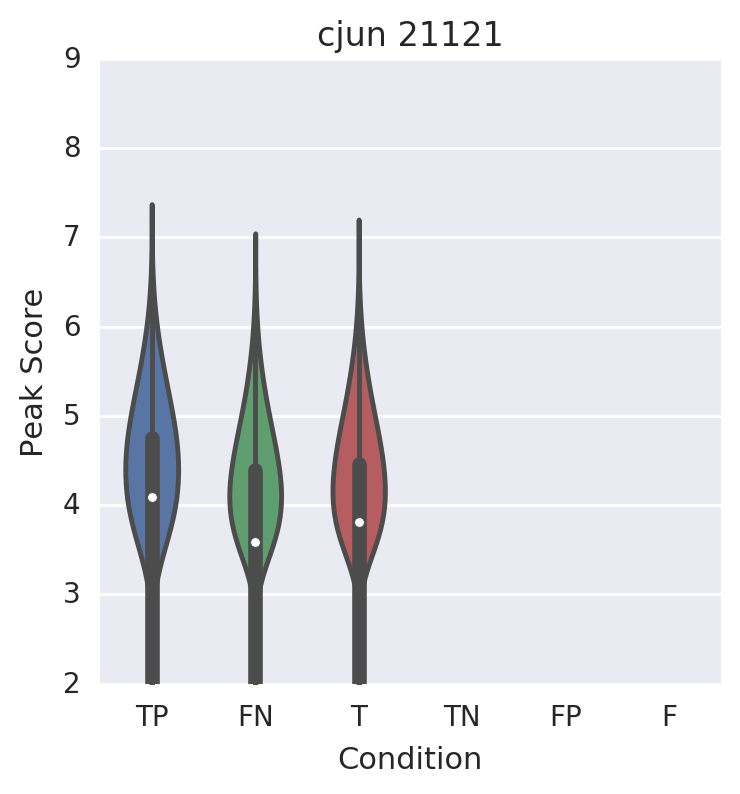

fos FP 658 FN 3536 TP 492
junb_jund LR+ 16.125179971204606 LR- 0.04101659919497964 TPR 0.1221449851042701 FNR 0.04070590673097954
492 3536 4028 86209 658 86867


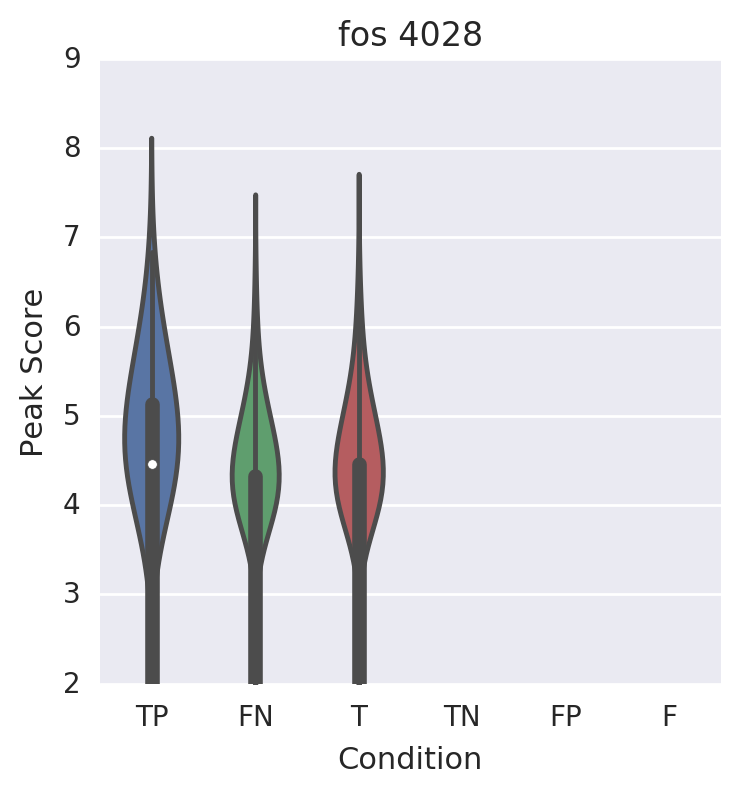

junb FP 1 FN 1963 TP 1
junb_jund LR+ 45.280549898167 LR- 0.022073540987293375 TPR 0.0005091649694501018 FNR 0.022073292777546636
1 1963 1964 88930 1 88931


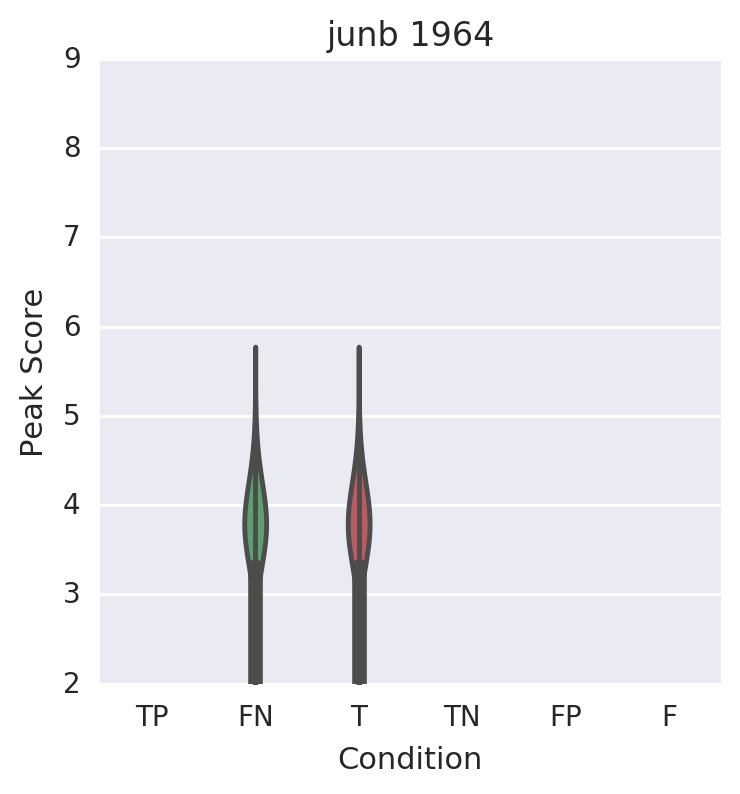

jund FP 7639 FN 15403 TP 14414
junb_jund LR+ 3.8651724026400904 LR- 0.2882351840416176 TPR 0.4834155012241339 FNR 0.25218572972264974
14414 15403 29817 53439 7639 61078


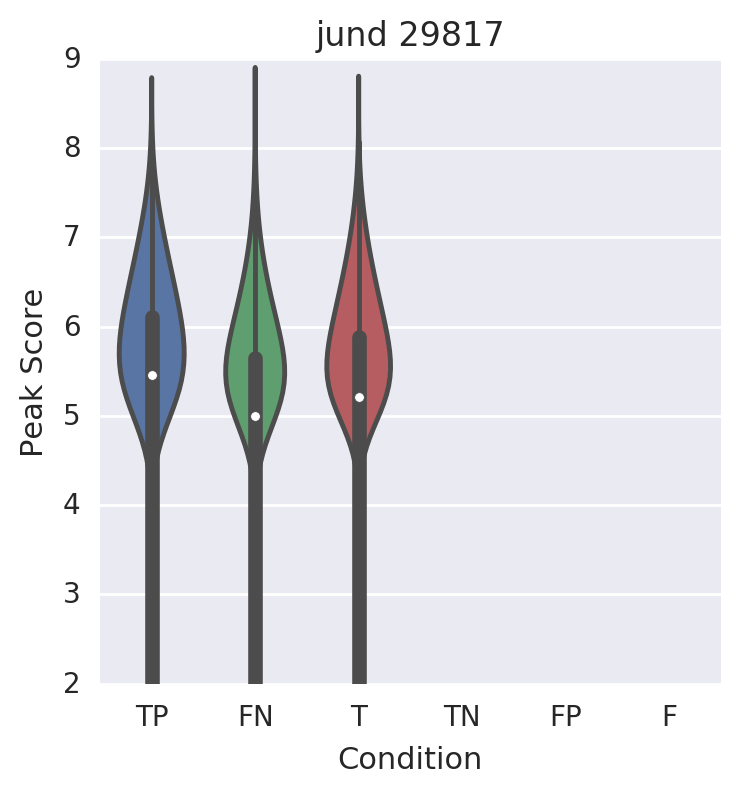

In [549]:
prob_threshold = 0.5
strain = 'c57bl6'
treatment = 'veh'
for monomer in ap1_members:
    # determine labels for: 1) True Positive, 2) False Negative, 3) True, 
    #                       4) True Negative, 3) False Positive, 4) False
    
    # determine monomers
    m1 = monomer
    
    true_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(m1 + '_' + treatment)
    
    probs = probs_frame_veh_std[m1]

    
    predicted_labels = probs_frame_veh_std[m1] > prob_threshold
    
    index_labels_tuples = list(zip(true_labels.index.values, # index
                                   true_labels.values,       # true label
                                   predicted_labels.values)) # predicted label
    TP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == True ])
    FN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == False ])
    T_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True])
    
    TN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == False ])
    FP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == True ])
    F_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False ])
    
    # visualize peak scores
    if min([len(TP_indices), len(FN_indices), len(T_indices),
            len(TN_indices), len(FP_indices), len(F_indices)]) >0:
        m1_TP_scores = summary_frame[summary_frame.index.isin(TP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FN_scores = summary_frame[summary_frame.index.isin(FN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_T_scores = summary_frame[summary_frame.index.isin(T_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_TN_scores = summary_frame[summary_frame.index.isin(TN_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_FP_scores = summary_frame[summary_frame.index.isin(FP_indices)][strain + '_' + m1 + '_' + treatment].values
        m1_F_scores = summary_frame[summary_frame.index.isin(F_indices)][strain + '_' + m1 + '_' + treatment].values

        scores = np.concatenate([m1_TP_scores, m1_FN_scores, m1_T_scores, m1_TN_scores, m1_FP_scores, m1_F_scores,
                                 ])
        numIndices = np.sum([len(TP_indices), len(FN_indices), len(T_indices),
                             len(TN_indices), len(FP_indices), len(F_indices)])
        monomers = ([m1] * numIndices )
        conditions = np.concatenate([len(m1_TP_scores) * ['TP'], 
                                     len(m1_FN_scores) * ['FN'],
                                     len(m1_T_scores) * ['T'], 
                                     len(m1_TN_scores) * ['TN'], 
                                     len(m1_FP_scores) * ['FP'], 
                                     len(m1_F_scores) * ['F'],
                                     ])
        print(monomer, 'FP', len(FP_indices), 'FN', len(FN_indices), 'TP', len(TP_indices))
        fpr = len(FP_indices)/len(F_indices)
        tpr = len(TP_indices)/len(T_indices)
        
        fnr = len(FN_indices)/len(F_indices)
        tnr = len(TN_indices)/len(F_indices)
        print(dimer, 'LR+',str(tpr/fpr), 'LR-',str(fnr/tnr), 'TPR', tpr, 'FNR', fnr)
        data = pd.DataFrame({'Peak Score': np.log2(scores+1), 'Monomer':monomers, 'Condition':conditions})
        sns.factorplot(data = data, kind='violin', y='Peak Score', x = 'Condition', showfliers=False, whis=None)
        plt.ylim(2,9)
        plt.title(monomer + ' '+ str(np.sum(true_labels)))
        print(len(m1_TP_scores),
                                     len(m1_FN_scores),
                                     len(m1_T_scores), 
                                     len(m1_TN_scores), 
                                     len(m1_FP_scores), 
                                     len(m1_F_scores))
        plt.show()
        
#         sns.distplot(probs_frame_veh_std[monomer])
#         plt.title(monomer)
#         plt.show()



# Introspection

In [ ]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values  

In [640]:
# for monomers using all motifs
factor_auc_dict_veh = {}
factor_precision_dict_veh = {}
factor_coeff_dict = {}
factor_prob_dict_veh = {}

for monomer in ap1_members:
    features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(monomer + '_veh')
    if np.sum(labels) >= 100:
        all_aucs = []
        all_coeficients = []
        all_probs = None
        all_precisions = []
        for i in range(numIterations):  

            # split data into training and test sets
            training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                features, labels, test_size = test_size, tolerance = 0.01)

            #  Run classifier
            lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

            lr_classifier.fit(training_features, training_labels)
            # retrieve probabilities
            probas_lr = lr_classifier.predict_proba(test_features)
            
            # score predictions
            current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
            current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)
            
            all_aucs.append(current_roc_auc)
            all_precisions.append(current_precision)

            # score all sequences
            probs = lr_classifier.predict_proba(features)[:, 1]

            current_coefficients = lr_classifier.coef_.flatten()
            all_coeficients.append(current_coefficients)

            if all_probs == None:
                all_probs = probs
            else:
                all_probs = all_probs + probs
       
        factor_auc_dict_veh[monomer]= all_aucs
        factor_precision_dict_veh[monomer] = all_precisions
        factor_coeff_dict[monomer] = all_coeficients
        factor_prob_dict_veh[monomer] = all_probs
        print(monomer.replace('c57bl6_',''),
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3 roc: 0.833038557424 3.47154894573e-06 precision: 0.705376441967 1.62498877516e-05 numTestPositives: 11028
cjun roc: 0.804495919225 2.70725933924e-06 precision: 0.614482844652 1.91557616712e-05 numTestPositives: 10087
fos roc: 0.827935420319 8.31380070558e-06 precision: 0.364231370023 1.32169202886e-05 numTestPositives: 1935
junb roc: 0.747922568746 1.37746866838e-05 precision: 0.0762459311378 5.60795384093e-06 numTestPositives: 909
jund roc: 0.823350371307 4.29567144575e-06 precision: 0.731779150329 1.41305332307e-05 numTestPositives: 13318


In [597]:
prob_threshold = 0.5
strain = 'c57bl6'
treatment = 'veh'
for monomer in ap1_members:
    # determine labels for: 1) True Positive, 2) False Negative, 3) True, 
    #                       4) True Negative, 3) False Positive, 4) False
    
    # determine monomers
    m1 = monomer
    
    true_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(m1 + '_' + treatment)
    
    probs = probs_frame_veh_std[m1]

    
    predicted_labels = probs_frame_veh_std[m1] > prob_threshold
    
    index_labels_tuples = list(zip(true_labels.index.values, # index
                                   true_labels.values,       # true label
                                   predicted_labels.values)) # predicted label
    TP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == True ])
    FN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True and x[2] == False ])
    T_indices = np.array([x[0] for x in index_labels_tuples if x[1] == True])
    
    TN_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == False ])
    FP_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False and x[2] == True ])
    F_indices = np.array([x[0] for x in index_labels_tuples if x[1] == False ])
    
    weights = coefficients_standardized_frame_veh_std[monomer]
    l1_penalty = np.sum(np.abs())
    
    

ValueError: invalid number of arguments

## VIF Calculation

In [662]:
### compute VIF for each motif for Vehicle and KLA separately
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
all_motifs = scaled_motif_frame.columns.values
# iterate through treatments
motif_vif_veh_dict = {}
motif_vif_kla_dict = {}

vifs = []
motif_names = []
treatments = []
for treatment in ['veh', 'kla']:
    # definte loci to use in regression; all open chromatin for a treatment condition
    c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
    features = scaled_motif_frame[scaled_motif_frame.index.isin(c57bl6_indices)]
    for motif in all_motifs:
        # separate current scores and all other scores
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]

        # perform linear regression
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        
        # calculate VIF
        vif = 1/(1-coeff_det)

        if treatment == 'veh':
            motif_vif_veh_dict[motif] = vif
        else:
            motif_vif_kla_dict[motif] = vif

        motif_names.append(motif)
        treatments.append(treatment)
        vifs.append(vif)

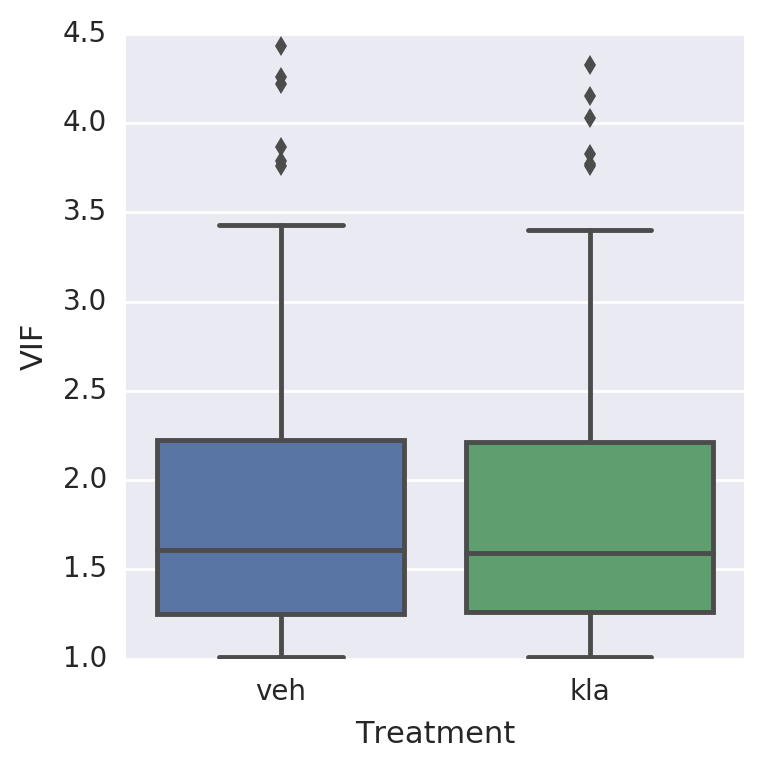

In [669]:
vif_frame = pd.DataFrame({'Motif Name': motif_names,
                          'Treatment': treatments,
                          'VIF':vifs})
sns.factorplot(data = vif_frame, 
               kind='box',
               x = 'Treatment',
               y = 'VIF')

## Robustness of Coefficients

In [670]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  


In [783]:
# for monomers using all motifs
factor_auc_dict = {}
factor_precision_dict = {}
factor_coeff_dict = {}
factor_prob_dict = {}
factor_meanCoeff_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(monomer + '_' + treatment)
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
        
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_dict[monomer + '_' + treatment] = mean_coefficients
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.832455746 1.55532946215e-06 precision: 0.704371688492 1.07985087522e-05 numTestPositives: 10998
cjun_veh roc: 0.806447581344 1.55902690123e-06 precision: 0.618442494332 3.4680074676e-06 numTestPositives: 10026
fos_veh roc: 0.826403627743 1.63236973764e-06 precision: 0.364952185064 1.39454504503e-05 numTestPositives: 1925
junb_veh roc: 0.747463921154 1.25117997417e-06 precision: 0.0783322802938 4.9819202628e-06 numTestPositives: 932
jund_veh roc: 0.823310151249 1.53182203218e-06 precision: 0.731875487884 4.82319718909e-06 numTestPositives: 13345
atf3_kla roc: 0.802435430908 7.43814139514e-07 precision: 0.494206173922 5.30918651236e-06 numTestPositives: 7099
cjun_kla roc: 0.832098268696 1.89111387644e-06 precision: 0.82541062495 5.30536251251e-06 numTestPositives: 20466
fos_kla roc: 0.852171562863 3.27478593512e-06 precision: 0.883177609953 3.43796523443e-06 numTestPositives: 22171
junb_kla roc: 0.825965003696 5.39722916167e-07 precision: 0.780507330458 3.17259010636e-06 

In [785]:
coefficient_frame = pd.DataFrame(factor_meanCoeff_dict)
coefficient_frame.index = standardized_motif_frame.columns.values
# transform_coffcients into z-scores
scaler = preprocessing.StandardScaler()
coefficients_standardized_frame = pd.DataFrame(scaler.fit_transform(coefficient_frame))
coefficients_standardized_frame.index = coefficient_frame.index.values
coefficients_standardized_frame.columns = coefficient_frame.columns.values

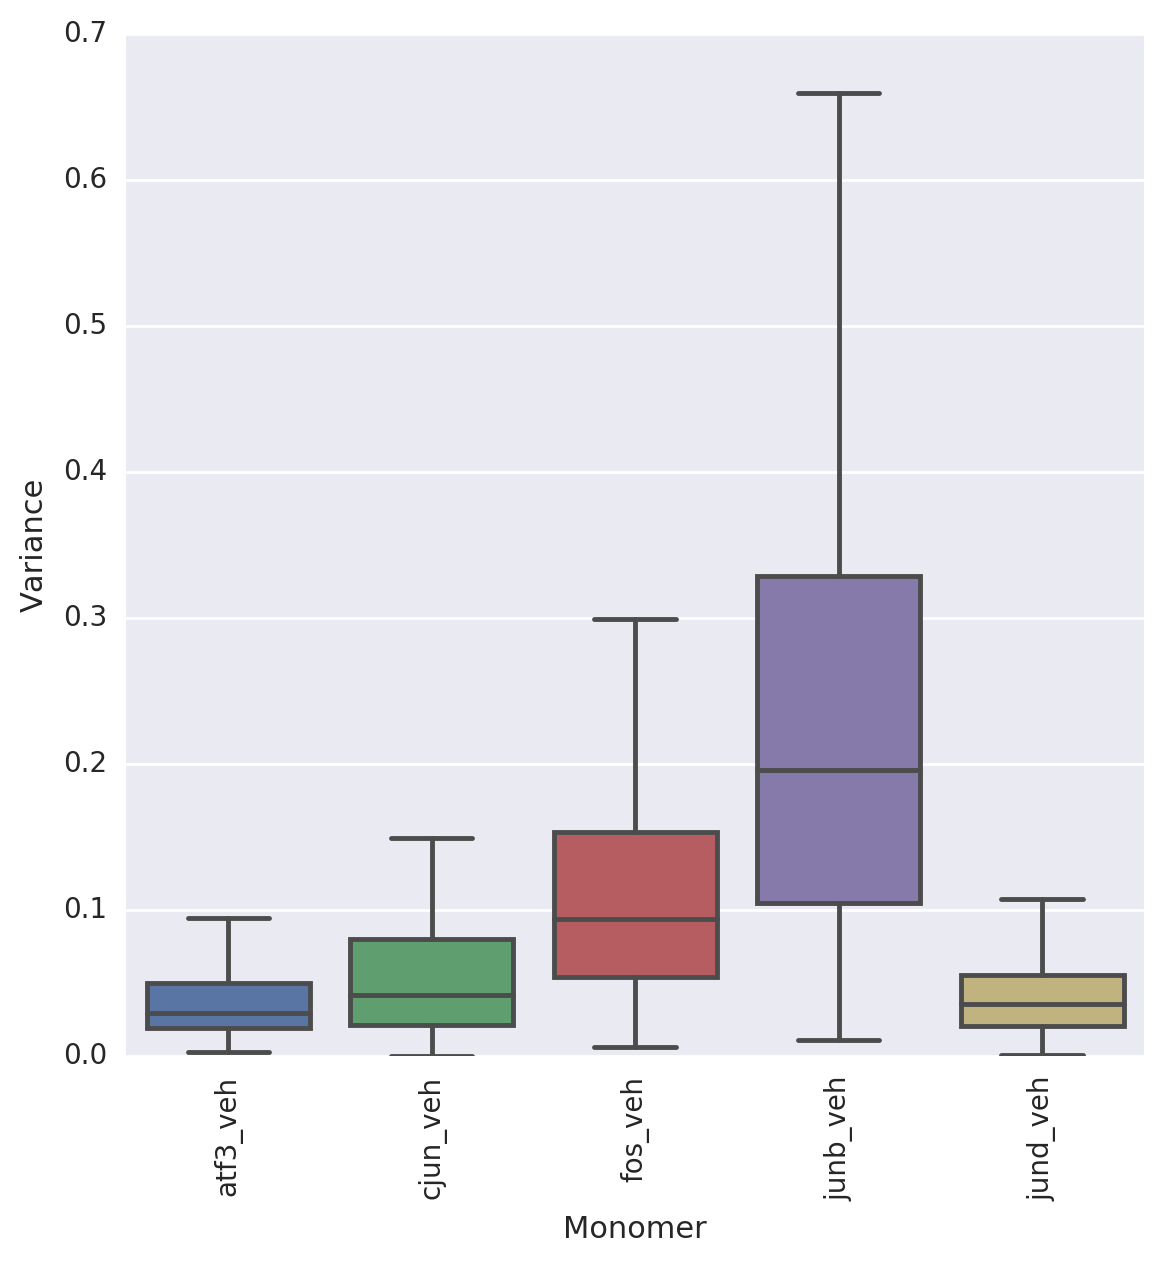

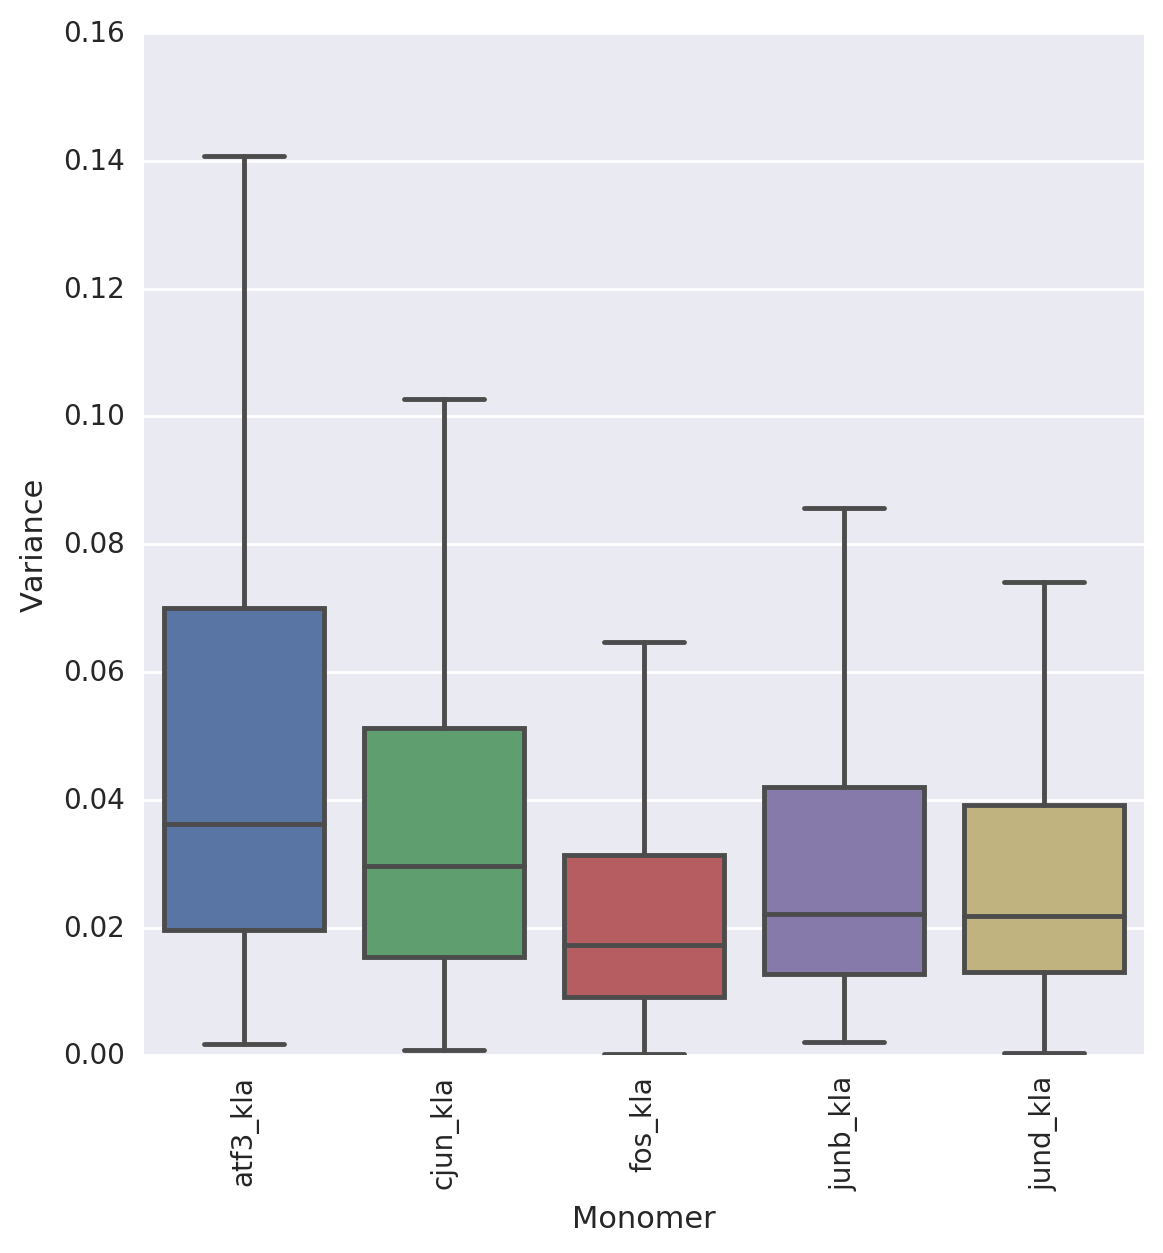

In [812]:
### box plots of coefficient variance ###
monomers = []
variances = []
motif_names = []
treatments = []
scaled_variances = []
weight_threshold = 0.0
for monomer in sorted(factor_coeff_dict.keys()):
    monomers = monomers + ([monomer] *  len(motifs))  
    
    motif_names  = motif_names + motifs
    all_coefficients = factor_coeff_dict[monomer]
    current_coeff_frame = pd.DataFrame(all_coefficients).T
    
    scaler = sklearn.preprocessing.StandardScaler()
    current_coeff_frame_std = pd.DataFrame(scaler.fit_transform(current_coeff_frame))
    current_var = current_coeff_frame_std.var(axis=1)

    variances = variances + list(current_var)

data = pd.DataFrame({'Monomer':monomers,
                     'Variance':variances,
                     'Motif Name': motif_names
                     })

# consider only motifs with weight greater than weight_threshold for at least one monomer in one condition
selected_motifs = coefficients_standardized_frame[coefficients_standardized_frame.abs().max(axis=1) >= weight_threshold].index.values

for treatment in ['veh', 'kla']:
    sns.factorplot(data = data[(data['Monomer'].str.contains(treatment)) &
                               (data['Motif Name'].isin(selected_motifs))],
                   x = 'Monomer',
                   y= 'Variance',
                   kind = 'box',
                   size=6, 
                   showfliers= False)
    plt.xticks(rotation=90)
    plt.show()


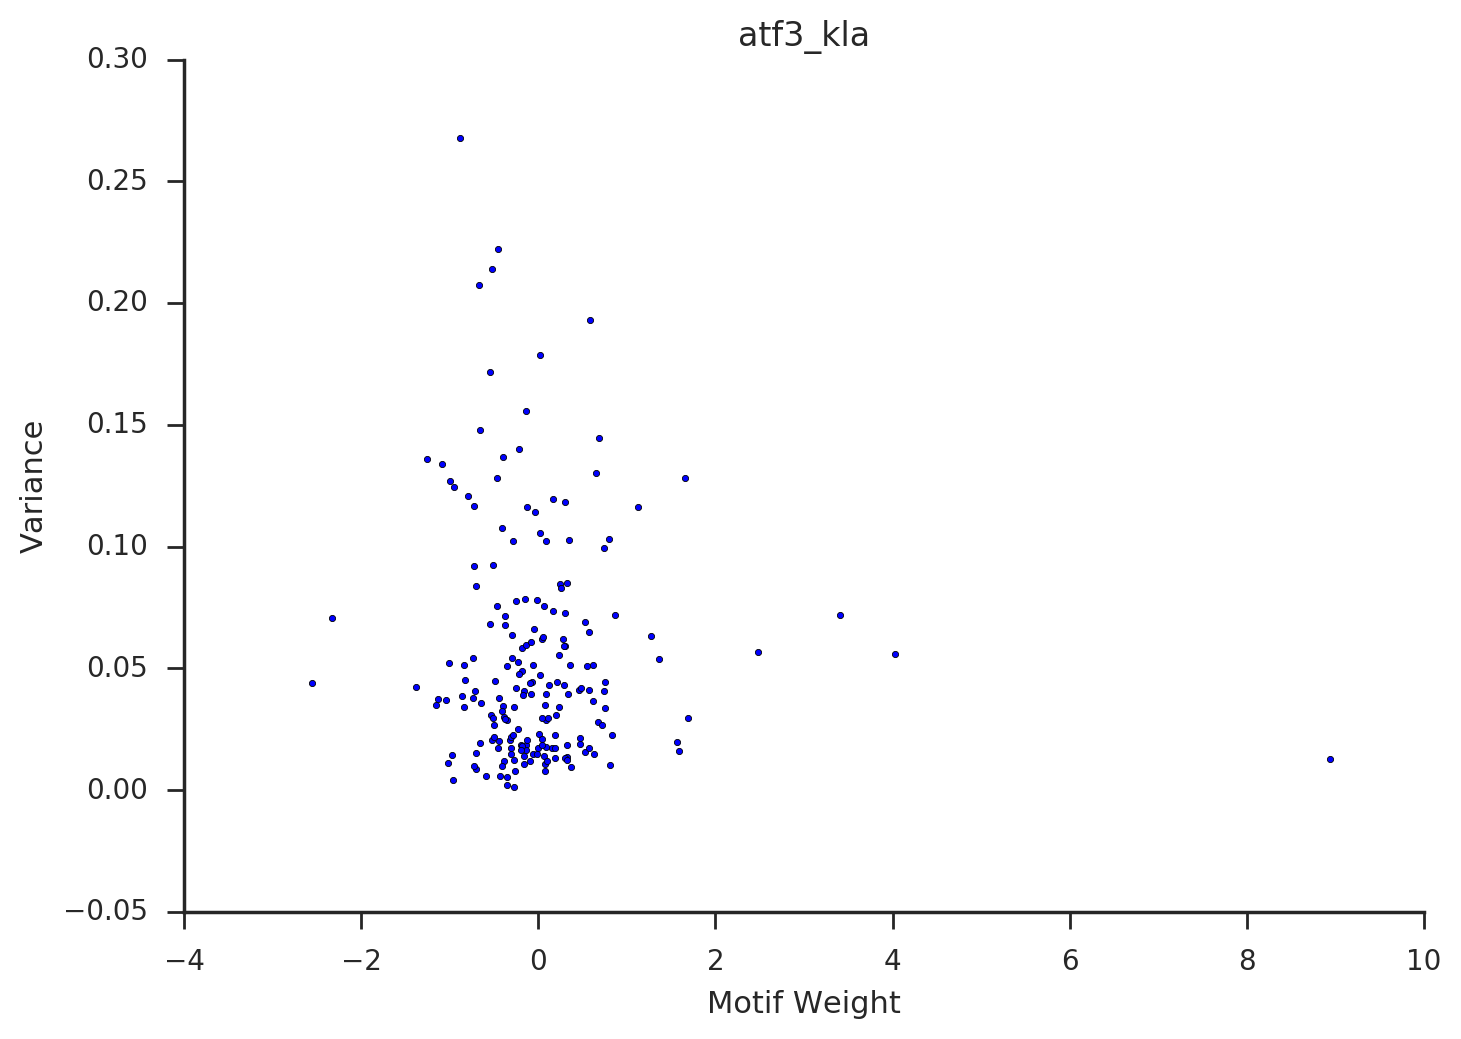

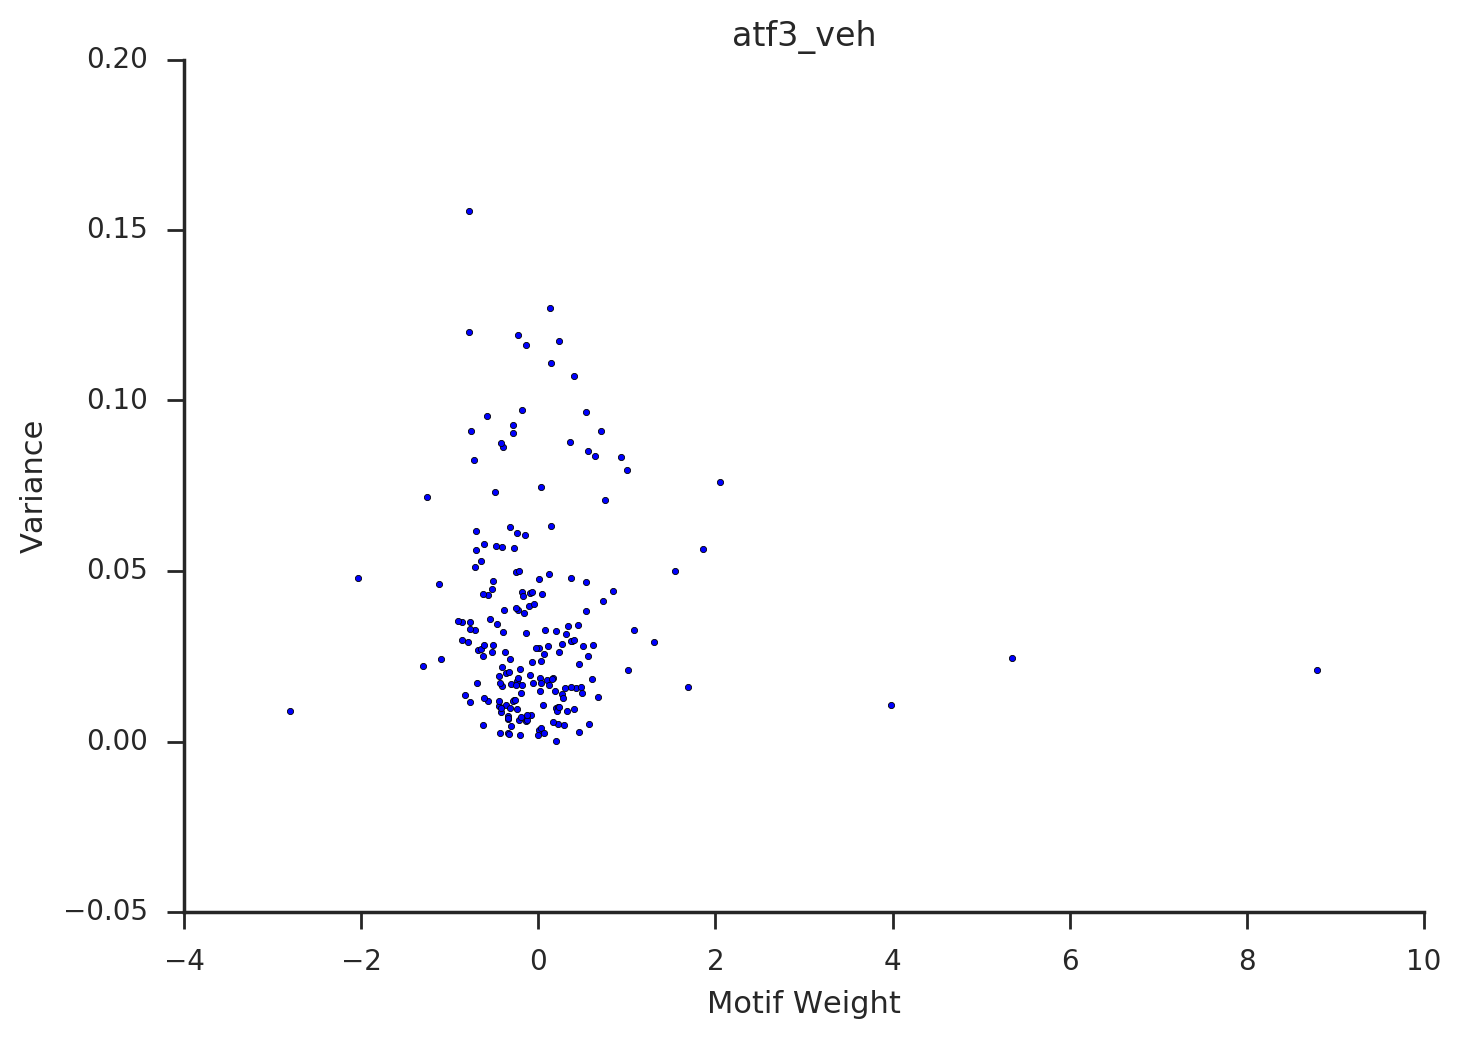

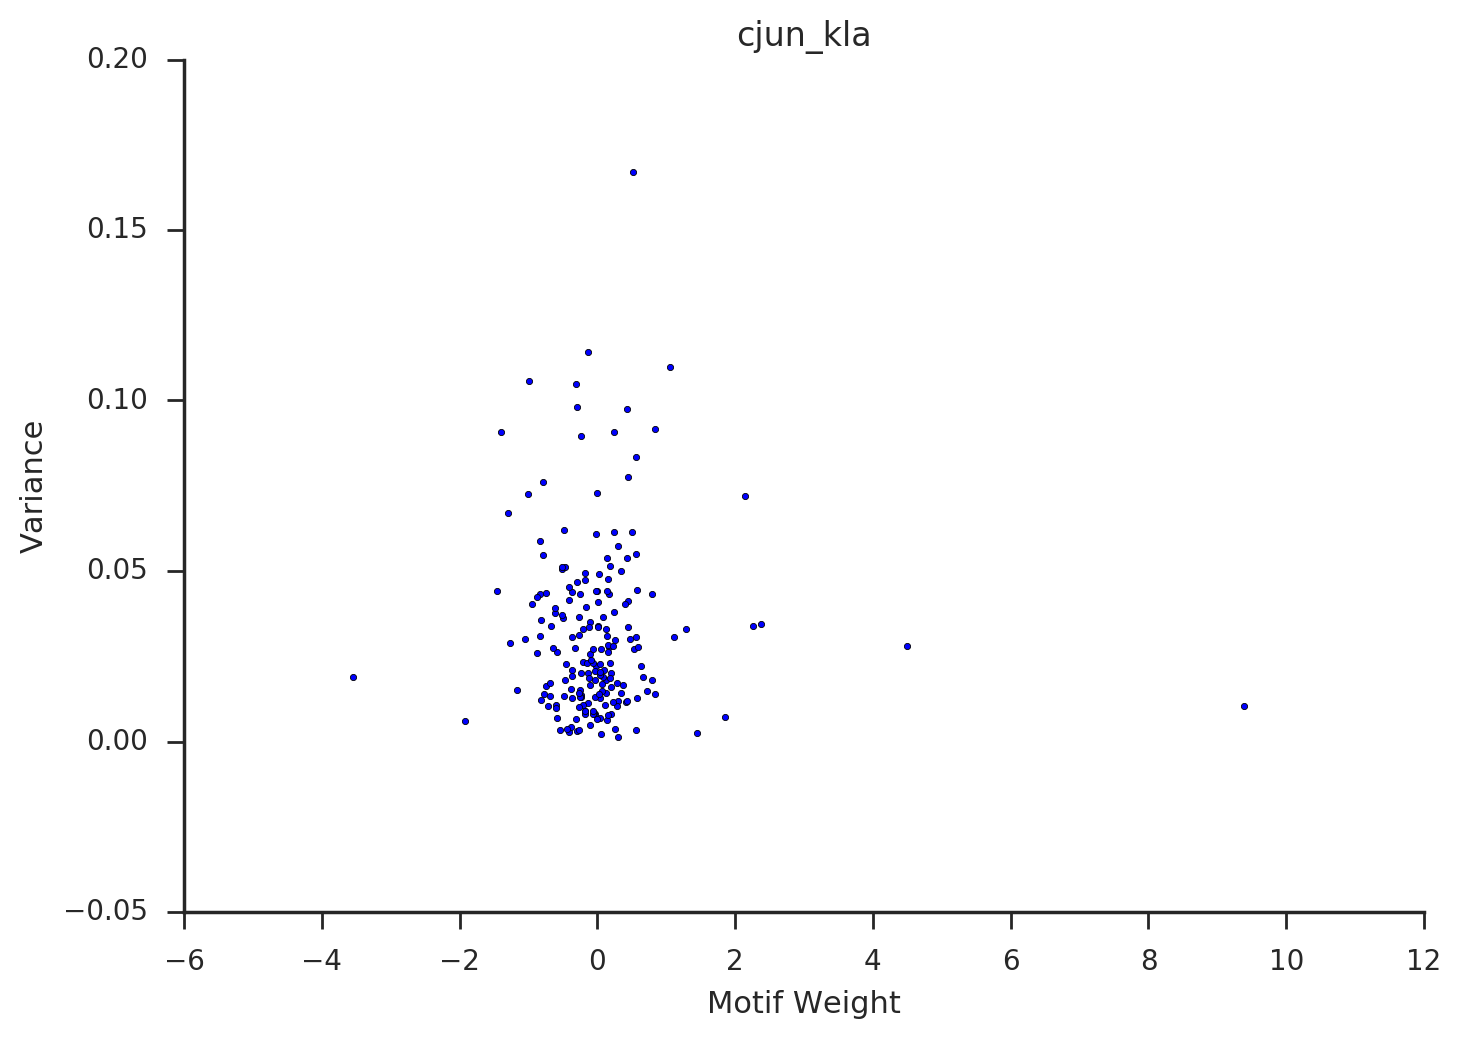

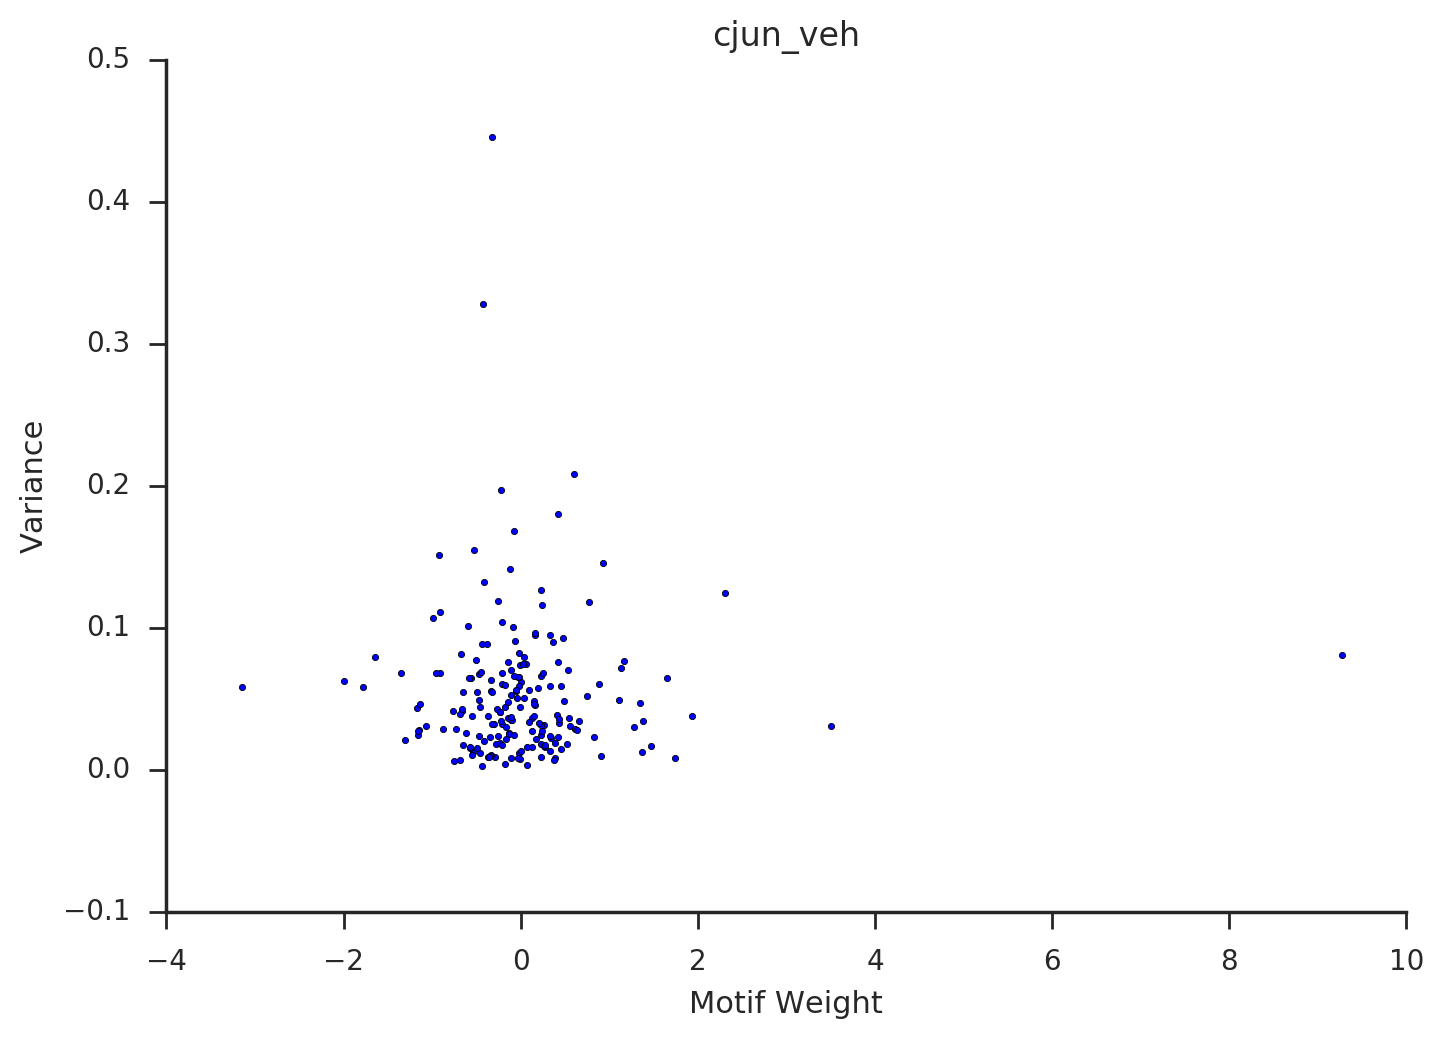

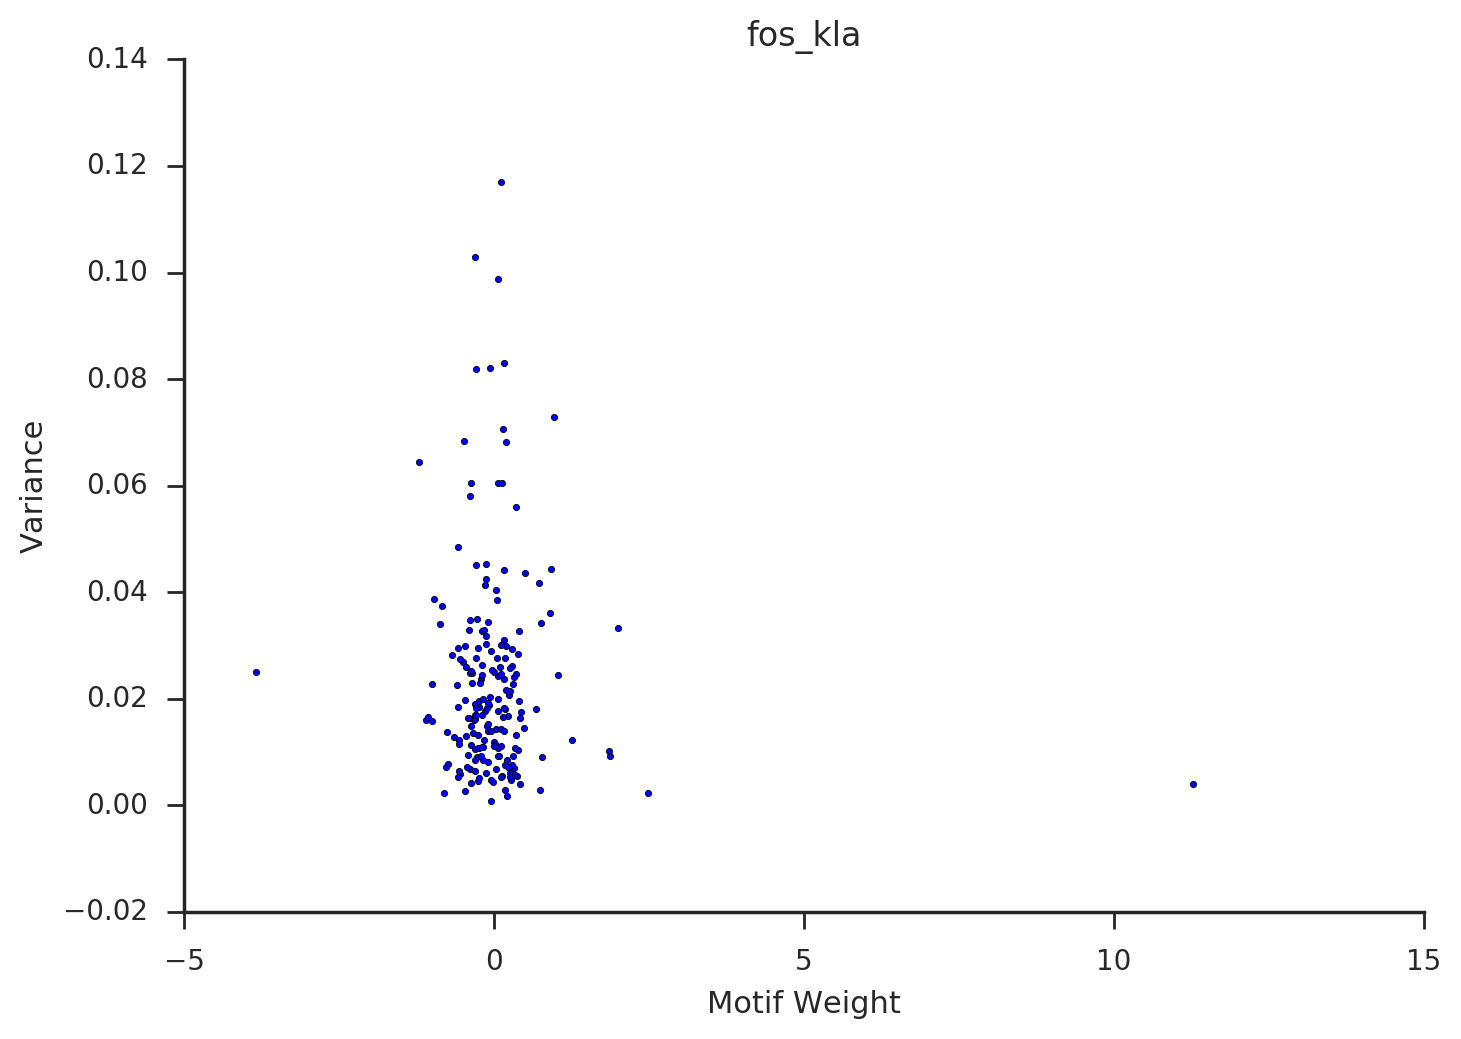

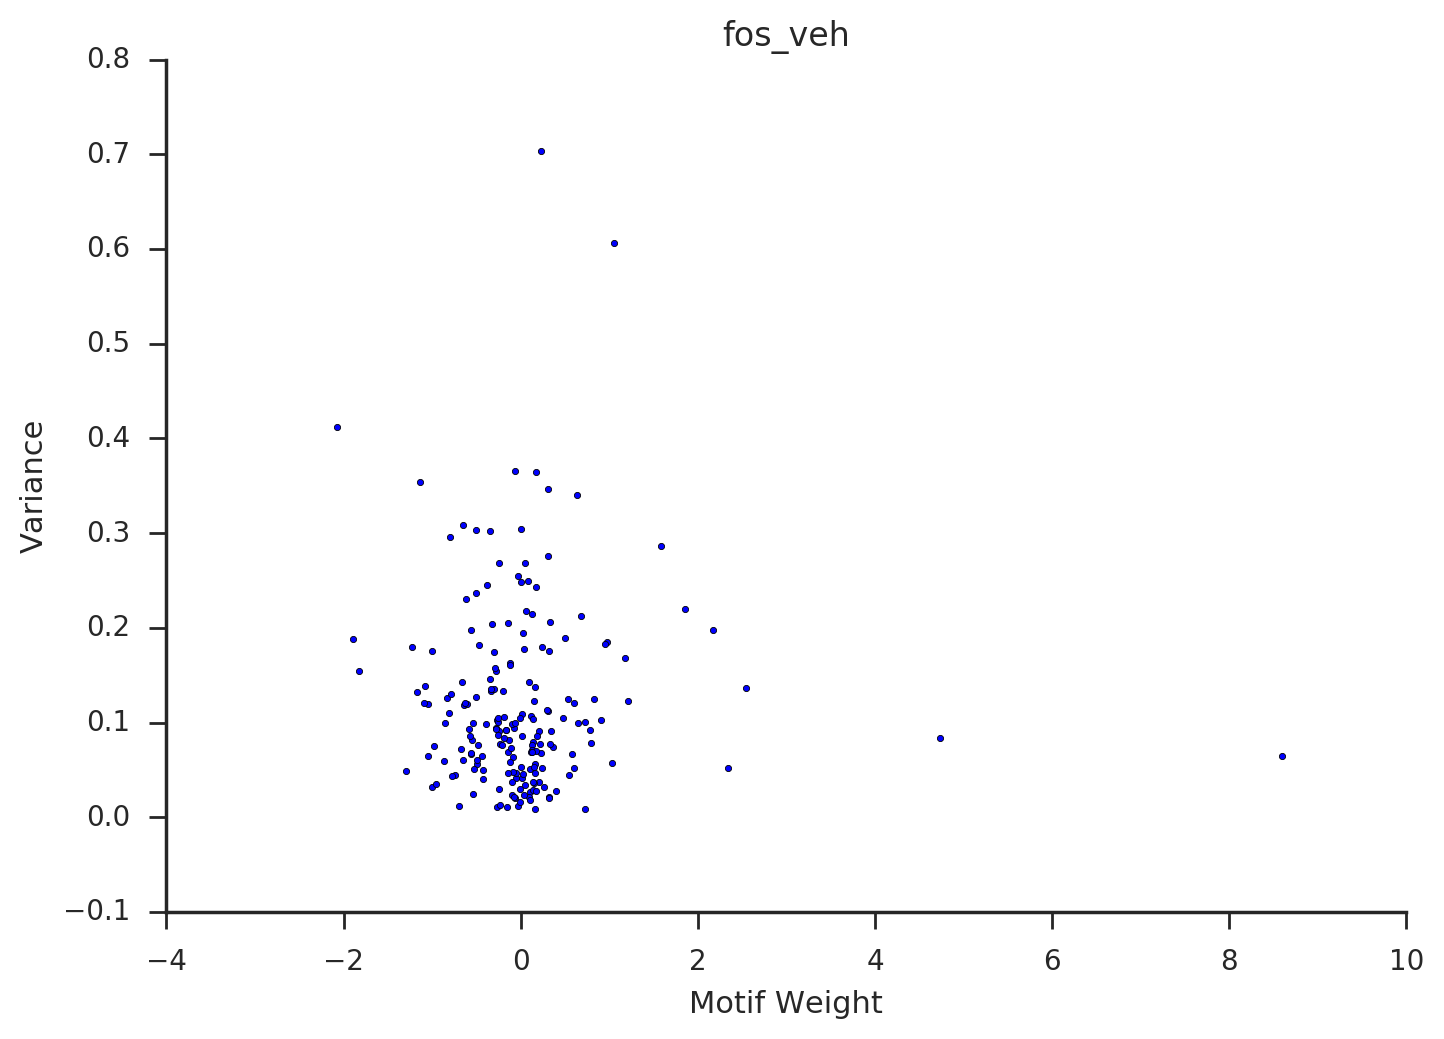

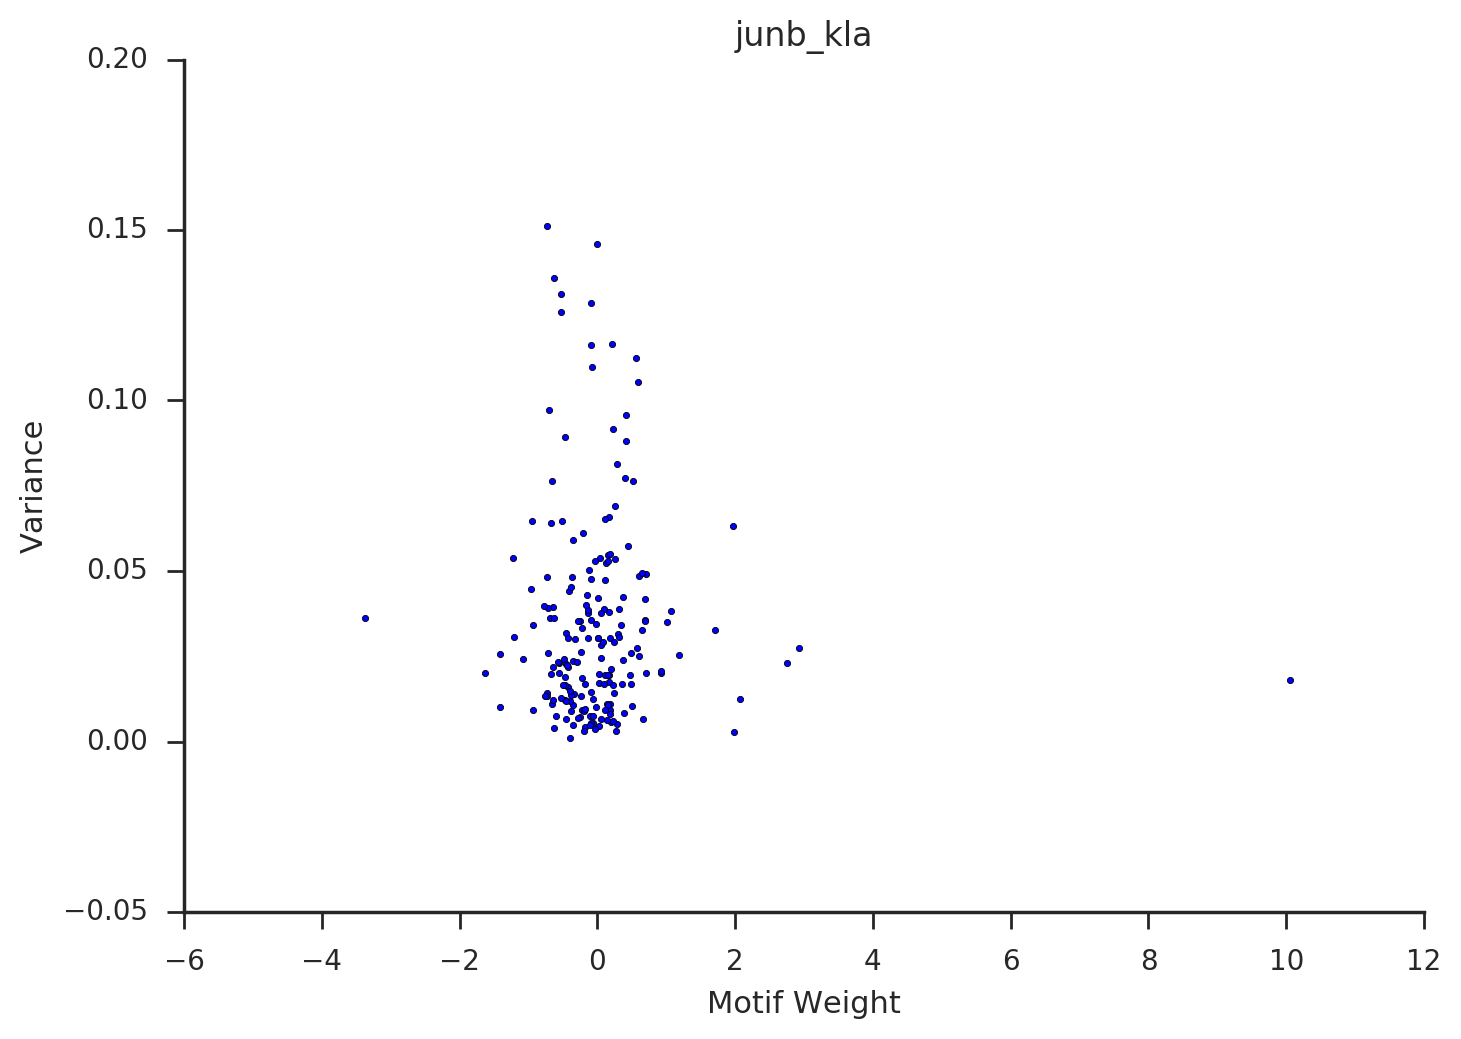

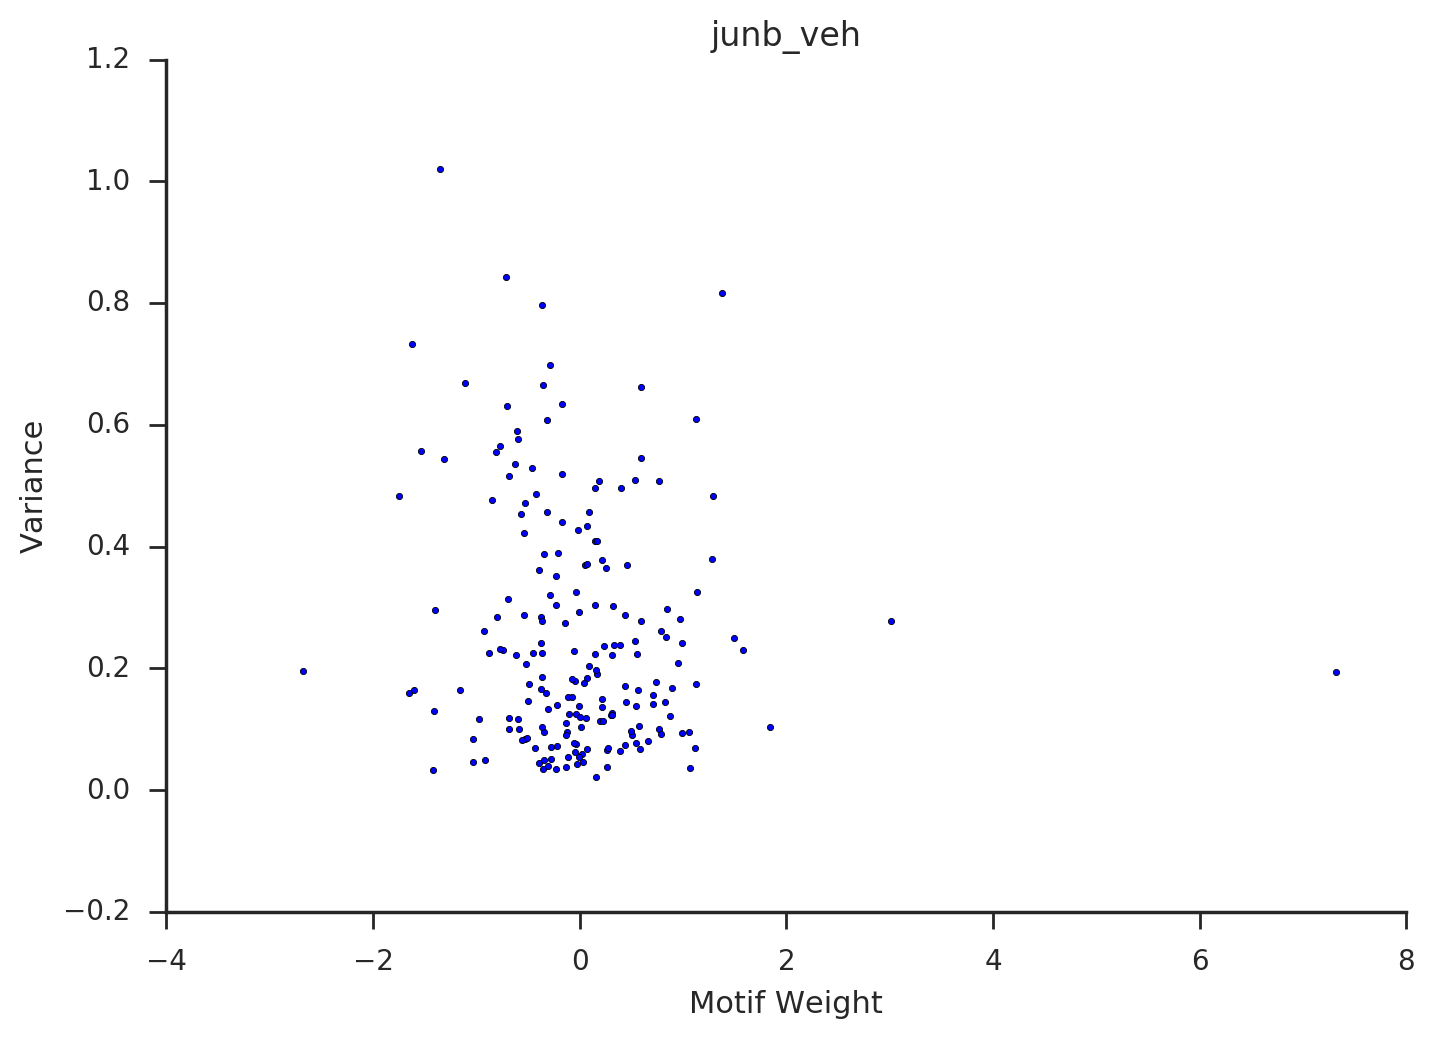

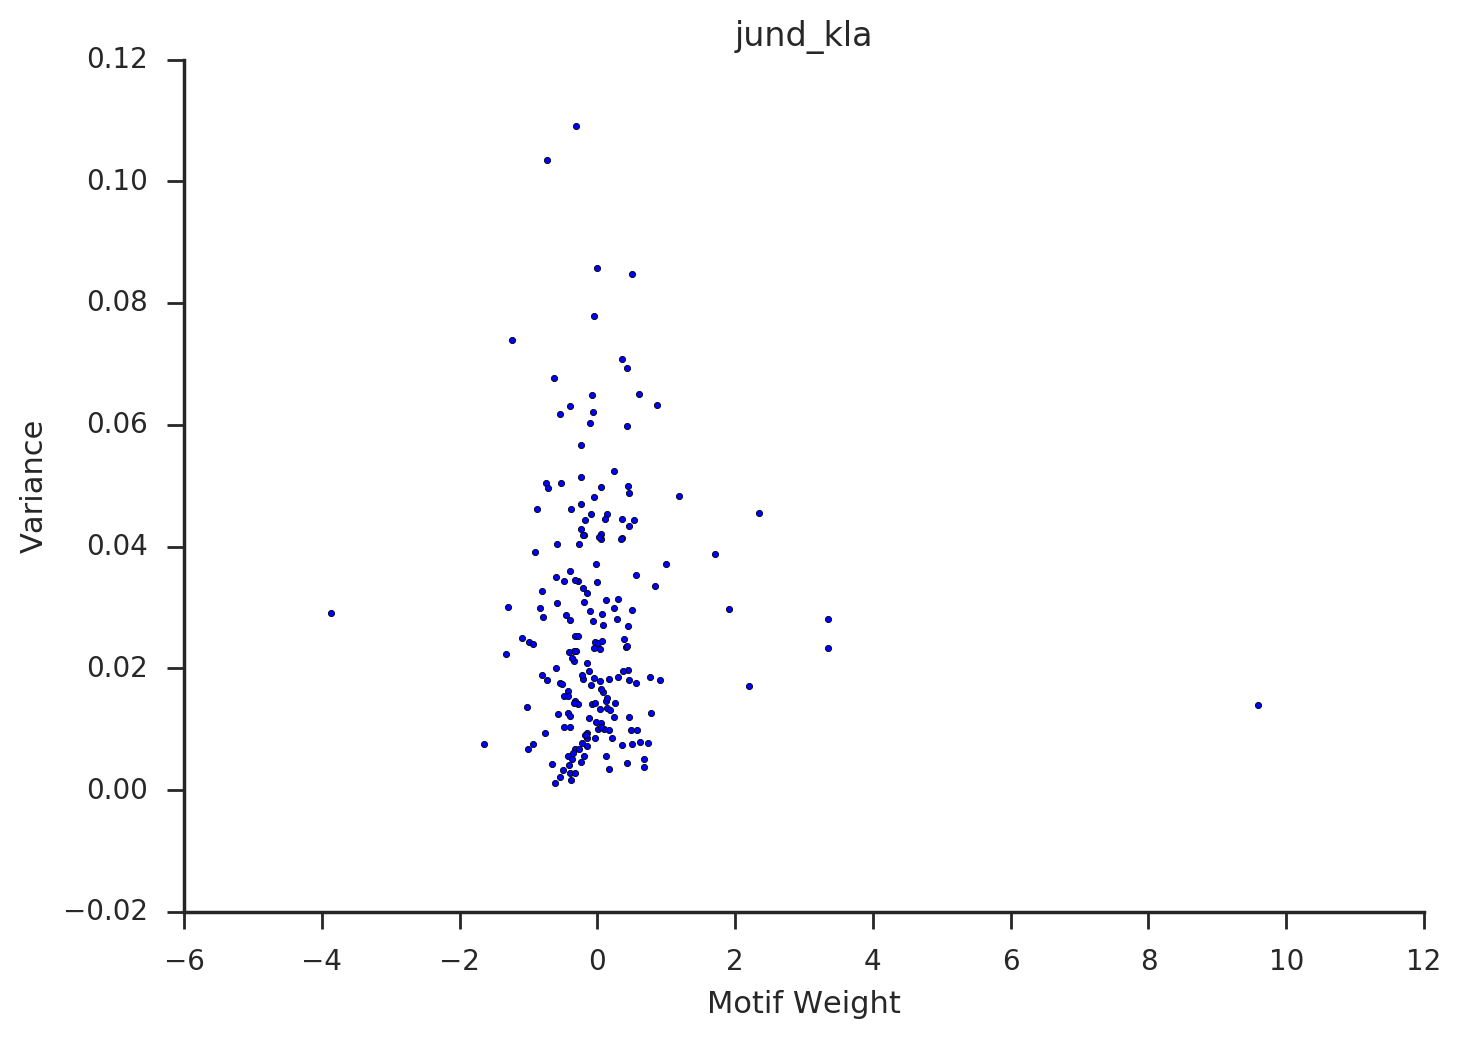

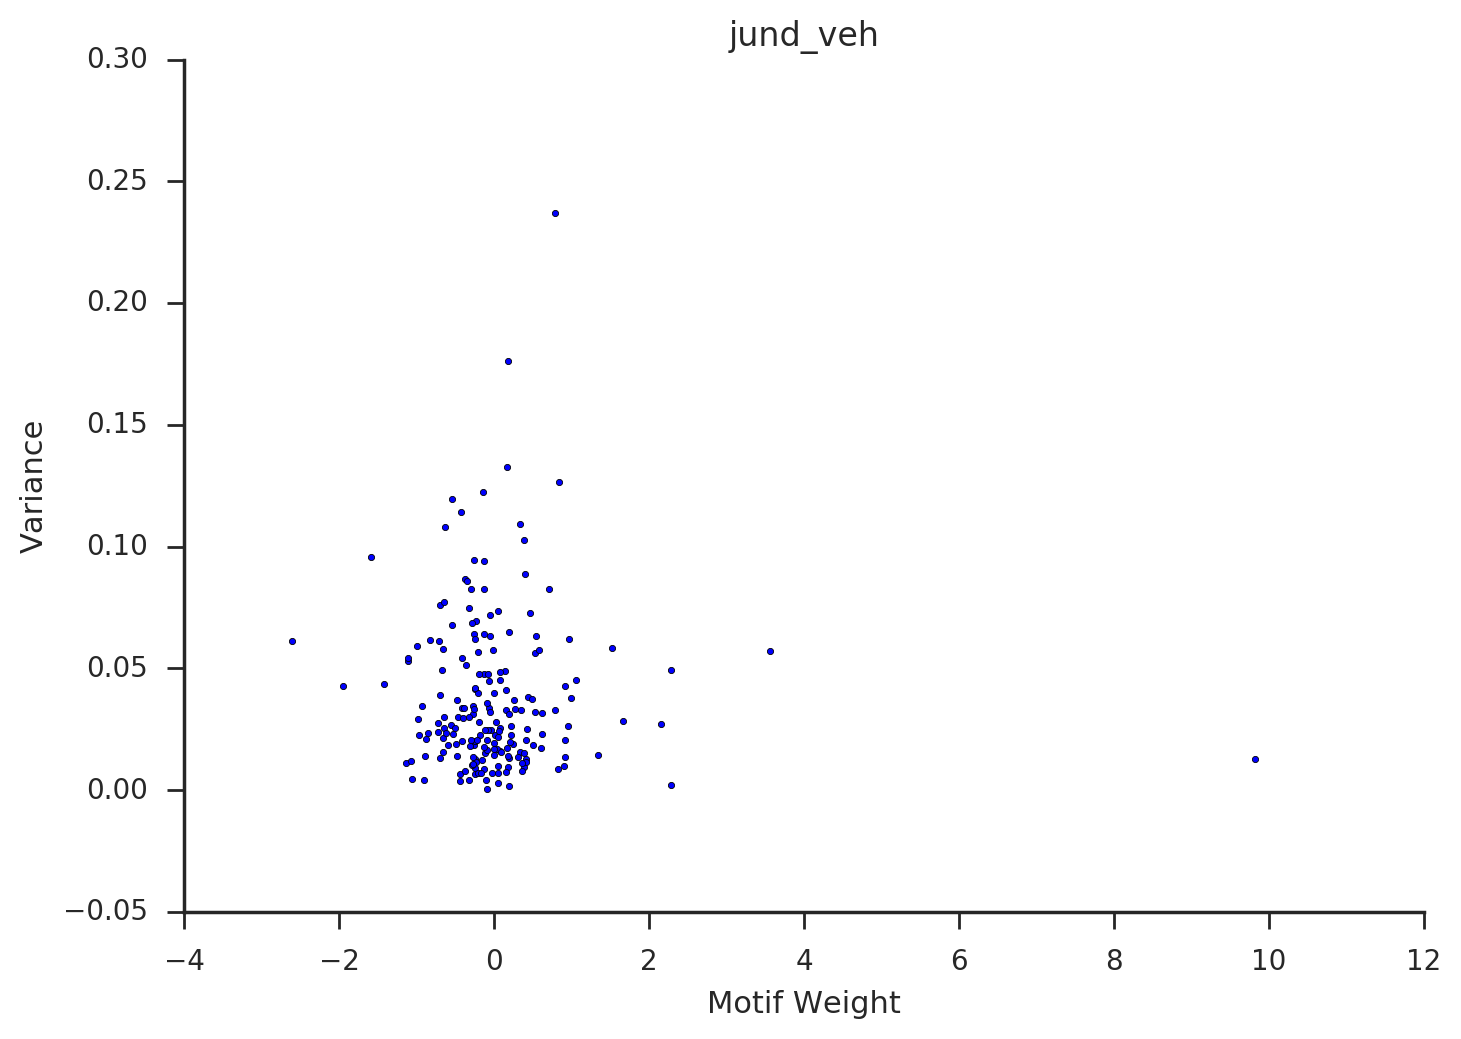

In [760]:
### mean motif vs variance scatter plots for each monomer ###
for monomer in sorted(factor_coeff_dict.keys()):

    all_coefficients = factor_coeff_dict[monomer]
    current_coeff_frame = pd.DataFrame(all_coefficients)
    scaler = sklearn.preprocessing.StandardScaler()
    all_coefficients_frame_std = pd.DataFrame(scaler.fit_transform(current_coeff_frame.T))
    current_var = all_coefficients_frame_std.var(axis=1)
    current_mean = all_coefficients_frame_std.mean(axis=1)
    with sns.axes_style('ticks'):
        plt.scatter(current_mean, current_var, marker = '.')
        plt.title(monomer)
        plt.ylabel('Variance')
        plt.xlabel('Motif Weight')
        sns.despine()
        
        plt.show()



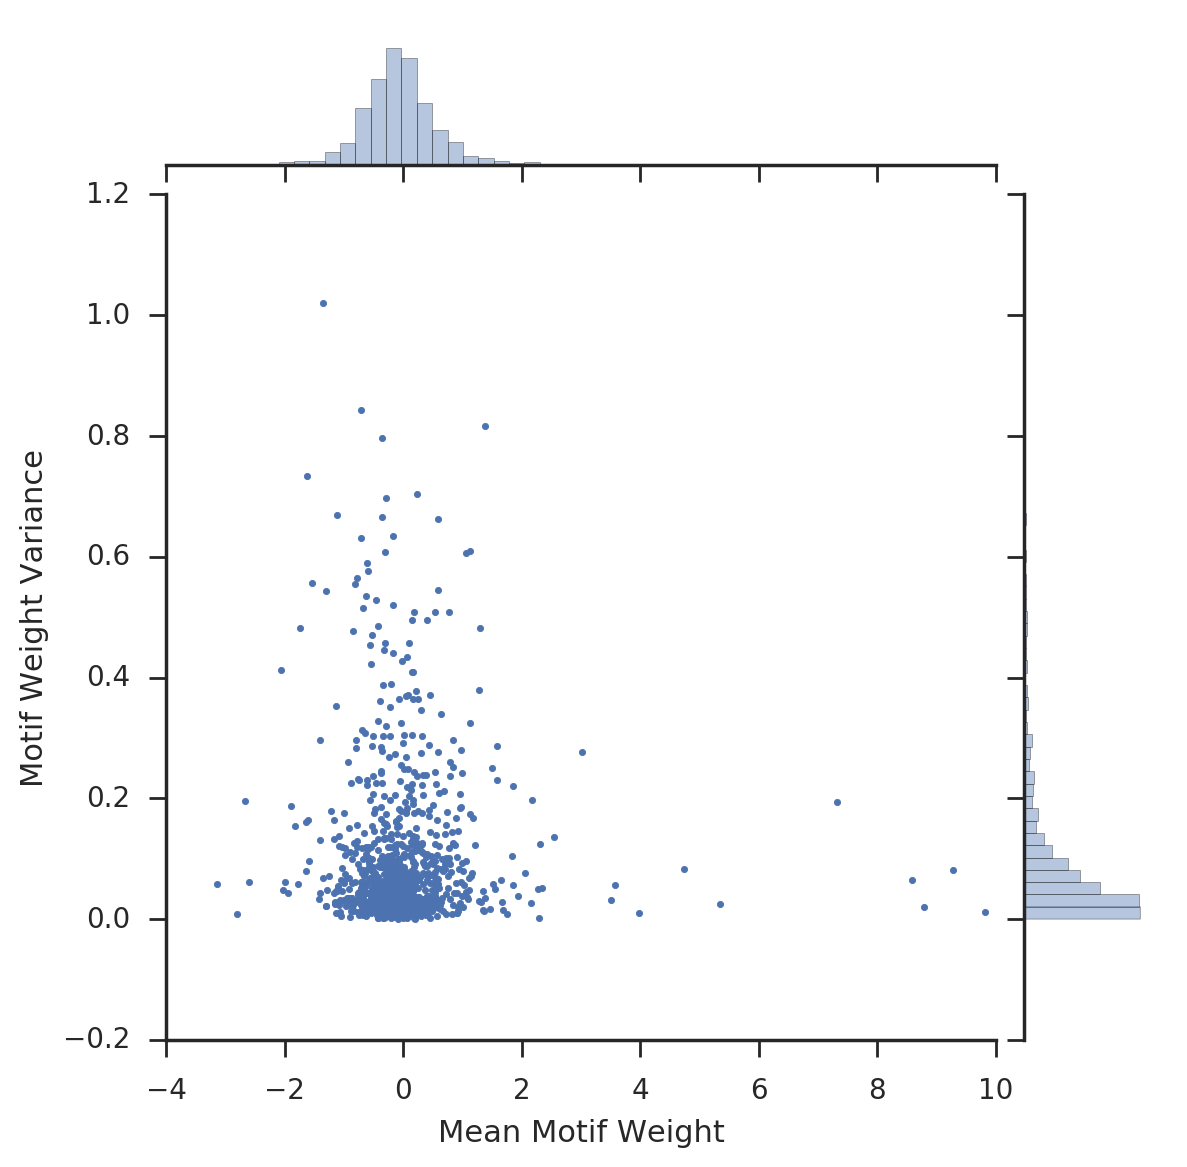

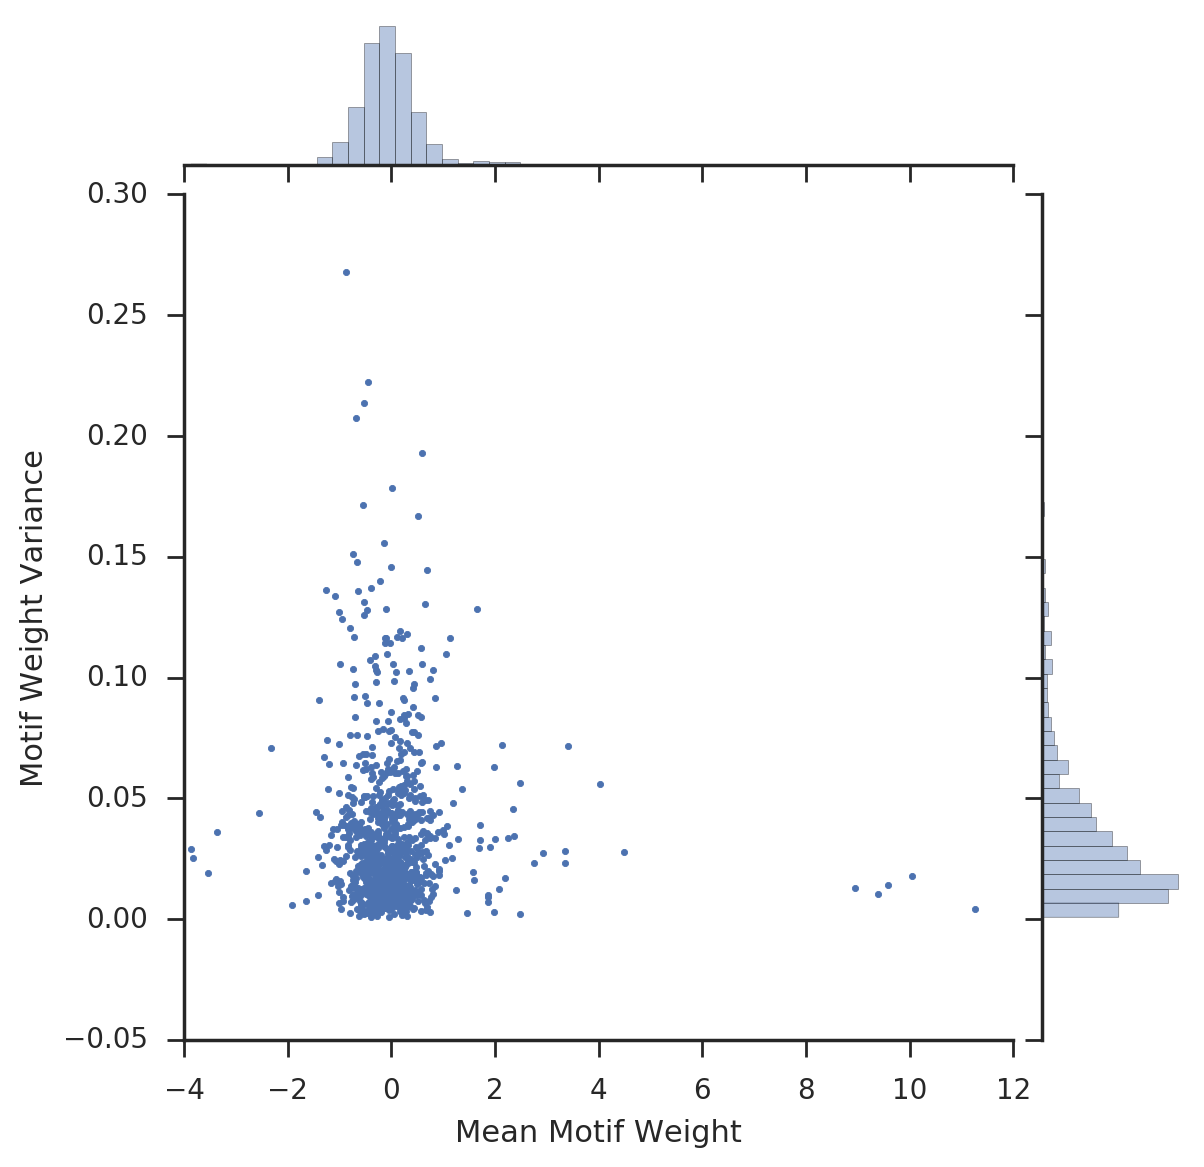

In [770]:
### box plots of coefficient variance ###
monomers = []
variances = []
motif_names = []
treatments = []
means = []
for monomer in sorted(factor_coeff_dict.keys()):
    monomers = monomers + ([monomer] *  len(motifs))  
    
    motif_names  = motif_names + motifs
    all_coefficients = factor_coeff_dict[monomer]
    current_coeff_frame = pd.DataFrame(all_coefficients).T
    scaler = sklearn.preprocessing.StandardScaler()
    current_coeff_frame_std = pd.DataFrame(scaler.fit_transform(current_coeff_frame))
    current_var = current_coeff_frame_std.var(axis=1)
    current_means = current_coeff_frame_std.mean(axis=1)
    variances = variances + list(current_var)
    means = means + list(current_means)

data = pd.DataFrame({'Monomer':monomers,
                     'Motif Weight Variance':variances,
                     'Motif Name': motif_names,
                     'Mean Motif Weight':means
                     })
for treatment in ['veh', 'kla']:
    with sns.axes_style('ticks'):
        sns.jointplot(data = data[data['Monomer'].str.contains(treatment)],
                       x = 'Mean Motif Weight',
                       y= 'Motif Weight Variance',
                       kind = 'scatter',
                      stat_func = None,
                      marker='.'
                       )
        plt.xticks(rotation=90)
        plt.show()

